#0.ライブラリ読み込み

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd drive/"My Drive"/Reserch_Train/
%ls

/content/drive/My Drive/Reserch_Train
 2019_Train_data/
 2019_Train_data_1st+2nd_undersampling/
 aug_npys/
 cepstrum.py
 cnn_model/
 cnn_models/
 cnn_models_nopreproc/
 cnn_models_ssnmf/
 cnn_npys/
'Colab Notebooks'/
 cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
 cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb.1
 data/
 data_generator.py
 datas_cut.npy
 datas.npy
 labels_cut.npy
 labels.npy
 model.png
 models/
 nmf.py
 nopreproc_data_cut.npy
 noresample_nopreproc_data_cut.npy
 npy_backup/
 npys/
 packed_features/
 prepare_data.py
 __pycache__/
 q
 rem_rem_stft6000.npy
 requirements_sednn.txt
 requirements.txt
 sednn_datas_cut.npy
 sednn_datas.npy
 sep.py
 spectrogram_to_wave.py
 ssnmf_datas_cut.npy
 ssnmf_labels_cut.npy
 SVM_for_SEDNN.ipynb
 Target/
 test.py
 tsne.py
 tsne_result_basis.npy
 tsne_result_nmf+train.npy
 tsne_result_nmf+train+rem.npy
 tsne_result_.npy
 Untitled1.ipynb


In [0]:
!apt-get --purge remove cuda*
!apt autoremove

!wget https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
!dpkg -i cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
!apt-key add /var/cuda-repo-*/7fa2af80.pub
!apt-get update
!apt-get install cuda-9-0

!pip uninstall -y tensorflow
!pip install tensorflow-gpu==1.12.0

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
E: Couldn't find any package by glob 'cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb'
E: Couldn't find any package by regex 'cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages will be REMOVED:
  libnvidia-common-430
0 upgraded, 0 newly installed, 1 to remove and 7 not upgraded.
After this operation, 35.8 kB disk space will be freed.
(Reading database ... 145674 files and directories currently installed.)
Removing libnvidia-common-430 (430.64-0ubuntu0~gpu18.04.1) ...
--2020-01-02 18:42:13--  https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
Resolving developer.nvidia.com (developer.nvidia.com)... 192.229.162.216
Connecting to

In [0]:
!pip install bhtsne
!pip install -r requirements_sednn.txt

In [0]:
#音源分離手法SEDNN用
import sys
sys.path.append('/content/drive/My Drive/Reserch_Train/')
import librosa
import scipy
import random
import numpy as np
import os
import pickle
import h5py
import argparse
import time
import glob
import matplotlib.pyplot as plt
import _pickle as cPickle
from sklearn.model_selection import train_test_split
"""
import tensorflow as tf 
import prepare_data as pp_data
from data_generator import DataGenerator
from spectrogram_to_wave import recover_wav
from tensorflow.python.keras.layers import Dense, Dropout, Flatten
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.optimizers import Adam
"""
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from copy import deepcopy
#from sep import Functions

#from keras.models import Sequential
#from keras.layers import Dense, Dropout, Flatten
#from keras.optimizers import Adam

In [0]:
#機械学習手法用
import keras
import sys
sys.path.append('/content/drive/My Drive/Reserch_Train/')
import scipy
import random
import numpy as np
import os
import pickle
import h5py
import argparse
import time
import glob
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn import model_selection
from sklearn import preprocessing
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten, Reshape
from keras.layers import Conv1D, GlobalAveragePooling1D
from keras.layers import BatchNormalization, Add
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
import argparse

Using TensorFlow backend.


#1.データ作成処理
#----------------------------------------------------------------------------#

##1-1.よく使う関数の定義

In [0]:
def lengthcheck(X_list):
    length = 0
    for x in X_list:
        if length <= len(x):
            length = len(x)
    return length

#周波数応答を算出
def amptitude_frequency(x):
    N = len(x)
    win = scipy.signal.hann(N)
    spectrum = scipy.fftpack.fft(x * win)
    #amp = np.abs(spectrum[1:20])
    res = np.array([np.sqrt(c.real ** 2 + c.imag ** 2) for c in spectrum])#[:20]
    res = res / np.max(res)
    return res
    
#mono化（現状使わず）
def to_mono(x):
    wav_l = x[:, 0]
    wav_r = x[:, 1]
    xs = (0.5 * wav_l) + (0.5 * wav_r)
    return xs

def preprocess(x, n_pad, scale, scaler, n_concat, n_hop, n_window, n_overlap, window=np.hamming):
  #complx_x = pp_data.calc_sp(x, mode='complex', n_window=n_window, n_overlap=n_overlap, window=window)
  complx_x = pp_data.calc_sp(x, 'complex', n_window, n_overlap, window)
  x = pp_data.pad_with_border(np.abs(complx_x), n_pad)
  x = pp_data.log_sp(x)     
  # Scale data. 
  if scale:
    x = pp_data.scale_on_2d(x, scaler)
  # Cut input spectrogram to 3D segments with n_concat. 
  x = pp_data.mat_2d_to_3d(x, agg_num=n_concat, hop=1)
  return x, complx_x

def postprocess(x, complx_x, n_overlap, scale, scaler, window=np.hamming):
  # Inverse scale. 
  if scale:
      x = pp_data.inverse_scale_on_2d(x, scaler)
  x = np.exp(x)
  s = recover_wav(x, complx_x, n_overlap, window)
  s *= np.sqrt((np.hamming(n_window)**2).sum()) 
  return s
        
def allplot(mix, pred):
  fig, axs = plt.subplots(2,1, sharex=False)
  axs[0].matshow(mix.T, origin='lower', aspect='auto', cmap='jet')
  axs[1].matshow(pred.T, origin='lower', aspect='auto', cmap='jet')
  axs[0].set_title("Mixture log spectrogram")
  axs[1].set_title("Pred inverter log spectrogram")
  for j1 in xrange(2):
      axs[j1].xaxis.tick_bottom()
  plt.tight_layout()
  plt.show()

def alignx(x, length):
    x = np.pad(x,(0,length-len(x)),"constant")
    return x

##1-2.データの準備

In [0]:
#lengthをチェック
#Folder_name = ["Forward_direction","Reverse_direction"]
Folder_name = ["Reverse_direction"]
targetname = ["2019_Train_data_1st+2nd_undersampling/305/" + str(one) for one in Folder_name]
workspace = "./"
target_fs = 16000
fs = target_fs
resample = False

list_ = []
for target in targetname:
    for c in os.listdir(target):
        if "wav" in c or ".DS_Store" in c :
            continue
        else :
            d = os.path.join(target, c)
            for wavname in [nam.replace(".wav","") for nam in os.listdir(d)]:
                print('label: {}'.format(c))
                if ".DS_Store" in wavname:
                    continue
                wavname = os.path.join(d, wavname)
                s, _ = librosa.load(wavname + ".wav")
                if resample == True:
                  s = librosa.resample(s, orig_sr=_, target_sr=target_fs)
                list_.append(s)
length = lengthcheck(list_)

label: 2
label: 2
label: 2
label: 2
label: 2
label: 2
label: 2
label: 2
label: 2
label: 2
label: 2
label: 2
label: 2
label: 3
label: 3
label: 3
label: 3
label: 3
label: 3
label: 3
label: 3
label: 3
label: 3
label: 3
label: 3
label: 1
label: 1
label: 1
label: 1
label: 1
label: 1
label: 1
label: 1
label: 1
label: 1
label: 1
label: 1
label: 1
label: 6
label: 6
label: 6
label: 6
label: 6
label: 6
label: 6
label: 6
label: 6
label: 6
label: 6
label: 6
label: 6
label: 5
label: 5
label: 5
label: 5
label: 5
label: 5
label: 5
label: 5
label: 5
label: 5
label: 5
label: 5
label: 5
label: 4
label: 4
label: 4
label: 4
label: 4
label: 4
label: 4
label: 4
label: 4
label: 4
label: 4
label: 4
label: 4


In [0]:
print("データを用意")

scale = True
tr_snr = 5
n_concat = 7
n_hop = 3
n_pad = int((n_concat - 1) / 2)
n_overlap = 256
n_window = 512

# Load scaler. 
scaler_path = os.path.join(workspace, "packed_features", "spectrogram", "train", "%ddb" % int(tr_snr), "scaler.p")
scaler = pickle.load(open(scaler_path, 'rb'))

complxs = []
datas = []
labels = []
nopreproc_data = []
for target in targetname:
    for c in os.listdir(target):
        if "wav" in c or ".DS_Store" in c :
            continue
        else :
            d = os.path.join(target, c)
            for wavname in [nam.replace(".wav","") for nam in os.listdir(d)]:
                print('label: {}'.format(c))
                if ".DS_Store" in wavname:
                    continue
                wavname = os.path.join(d,wavname)
                x, _ = librosa.load(wavname+".wav")
                if resample == True:
                  x = librosa.resample(x, orig_sr=_, target_sr=target_fs)
                x = alignx(x, length)

                nopreproc_data.append(x)
                x, complx_x = preprocess(x, n_pad, scale, scaler, n_concat, n_hop,
                                         n_window, n_overlap, window=np.hamming)

                datas.append(x)
                complxs.append(complx_x)
                labels.append(c)

nopreproc_data = np.array(nopreproc_data)
complxs = np.array(complxs)
datas = np.array(datas)
labels = np.array(labels) 
print("終了")

データを用意
label: 2
label: 2
label: 2
label: 2
label: 2
label: 2
label: 2
label: 2
label: 2
label: 2
label: 2
label: 2
label: 2
label: 3
label: 3
label: 3
label: 3
label: 3
label: 3
label: 3
label: 3
label: 3
label: 3
label: 3
label: 3
label: 1
label: 1
label: 1
label: 1
label: 1
label: 1
label: 1
label: 1
label: 1
label: 1
label: 1
label: 1
label: 1
label: 6
label: 6
label: 6
label: 6
label: 6
label: 6
label: 6
label: 6
label: 6
label: 6
label: 6
label: 6
label: 6
label: 5
label: 5
label: 5
label: 5
label: 5
label: 5
label: 5
label: 5
label: 5
label: 5
label: 5
label: 5
label: 5
label: 4
label: 4
label: 4
label: 4
label: 4
label: 4
label: 4
label: 4
label: 4
label: 4
label: 4
label: 4
label: 4
終了


#2.SEDNNでの音源分離
#----------------------------------------------------------------------------#

In [0]:
#Load model. 
itera = 10000
model_path = os.path.join(workspace, "models", "%ddb" % int(tr_snr), "md_%diters.h5" %itera)
model = tf.keras.models.load_model(model_path)

sednn_datas = []
for i, x in enumerate(datas):
  #推論
  pred = model.predict(x)
  #復元
  s = postprocess(pred, complxs[i], n_overlap, scale, scaler, window=np.hamming)
  sednn_datas.append(s)
sednn_datas = np.array(sednn_datas)

## 2-1.データ読み込み

In [0]:
# np.save('sednn_datas_cut',sednn_datas)
# np.save('datas_cut',datas)
# np.save('labels_cut',labels)
# np.save('nopreproc_data_cut',nopreproc_data)

#sednn_datas = np.load('sednn_datas_cut.npy')
#datas = np.load('datas_cut.npy')
labels = np.load('labels_cut.npy')
#nopreproc_data = np.load('nopreproc_data_cut.npy')
ssnmf_datas = np.load('nopreproc_data_cut.npy')

# 3.SSNMFでの音源分離

In [0]:
#初期値を調波構造を持つように設定

func = Functions(basis=30, iter=150, ss_basis=50, ss_iter=150)
#ノイズを削除し共通部分だけを取り出したSTFTのamp成分
rem_rem_stft6000 = np.load("./rem_rem_stft6000.npy")
init_F = []
for i in range(30):
    init_F.append(np.load('./npys/rem_common_for_basis_30_'+str(i)+".npy"))
init_F = np.array(init_F)
# F.shape=(30, 1025)
init_G = np.random.rand(init_F.T.shape[1], rem_rem_stft6000.shape[1])
F, G, cost = func.train_vvvf(rem_rem_stft6000, init_F=init_F.T, init_G=init_G, init='custom', beta=2)

NMF extract


In [0]:
ssnmf_datas = []
for i, x in enumerate(nopreproc_data):
  target_stft = np.abs(librosa.stft(x))
  #推論
  ssnmf_beta_p = func.extract_vvvf(target_stft, F=F, beta=2, p=True)
  ssnmf_datas.append(ssnmf_beta_p[1].sum(axis=0))
ssnmf_datas = np.array(ssnmf_datas)

SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF extract
SSNMF 

##3-1.データ読み込み

In [0]:
#np.save('ssnmf_datas_cut', ssnmf_datas)
#np.save('ssnmf_labels_cut', labels)
#np.save('noresample_nopreproc_data_cut', nopreproc_data)
ssnmf_datas = np.load('ssnmf_datas_cut.npy')
labels = np.load('ssnmf_labels_cut.npy')
noresample_nopreproc_data = np.load('noresample_nopreproc_data_cut.npy')

# 4.K-NNでの学習・推定

## 4-1.ハイパーパラメータ探索

In [58]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()
param_gs_knn ={'n_neighbors':[1, 3, 5, 7, 9, 11, 15, 21],
              'weights':['uniform','distance'],
              'p':[1,2]}

print("extract_feature==False")
extract_feature = False
X_train = np.copy(ssnmf_datas)
y_train = np.copy(labels)
if extract_feature == True:
  new_train = []
  for x_ in X_train:
    res = amptitude_frequency(x_)
    new_train.append(res)
  X_train = np.array(new_train)
clf = GridSearchCV(
      knn, # 識別器
      param_gs_knn, # 最適化したいパラメータセット 
      cv=3 # 交差検定の回数
      )
clf.fit(X_train, y_train)
print(clf.best_params_)
print(clf.best_score_)

print("extract_feature==MFCC")
extract_feature = "MFCC"
for k in range(10,26):
  print("MFCC_dim"+str(k))
  X_train = np.copy(ssnmf_datas)
  y_train = np.copy(labels)
  new_train = []
  for x_ in X_train:
    #res = librosa.feature.mfcc(x_, n_fft=len(x_),hop_length=len(x_),n_mfcc=k).reshape(-1)
    res = np.mean(librosa.feature.mfcc(x_, sr=16000, n_mfcc=k),axis=1)
    new_train.append(res)
  X_train = np.array(new_train)
  clf = GridSearchCV(
        knn, # 識別器
        param_gs_knn, # 最適化したいパラメータセット 
        cv=3 # 交差検定の回数
        )
  clf.fit(X_train, y_train)
  print(clf.best_params_)
  print(clf.best_score_)

print("extract_feature==True")
extract_feature = True
for k in range(5,21):
  print("amp_dim"+str(k))
  X_train = np.copy(ssnmf_datas)
  y_train = np.copy(labels)
  if extract_feature == True:
    new_train = []
    for x_ in X_train:
      res = amptitude_frequency(x_)[1:k]
      new_train.append(res)
    X_train = np.array(new_train)
  clf = GridSearchCV(
        knn, # 識別器
        param_gs_knn, # 最適化したいパラメータセット 
        cv=3 # 交差検定の回数
        )
  clf.fit(X_train, y_train)
  print(clf.best_params_)
  print(clf.best_score_)

extract_feature==False
{'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
0.16666666666666666
extract_feature==MFCC
MFCC_dim10
{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
0.7777777777777778
MFCC_dim11
{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
0.8055555555555556
MFCC_dim12
{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
0.8333333333333334
MFCC_dim13
{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
0.8333333333333334
MFCC_dim14
{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
0.8194444444444444
MFCC_dim15
{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
0.8194444444444444
MFCC_dim16
{'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
0.7916666666666666
MFCC_dim17
{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
0.7916666666666666
MFCC_dim18
{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
0.7916666666666666
MFCC_dim19
{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
0.8194444444444444
MFCC_dim20
{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
0.8055555555555556
MFCC_dim21
{'n_ne

KeyboardInterrupt: ignored

## 4-2.K-NN + no feature engineering

In [59]:
#K-NN and no_feauture
#Leave-one-out cross-validation(データ数少なすぎ)
def conf_matrix(true, pred):
    mat = np.zeros((6,6))
    mat[int(true[0])-1][int(pred[0])-1] = 1
    return mat

def make_index(i, le):
  ind = np.ones(le, dtype=bool)
  ind[i] = False
  return ind

extract_feature = False
conf = []
le = len(ssnmf_datas)
for i in range(le):
  print(i)
  ind = make_index(i,le)
  train_x = ssnmf_datas[ind]
  train_y = labels[ind]
  test_x = ssnmf_datas[i]
  test_y = labels[i]
  print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

  if extract_feature == True:
    new_train = []
    new_test = []
    for x_ in train_x:
      res = amptitude_frequency(x_)
      new_train.append(res)
    train_x = np.array(new_train)
    res = amptitude_frequency(test_x)
    new_test.append(res)
    test_x = np.array(new_test)
    print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)
  #nopreproc_cutlen_nofeature時
  model = KNeighborsClassifier(n_neighbors=1, p=1, weights="uniform")
  #SEDNN_cutlen_nofeature時
  #model = KNeighborsClassifier(n_neighbors=1, p=1, weights="uniform")
  #SSNMF_cutlen_nofeature時
  #model = KNeighborsClassifier(n_neighbors=1, p=1, weights="uniform")
  model.fit(train_x, train_y)
  pred_y = model.predict(test_x.reshape(1, -1))
  conf.append(conf_matrix(test_y, pred_y))

0
(71, 396242) (71,) (396242,) ()
1
(71, 396242) (71,) (396242,) ()
2
(71, 396242) (71,) (396242,) ()
3
(71, 396242) (71,) (396242,) ()
4
(71, 396242) (71,) (396242,) ()
5
(71, 396242) (71,) (396242,) ()
6
(71, 396242) (71,) (396242,) ()
7
(71, 396242) (71,) (396242,) ()
8
(71, 396242) (71,) (396242,) ()
9
(71, 396242) (71,) (396242,) ()
10
(71, 396242) (71,) (396242,) ()
11
(71, 396242) (71,) (396242,) ()
12
(71, 396242) (71,) (396242,) ()
13
(71, 396242) (71,) (396242,) ()
14
(71, 396242) (71,) (396242,) ()
15
(71, 396242) (71,) (396242,) ()
16
(71, 396242) (71,) (396242,) ()
17
(71, 396242) (71,) (396242,) ()
18
(71, 396242) (71,) (396242,) ()
19
(71, 396242) (71,) (396242,) ()
20
(71, 396242) (71,) (396242,) ()
21
(71, 396242) (71,) (396242,) ()
22
(71, 396242) (71,) (396242,) ()
23
(71, 396242) (71,) (396242,) ()
24
(71, 396242) (71,) (396242,) ()
25
(71, 396242) (71,) (396242,) ()
26
(71, 396242) (71,) (396242,) ()
27
(71, 396242) (71,) (396242,) ()
28
(71, 396242) (71,) (396242,

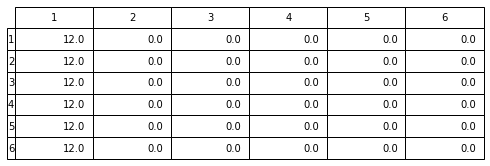

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame(np.sum(conf, axis=0))#, columns=subjects)
df.index = df.index + 1
df.columns = df.columns + 1
fig,ax = plt.subplots(figsize=((len(df.columns)+1)*1.2, (len(df)+1)*0.4))
ax.axis('off')
tbl = ax.table(cellText=df.values,
               bbox=[0,0,1,1],
               colLabels=df.columns,
               rowLabels=df.index)
plt.show() 

## 4-3.K-NN + feature engineering

In [73]:
#K-NN and feature[1:7]あり
#Leave-one-out cross-validation(データ数少なすぎ)
def conf_matrix(true, pred):
    mat = np.zeros((6,6))
    mat[int(true[0])-1][int(pred[0])-1] = 1
    return mat

def make_index(i, le):
  ind = np.ones(le, dtype=bool)
  ind[i] = False
  return ind

extract_feature = True
conf = []
le = len(ssnmf_datas)
for i in range(le):
  print(i)
  ind = make_index(i,le)
  train_x = ssnmf_datas[ind]
  train_y = labels[ind]
  test_x = ssnmf_datas[i]
  test_y = labels[i]
  print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

  if extract_feature == True:
    new_train = []
    new_test = []
    for x_ in train_x:
      res = amptitude_frequency(x_)[1:7]
      new_train.append(res)
    train_x = np.array(new_train)
    res = amptitude_frequency(test_x)[1:7]
    new_test.append(res)
    test_x = np.array(new_test)
    print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)
  #nopreproc_cutlen_feature
  model = KNeighborsClassifier(n_neighbors=11, p=1, weights="distance")
  #SEDNN_cutlen_feature[1:7]
  #model = KNeighborsClassifier(n_neighbors=11, p=2, weights="distance")
  #SSNMF_cutlen_feature[1:7]
  #model = KNeighborsClassifier(n_neighbors=1, p=2, weights="uniform")
  model.fit(train_x, train_y)
  pred_y = model.predict(test_x.reshape(1, -1))
  conf.append(conf_matrix(test_y, pred_y))

0
(71, 396242) (71,) (396242,) ()
(71, 6) (71,) (1, 6) ()
1
(71, 396242) (71,) (396242,) ()
(71, 6) (71,) (1, 6) ()
2
(71, 396242) (71,) (396242,) ()
(71, 6) (71,) (1, 6) ()
3
(71, 396242) (71,) (396242,) ()
(71, 6) (71,) (1, 6) ()
4
(71, 396242) (71,) (396242,) ()
(71, 6) (71,) (1, 6) ()
5
(71, 396242) (71,) (396242,) ()
(71, 6) (71,) (1, 6) ()
6
(71, 396242) (71,) (396242,) ()
(71, 6) (71,) (1, 6) ()
7
(71, 396242) (71,) (396242,) ()
(71, 6) (71,) (1, 6) ()
8
(71, 396242) (71,) (396242,) ()
(71, 6) (71,) (1, 6) ()
9
(71, 396242) (71,) (396242,) ()
(71, 6) (71,) (1, 6) ()
10
(71, 396242) (71,) (396242,) ()
(71, 6) (71,) (1, 6) ()
11
(71, 396242) (71,) (396242,) ()
(71, 6) (71,) (1, 6) ()
12
(71, 396242) (71,) (396242,) ()
(71, 6) (71,) (1, 6) ()
13
(71, 396242) (71,) (396242,) ()
(71, 6) (71,) (1, 6) ()
14
(71, 396242) (71,) (396242,) ()
(71, 6) (71,) (1, 6) ()
15
(71, 396242) (71,) (396242,) ()
(71, 6) (71,) (1, 6) ()
16
(71, 396242) (71,) (396242,) ()
(71, 6) (71,) (1, 6) ()
17
(71,

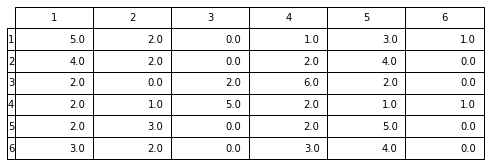

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame(np.sum(conf, axis=0))#, columns=subjects)
df.index = df.index + 1
df.columns = df.columns + 1
fig,ax = plt.subplots(figsize=((len(df.columns)+1)*1.2, (len(df)+1)*0.4))
ax.axis('off')
tbl = ax.table(cellText=df.values,
               bbox=[0,0,1,1],
               colLabels=df.columns,
               rowLabels=df.index)
plt.show() 

## 4-4.K-NN + MFCC

In [71]:
#K-NN and MFCC[:12]あり
#Leave-one-out cross-validation(データ数少なすぎ)
def conf_matrix(true, pred):
    mat = np.zeros((6,6))
    mat[int(true[0])-1][int(pred[0])-1] = 1
    return mat

def make_index(i, le):
  ind = np.ones(le, dtype=bool)
  ind[i] = False
  return ind

extract_feature = "MFCC"
conf = []
le = len(ssnmf_datas)
for i in range(le):
  print(i)
  ind = make_index(i,le)
  train_x = ssnmf_datas[ind]
  train_y = labels[ind]
  test_x = ssnmf_datas[i]
  test_y = labels[i]
  print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

  if extract_feature == "MFCC":
    new_train = []
    new_test = []
    for x_ in train_x:
      #res = librosa.feature.mfcc(x_, n_fft=len(x_),hop_length=len(x_),n_mfcc=12).reshape(-1)
      res = np.mean(librosa.feature.mfcc(x_, sr=16000, n_mfcc=12),axis=1)
      new_train.append(res)
    train_x = np.array(new_train)
    #res = librosa.feature.mfcc(test_x, n_fft=len(test_x),hop_length=len(test_x),n_mfcc=12).reshape(-1)
    res = np.mean(librosa.feature.mfcc(test_x, sr=16000, n_mfcc=12),axis=1)
    new_test.append(res)
    test_x = np.array(new_test)
    print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)
  #nopreproc_cutlen_MFCC
  model = KNeighborsClassifier(n_neighbors=3, p=1, weights="uniform")
  #SEDNN_cutlen_MFCC
  #model = KNeighborsClassifier(n_neighbors=9, p=1, weights="uniform")
  #SSNMF_cutlen_MFCC
  #model = KNeighborsClassifier(n_neighbors=7, p=1, weights="uniform")
  model.fit(train_x, train_y)
  pred_y = model.predict(test_x.reshape(1, -1))
  conf.append(conf_matrix(test_y, pred_y))

0
(71, 396242) (71,) (396242,) ()
(71, 12) (71,) (1, 12) ()
1
(71, 396242) (71,) (396242,) ()
(71, 12) (71,) (1, 12) ()
2
(71, 396242) (71,) (396242,) ()
(71, 12) (71,) (1, 12) ()
3
(71, 396242) (71,) (396242,) ()
(71, 12) (71,) (1, 12) ()
4
(71, 396242) (71,) (396242,) ()
(71, 12) (71,) (1, 12) ()
5
(71, 396242) (71,) (396242,) ()
(71, 12) (71,) (1, 12) ()
6
(71, 396242) (71,) (396242,) ()
(71, 12) (71,) (1, 12) ()
7
(71, 396242) (71,) (396242,) ()
(71, 12) (71,) (1, 12) ()
8
(71, 396242) (71,) (396242,) ()
(71, 12) (71,) (1, 12) ()
9
(71, 396242) (71,) (396242,) ()
(71, 12) (71,) (1, 12) ()
10
(71, 396242) (71,) (396242,) ()
(71, 12) (71,) (1, 12) ()
11
(71, 396242) (71,) (396242,) ()
(71, 12) (71,) (1, 12) ()
12
(71, 396242) (71,) (396242,) ()
(71, 12) (71,) (1, 12) ()
13
(71, 396242) (71,) (396242,) ()
(71, 12) (71,) (1, 12) ()
14
(71, 396242) (71,) (396242,) ()
(71, 12) (71,) (1, 12) ()
15
(71, 396242) (71,) (396242,) ()
(71, 12) (71,) (1, 12) ()
16
(71, 396242) (71,) (396242,) ()

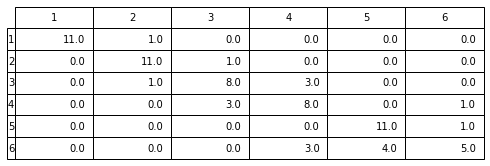

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame(np.sum(conf, axis=0))#, columns=subjects)
df.index = df.index + 1
df.columns = df.columns + 1
fig,ax = plt.subplots(figsize=((len(df.columns)+1)*1.2, (len(df)+1)*0.4))
ax.axis('off')
tbl = ax.table(cellText=df.values,
               bbox=[0,0,1,1],
               colLabels=df.columns,
               rowLabels=df.index)
plt.show() 

#5.SVMでの学習・推定
#----------------------------------------------------------------------------#

## 5-1.ハイパーパラメータ探索

In [8]:
#データリークすることになるけどとりあえずの探索
#SVMはハイパーパラメータに敏感だから，どうにか話を作らないといけない
#X_train, X_test, y_train, y_test = train_test_split(sednn_datas, labels, test_size=0.2, 
#                                                    random_state=100, stratify=labels)
from sklearn.metrics import precision_score, recall_score, f1_score

# Creating a function for displaying evaluation metrics
def model_results(model, x_test, y_test):
    
    # Evaluation:
    # Accuracy score:
    print("Accuracy:",model.score(x_test,y_test), "\n")

    # f1 score
    y_pred = model.predict(x_test)
    print(confusion_matrix(y_test,y_pred))
    print("Precision score:",precision_score(y_test, y_pred, average = 'micro'))
    print("Recall score:",recall_score(y_test, y_pred, average = 'micro'))
    print("F1 score:",f1_score(y_test, y_pred, average = "micro"), "\n")

print("extract_feature==False")
extract_feature = False
X_train = np.copy(ssnmf_datas)
y_train = np.copy(labels)
if extract_feature == True:
  new_train = []
  for x_ in X_train:
    res = amptitude_frequency(x_)
    new_train.append(res)
  X_train = np.array(new_train)
param_grid = [
    {
        'C': [0.1, 1, 10, 100, 1000],
        'kernel': ['linear']
    },
    {
        'C': [0.1, 1, 10, 100, 1000],
        'kernel': ['rbf'],
        'gamma': [0.01, 0.001, 0.0001, 'auto']
    },
    {
        'C': [0.1, 1, 10, 100, 1000],
        'kernel': ['poly'], 'degree': [2, 3, 4],
        'gamma': [0.01, 0.001, 0.0001, 'auto']
    },
    {
        'C': [0.1, 1, 10, 100, 1000],
        'kernel':['sigmoid'],
        'gamma': [0.01, 0.001, 0.0001, 'auto']
    }
]
clf = GridSearchCV(
    SVC(), # 識別器
    param_grid, # 最適化したいパラメータセット 
    cv=3 # 交差検定の回数
    )
clf.fit(X_train, y_train)
print(clf.best_params_)
print(clf.best_score_)

print("extract_feature==MFCC")
extract_feature = "MFCC"
for k in range(10,26):
  print("MFCC_dim"+str(k))
  X_train = np.copy(ssnmf_datas)
  y_train = np.copy(labels)
  new_train = []
  for x_ in X_train:
    #res = librosa.feature.mfcc(x_, n_fft=len(x_),hop_length=len(x_),n_mfcc=k).reshape(-1)
    res = np.mean(librosa.feature.mfcc(x_, sr=16000, n_mfcc=k),axis=1)
    new_train.append(res)
  X_train = np.array(new_train)
  param_grid = [
      {
          'C': [0.1, 1, 10, 100, 1000],
          'kernel': ['linear']
      },
      {
          'C': [0.1, 1, 10, 100, 1000],
          'kernel': ['rbf'],
          'gamma': [0.01, 0.001, 0.0001, 'auto']
      },
      {
          'C': [0.1, 1, 10, 100, 1000],
          'kernel': ['poly'], 'degree': [2, 3, 4],
          'gamma': [0.01, 0.001, 0.0001, 'auto']
      },
      {
          'C': [0.1, 1, 10, 100, 1000],
          'kernel':['sigmoid'],
          'gamma': [0.01, 0.001, 0.0001, 'auto']
      }
  ]
  clf = GridSearchCV(
      SVC(), # 識別器
      param_grid, # 最適化したいパラメータセット 
      cv=3 # 交差検定の回数
      )
  clf.fit(X_train, y_train)
  print(clf.best_params_)
  print(clf.best_score_)

print("extract_feature==True")
extract_feature = True
for k in range(5,31):
  print("amp_dim"+str(k))
  X_train = np.copy(ssnmf_datas)
  y_train = np.copy(labels)
  if extract_feature == True:
    new_train = []
    for x_ in X_train:
      res = amptitude_frequency(x_)[1:k]
      new_train.append(res)
    X_train = np.array(new_train)
    param_grid = [
        {
            'C': [0.1, 1, 10, 100, 1000],
            'kernel': ['linear']
        },
        {
            'C': [0.1, 1, 10, 100, 1000],
            'kernel': ['rbf'],
            'gamma': [0.01, 0.001, 0.0001, 'auto']
        },
        {
            'C': [0.1, 1, 10, 100, 1000],
            'kernel': ['poly'], 'degree': [2, 3, 4],
            'gamma': [0.01, 0.001, 0.0001, 'auto']
        },
        {
            'C': [0.1, 1, 10, 100, 1000],
            'kernel':['sigmoid'],
            'gamma': [0.01, 0.001, 0.0001, 'auto']
        }
    ]
  clf = GridSearchCV(
      SVC(), # 識別器
      param_grid, # 最適化したいパラメータセット 
      cv=3 # 交差検定の回数
      )
  clf.fit(X_train, y_train)
  print(clf.best_params_)
  print(clf.best_score_)

extract_feature==False


KeyboardInterrupt: ignored

## 5-2.SVM + no feature engineering

In [9]:
##Leave-one-out cross-validation(データ数少なすぎ)
def conf_matrix(true, pred):
    mat = np.zeros((6,6))
    mat[int(true[0])-1][int(pred[0])-1] = 1
    return mat

def make_index(i, le):
  ind = np.ones(le, dtype=bool)
  ind[i] = False
  return ind

extract_feature = False
conf = []
le = len(ssnmf_datas)
for i in range(le):
  print(i)
  ind = make_index(i,le)
  train_x = ssnmf_datas[ind]
  train_y = labels[ind]
  test_x = ssnmf_datas[i]
  test_y = labels[i]
  print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

  if extract_feature == True:
    new_train = []
    new_test = []
    for x_ in train_x:
      res = amptitude_frequency(x_)
      new_train.append(res)
    train_x = np.array(new_train)
    res = amptitude_frequency(test_x)
    new_test.append(res)
    test_x = np.array(new_test)
    print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)
  #SEDNN_cutlen_nofeature時(類似のためnopreprocも使用)
  model = SVC(C = 10, gamma = 0.01, kernel = 'rbf')
  #SSNMF_cutlen_nofeature時
  #model = SVC(C = 1,  kernel = 'linear')  
  model.fit(train_x, train_y)
  pred_y = model.predict(test_x.reshape(1, -1))
  conf.append(conf_matrix(test_y, pred_y))

0
(71, 396242) (71,) (396242,) ()
1
(71, 396242) (71,) (396242,) ()
2
(71, 396242) (71,) (396242,) ()
3
(71, 396242) (71,) (396242,) ()
4
(71, 396242) (71,) (396242,) ()
5
(71, 396242) (71,) (396242,) ()
6
(71, 396242) (71,) (396242,) ()
7
(71, 396242) (71,) (396242,) ()
8
(71, 396242) (71,) (396242,) ()
9
(71, 396242) (71,) (396242,) ()
10
(71, 396242) (71,) (396242,) ()
11
(71, 396242) (71,) (396242,) ()
12
(71, 396242) (71,) (396242,) ()
13
(71, 396242) (71,) (396242,) ()
14
(71, 396242) (71,) (396242,) ()
15
(71, 396242) (71,) (396242,) ()
16
(71, 396242) (71,) (396242,) ()
17
(71, 396242) (71,) (396242,) ()
18
(71, 396242) (71,) (396242,) ()
19
(71, 396242) (71,) (396242,) ()
20
(71, 396242) (71,) (396242,) ()
21
(71, 396242) (71,) (396242,) ()
22
(71, 396242) (71,) (396242,) ()
23
(71, 396242) (71,) (396242,) ()
24
(71, 396242) (71,) (396242,) ()
25
(71, 396242) (71,) (396242,) ()
26
(71, 396242) (71,) (396242,) ()
27
(71, 396242) (71,) (396242,) ()
28
(71, 396242) (71,) (396242,

no_preproc


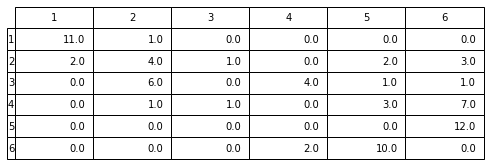

In [10]:
print("no_preproc")
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame(np.sum(conf, axis=0))#, columns=subjects)
df.index = df.index + 1
df.columns = df.columns + 1
fig,ax = plt.subplots(figsize=((len(df.columns)+1)*1.2, (len(df)+1)*0.4))
ax.axis('off')
tbl = ax.table(cellText=df.values,
               bbox=[0,0,1,1],
               colLabels=df.columns,
               rowLabels=df.index)
plt.show() 

##5-3. SVM + feature engineering

In [9]:
#特徴量算出あり
#Leave-one-out cross-validation(データ数少なすぎ)
def conf_matrix(true, pred):
    mat = np.zeros((6,6))
    mat[int(true[0])-1][int(pred[0])-1] = 1
    return mat

def make_index(i, le):
  ind = np.ones(le, dtype=bool)
  ind[i] = False
  return ind

extract_feature = True
conf = []
le = len(ssnmf_datas)
for i in range(le):
  print(i)
  ind = make_index(i,le)
  train_x = ssnmf_datas[ind]
  train_y = labels[ind]
  test_x = ssnmf_datas[i]
  test_y = labels[i]
  print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

  if extract_feature == True:
    new_train = []
    new_test = []
    for x_ in train_x:
      res = amptitude_frequency(x_)[1:7]
      new_train.append(res)
    train_x = np.array(new_train)
    res = amptitude_frequency(test_x)[1:7]
    new_test.append(res)
    test_x = np.array(new_test)
    print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)
  #SEDNNで特徴量算出あり(類似のためnopreprocも使用)
  model = SVC(C = 100, kernel = "linear")
  #SSNMFで特徴量算出あり
  #model = SVC(C = 1000, degree =2, gamma = "auto", kernel = "poly")
  model = SVC(C = 1000,  gamma = 0.01, kernel = "rbf")
  model.fit(train_x, train_y)
  pred_y = model.predict(test_x)
  conf.append(conf_matrix(test_y, pred_y))
  print(test_y, pred_y)

0
(71, 396242) (71,) (396242,) ()
(71, 6) (71,) (1, 6) ()
2 ['5']
1
(71, 396242) (71,) (396242,) ()
(71, 6) (71,) (1, 6) ()
2 ['5']
2
(71, 396242) (71,) (396242,) ()
(71, 6) (71,) (1, 6) ()
2 ['5']
3
(71, 396242) (71,) (396242,) ()
(71, 6) (71,) (1, 6) ()
2 ['5']
4
(71, 396242) (71,) (396242,) ()
(71, 6) (71,) (1, 6) ()
2 ['5']
5
(71, 396242) (71,) (396242,) ()
(71, 6) (71,) (1, 6) ()
2 ['6']
6
(71, 396242) (71,) (396242,) ()
(71, 6) (71,) (1, 6) ()
2 ['5']
7
(71, 396242) (71,) (396242,) ()
(71, 6) (71,) (1, 6) ()
2 ['1']
8
(71, 396242) (71,) (396242,) ()
(71, 6) (71,) (1, 6) ()
2 ['5']
9
(71, 396242) (71,) (396242,) ()
(71, 6) (71,) (1, 6) ()
2 ['5']
10
(71, 396242) (71,) (396242,) ()
(71, 6) (71,) (1, 6) ()
2 ['5']
11
(71, 396242) (71,) (396242,) ()
(71, 6) (71,) (1, 6) ()
2 ['5']
12
(71, 396242) (71,) (396242,) ()
(71, 6) (71,) (1, 6) ()
3 ['1']
13
(71, 396242) (71,) (396242,) ()
(71, 6) (71,) (1, 6) ()
3 ['5']
14
(71, 396242) (71,) (396242,) ()
(71, 6) (71,) (1, 6) ()
3 ['5']
15
(7

nopreproc


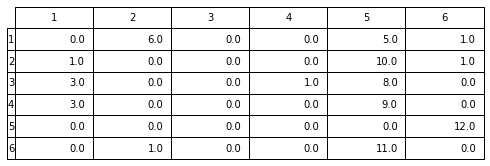

In [10]:
print("nopreproc")
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame(np.sum(conf, axis=0))#, columns=subjects)
df.index = df.index + 1
df.columns = df.columns + 1
fig,ax = plt.subplots(figsize=((len(df.columns)+1)*1.2, (len(df)+1)*0.4))
ax.axis('off')
tbl = ax.table(cellText=df.values,
               bbox=[0,0,1,1],
               colLabels=df.columns,
               rowLabels=df.index)
plt.show() 

##5-4.SVM + MFCC

In [5]:
#MFCC
#Leave-one-out cross-validation(データ数少なすぎ)
def conf_matrix(true, pred):
    mat = np.zeros((6,6))
    mat[int(true[0])-1][int(pred[0])-1] = 1
    return mat

def make_index(i, le):
  ind = np.ones(le, dtype=bool)
  ind[i] = False
  return ind

extract_feature = "MFCC"
conf = []
le = len(ssnmf_datas)
for i in range(le):
  print(i)
  ind = make_index(i,le)
  train_x = ssnmf_datas[ind]
  train_y = labels[ind]
  test_x = ssnmf_datas[i]
  test_y = labels[i]
  print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

  if extract_feature == "MFCC":
    new_train = []
    new_test = []
    for x_ in train_x:
      #res = librosa.feature.mfcc(x_, n_fft=len(x_),hop_length=len(x_),n_mfcc=12).reshape(-1)
      res = np.mean(librosa.feature.mfcc(x_, sr=16000, n_mfcc=12),axis=1)
      new_train.append(res)
    train_x = np.array(new_train)
    #res = librosa.feature.mfcc(test_x, n_fft=len(test_x),hop_length=len(test_x),n_mfcc=12).reshape(-1)
    res = np.mean(librosa.feature.mfcc(test_x, sr=16000, n_mfcc=12),axis=1)
    new_test.append(res)
    test_x = np.array(new_test)
    print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)
  #SEDNNでMFCC(類似のためnopreprocも使用)
  model = SVC(C = 0.1, kernel = "linear")
  #SSNMFでMFCC
  model = SVC(C = 0.1, degree = 3, gamma = 0.0001, kernel = "poly")
  model.fit(train_x, train_y)
  pred_y = model.predict(test_x)
  conf.append(conf_matrix(test_y, pred_y))
  print(test_y, pred_y)

0
(71, 396242) (71,) (396242,) ()
(71, 12) (71,) (1, 12) ()
2 ['2']
1
(71, 396242) (71,) (396242,) ()
(71, 12) (71,) (1, 12) ()
2 ['2']
2
(71, 396242) (71,) (396242,) ()
(71, 12) (71,) (1, 12) ()
2 ['2']
3
(71, 396242) (71,) (396242,) ()
(71, 12) (71,) (1, 12) ()
2 ['2']
4
(71, 396242) (71,) (396242,) ()
(71, 12) (71,) (1, 12) ()
2 ['2']
5
(71, 396242) (71,) (396242,) ()
(71, 12) (71,) (1, 12) ()
2 ['2']
6
(71, 396242) (71,) (396242,) ()
(71, 12) (71,) (1, 12) ()
2 ['2']
7
(71, 396242) (71,) (396242,) ()
(71, 12) (71,) (1, 12) ()
2 ['2']
8
(71, 396242) (71,) (396242,) ()
(71, 12) (71,) (1, 12) ()
2 ['2']
9
(71, 396242) (71,) (396242,) ()
(71, 12) (71,) (1, 12) ()
2 ['2']
10
(71, 396242) (71,) (396242,) ()
(71, 12) (71,) (1, 12) ()
2 ['2']
11
(71, 396242) (71,) (396242,) ()
(71, 12) (71,) (1, 12) ()
2 ['3']
12
(71, 396242) (71,) (396242,) ()
(71, 12) (71,) (1, 12) ()
3 ['4']
13
(71, 396242) (71,) (396242,) ()
(71, 12) (71,) (1, 12) ()
3 ['4']
14
(71, 396242) (71,) (396242,) ()
(71, 12) 

nopreproc


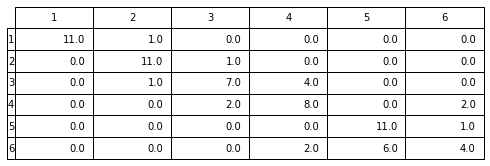

In [6]:
print("nopreproc")
#MFCC
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame(np.sum(conf, axis=0))#, columns=subjects)
df.index = df.index + 1
df.columns = df.columns + 1
fig,ax = plt.subplots(figsize=((len(df.columns)+1)*1.2, (len(df)+1)*0.4))
ax.axis('off')
tbl = ax.table(cellText=df.values,
               bbox=[0,0,1,1],
               colLabels=df.columns,
               rowLabels=df.index)
plt.show() 

#6.CNNでの学習・推論
#----------------------------------------------------------------------------#

In [0]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:            25G        756M         22G        904K        2.2G         24G
Swap:            0B          0B          0B


## 6-1. CNN用のデータ作成

In [0]:
print("CNN用のデータ作成")
from sklearn.model_selection import StratifiedKFold

# data augmentation: add white noise
def add_white_noise(x, rate=0.02):
    return x + rate*np.random.randn(len(x))

# data augmentation: shift sound in timeframe
def shift_sound(x, rate=2):
    return np.roll(x, int(len(x)//rate))

# data augmentation: stretch sound
def stretch_sound(x, rate=1.1):
    input_length = len(x)
    x = librosa.effects.time_stretch(x, rate)
    if len(x)>input_length:
        return x[:input_length]
    else:
        return np.pad(x, (0, max(0, input_length - len(x))), "constant")

# save wave data in npz, with augmentation
def save_np_data(filename, x, y, aug=None, rates=None):
    np.savez(filename, x=np_data, y=np_targets)

n_splits = 2
cnt = 0
skf = StratifiedKFold(n_splits=n_splits)
# save training dataset with white noise
N_wn = int(10)
N_ss = int(0)
N_st = int(20)
N_multi = int(0)
#for train_index, test_index in skf.split(sednn_datas, labels):
for train_index, test_index in skf.split(ssnmf_datas, labels):
  x_train = ssnmf_datas[train_index]
  y_train = labels[train_index]
  #x_train = nopreproc_data[train_index]
  x_test = ssnmf_datas[test_index]
  y_test = labels[test_index]
  #x_test = nopreproc_data[test_index]

  aug_datas = []
  aug_labels = []
  for ind, one in enumerate(x_train):
      print(ind)
      one = one / one.max()
      aug_datas.append(one)
      aug_labels.append(y_train[ind])
      for i in range(N_wn):
          rates = np.random.randint(1,300)
          aug_datas.append(add_white_noise(one, rates))
          aug_labels.append(y_train[ind])
      for i in range(N_ss):
          rates = np.random.choice(np.arange(2,51))
          aug_datas.append(shift_sound(one, rates))
          aug_labels.append(y_train[ind])
      for i in range(N_st):
          rates = np.random.choice(np.arange(50,150))/100 
          aug_datas.append(stretch_sound(one, rates))
          aug_labels.append(y_train[ind])
      for i in range(N_multi):
          #save training dataset with white noise
          rates = np.random.randint(1,100)/1000
          _ = add_white_noise(one, rates)
          # save training dataset with sound shift
          rates = np.random.choice(np.arange(2,51))
          _ = shift_sound(_, rates)
          # save training dataset with stretch
          rates = np.random.choice(np.arange(50,150))/100
          aug_datas.append(stretch_sound(_, rates))
          aug_labels.append(y_train[ind])
      """
      if ind == int((len(x_train)-1)/2):
        print("npzを書き出す処理")
        defaultname= "./aug_npys"
        trainname = "train_{}_1.npz".format(str(cnt))
        filename = os.path.join(defaultname, trainname)
        np.savez(filename, x=aug_datas, y=aug_labels)
        aug_datas = []
        aug_labels = []
      elif ind == int(len(x_train)-1):
        print("npzを書き出す処理")
        trainname = "train_{}_2.npz".format(str(cnt))
        filename = os.path.join(defaultname, trainname)
        np.savez(filename, x=aug_datas, y=aug_labels)
        """
  print("npzを書き出す処理")
  trainname = "train_{}_ssnmf.npz".format(str(cnt))
  defaultname= "./aug_npys"
  filename = os.path.join(defaultname, trainname)
  aug_datas = np.array(aug_datas, dtype=np.float32)
  aug_labels = np.array(aug_labels, dtype=np.float32)
  np.savez(filename, x=aug_datas, y=aug_labels)
  print("npzを書き出す処理")
  testname = "test_{}_ssnmf.npz".format(str(cnt))
  filename = os.path.join(defaultname, testname)
  np.savez(filename, x=x_test, y=y_test)
  print("終了")
  cnt += 1

CNN用のデータ作成
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
npzを書き出す処理
npzを書き出す処理
終了
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
npzを書き出す処理
npzを書き出す処理
終了


## 6-2.モデル構築

In [0]:
!pip install keras-adabound

CNNモデルの構築処理




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1067, 1)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 534, 32)      544         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 534, 32)      160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 534, 32)      128    

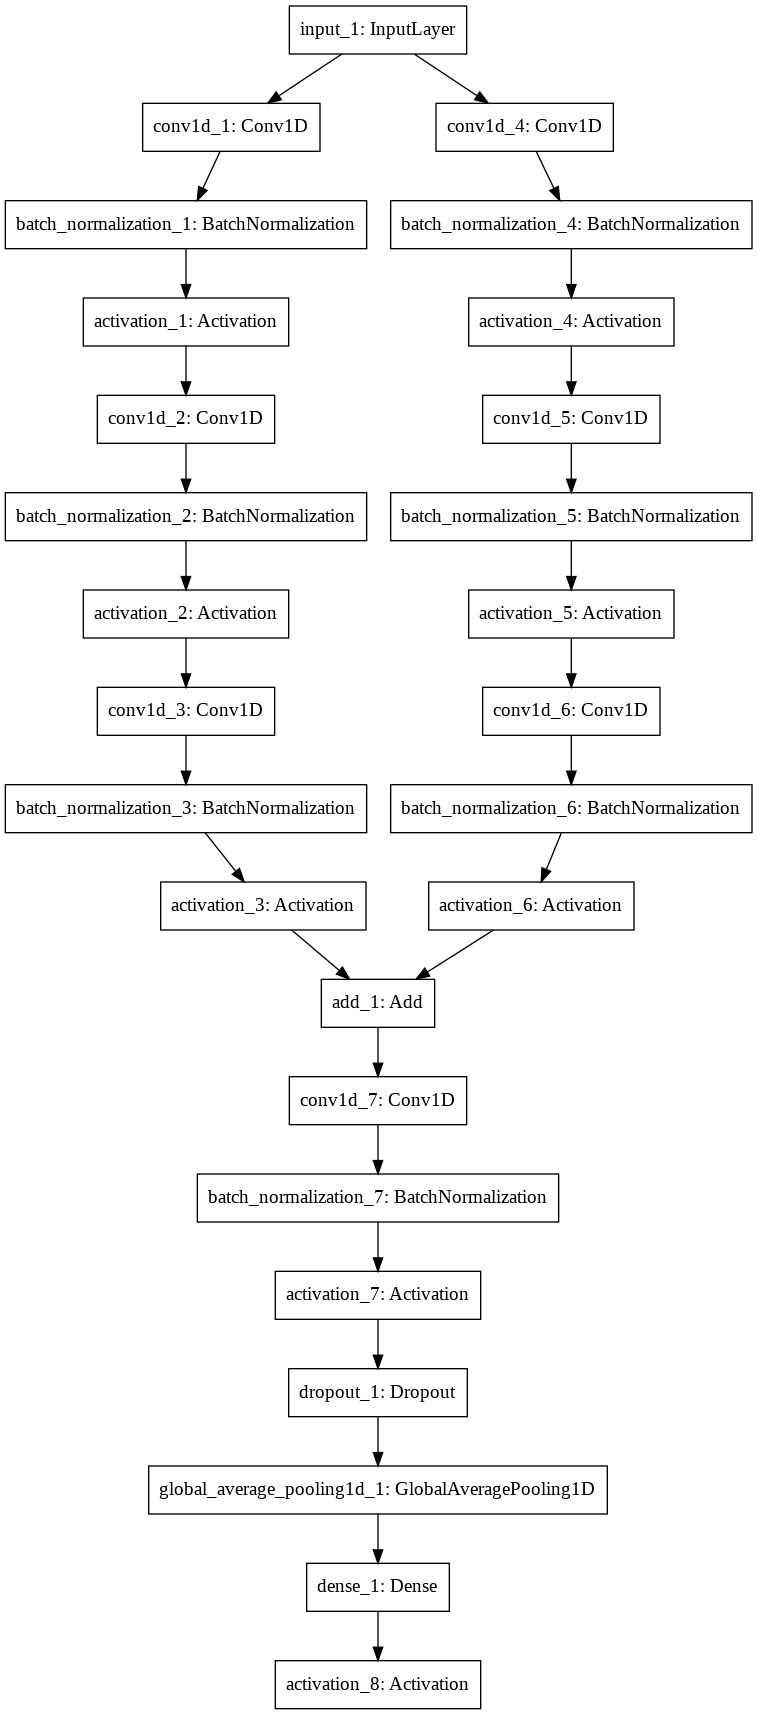

In [0]:
print("CNNモデルの構築処理")
from keras_adabound import AdaBound
#足音認識で使ったモデルを流用する
defaultname= "./aug_npys"
trainname = "train_0_ssnmf.npz"
filename = os.path.join(defaultname, trainname)
x_train = np.load(filename)["x"]

batch_size = 16
epochs = 100
classes = 6

# ## Define convolutional neural network
def cba(inputs, filters, kernel_size, strides):
    x = Conv1D(filters, kernel_size=kernel_size, strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

# define CNN
inputs = Input(shape=(len(x_train[0]),1))

#今回は時系列データを対象としているから，一方向のみのCNN
x_1 = cba(inputs, filters=32, kernel_size=16, strides=2)
#x_1 = cba(x_1, filters=32, kernel_size=(8,1), strides=(2,1))
x_1 = cba(x_1, filters=64, kernel_size=8, strides=2)
#x_1 = cba(x_1, filters=64, kernel_size=(8,1), strides=(2,1))
x_1 = cba(x_1, filters=64, kernel_size=4, strides=2)

x_2 = cba(inputs, filters=32, kernel_size=4, strides=2)
#x_2 = cba(x_2, filters=32, kernel_size=(16,1), strides=(2,1))
x_2 = cba(x_2, filters=64, kernel_size=8, strides=2)
#x_2 = cba(x_2, filters=64, kernel_size=(16,1), strides=(2,1))
x_2 = cba(x_2, filters=64, kernel_size=16, strides=2)
"""
x_3 = cba(inputs, filters=32, kernel_size=32, strides=2)
#x_3 = cba(x_3, filters=32, kernel_size=(32,1), strides=(2,1))
#x_3 = cba(x_3, filters=64, kernel_size=32, strides=2)
#x_3 = cba(x_3, filters=64, kernel_size=(32,1), strides=(2,1))

x_4 = cba(inputs, filters=32, kernel_size=64, strides=2)
#x_4 = cba(x_4, filters=32, kernel_size=(64,1), strides=(2,1))
#x_4 = cba(x_4, filters=64, kernel_size=64, strides=2)
#x_4 = cba(x_4, filters=64, kernel_size=(64,1), strides=(2,1))
"""
x = Add()([x_1, x_2])#, x_3, x_4])

x = cba(x, filters=128, kernel_size=16, strides=2)
#x = cba(x, filters=128, kernel_size=(16,1), strides=(2,1))
"""
x = Dense(1000)(inputs)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dense(500)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dense(100)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dense(classes)(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Activation("softmax")(x)

#x = Dense(100)(x)
#x = Flatten()(x)
"""
x = Dropout(0.25)(x)
x = GlobalAveragePooling1D()(x)
x = Dense(classes)(x)
x = Activation("softmax")(x)

model = Model(inputs, x)
model.summary()

# ## Optimization and callbacks
# initiate Adam optimizer
#opt = keras.optimizers.adam(lr=0.0001, decay=1e-6, amsgrad=False)

opt = AdaBound(lr=1e-04,
                final_lr=0.5,
                gamma=1e-04,
                weight_decay=0.)

# Let's train the model using Adam with amsgrad
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

print("MixupGeneratorの定義")
# between class data generator
class MixupGenerator():
    def __init__(self, x_train, y_train, batch_size=16, alpha=0.2, shuffle=True):
        self.x_train = x_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.sample_num = len(x_train)

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                x, y = self.__data_generation(batch_ids)

                yield x, y

    def __min_max(self, x, axis=None):
        min = x.min(axis=axis, keepdims=True)
        max = x.max(axis=axis, keepdims=True)
        result = (x-min)/(max-min)
        return result

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
        _, h, c = self.x_train.shape
        _, class_num = self.y_train.shape
        x1 = self.x_train[batch_ids[:self.batch_size]]
        x2 = self.x_train[batch_ids[self.batch_size:]]
        y1 = self.y_train[batch_ids[:self.batch_size]]
        y2 = self.y_train[batch_ids[self.batch_size:]]
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)
        x_l = l.reshape(self.batch_size, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        x = x1 * x_l + x2 * (1 - x_l)
        y = y1 * y_l + y2 * (1 - y_l)

        return x, y
        #return self.__min_max(x, axis=1), y

print("終了")
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png')

##6-3.学習処理

In [0]:
print("学習処理")
#n_splits交差検証でCNNモデルの検証開始
def min_max(x, axis=None):
  min = x.min(axis=axis, keepdims=True)
  max = x.max(axis=axis, keepdims=True)
  result = (x-min)/(max-min)
  return result

n_splits = 2
for i in range(n_splits):
  #Loading Dataset
  defaultname= "./aug_npys"
  trainname = "train_{}_ssnmf.npz".format(str(i))
  testname = "test_{}_ssnmf.npz".format(str(i))

  filename = os.path.join(defaultname, trainname)
  x_train = np.load(filename)["x"]
  y_train = np.load(filename)["y"]

  filename = os.path.join(defaultname, testname)
  x_test = np.load(filename)["x"]
  y_test = np.load(filename)["y"]

  print("x train:{0}\ny train:{1}\nx test:{2}\ny test:{3}".format(x_train.shape,
                                                                  y_train.shape, 
                                                                  x_test.shape, 
                                                                  y_test.shape))
  
  x_train = x_train.reshape((len(x_train), len(x_train[0]), 1))
  y_train = np.array(y_train, dtype="int64")-1
  x_test = x_test.reshape((len(x_test), len(x_test[0]), 1))
  y_test = np.array(y_test, dtype="int64")-1
  print(x_train.shape, x_test.shape)
  
  # redefine target data into one hot vector
  y_train = keras.utils.to_categorical(y_train, classes)
  y_test = keras.utils.to_categorical(y_test, classes)
  
  default_dir = "./cnn_models_ssnmf"
  model_dir = os.path.join(default_dir, str(i))
  if not os.path.exists(model_dir):
      os.makedirs(model_dir)
  # early stopping and model checkpoint# early  
  es_cb = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
  chkpt = os.path.join(model_dir, '{epoch:02d}_{val_loss:.4f}_{val_acc:.4f}.hdf5')
  cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
  batch_size=16
  epochs=100
  initial_epoch=0
  training_generator = MixupGenerator(x_train, y_train, batch_size=16)()
  #if i == 0:
  #  initial_epoch=27
  #  model.load_weights("./cnn_models/0/27_3.8693_0.1667.hdf5")
  
  history = model.fit(x_train,y_train,
                  validation_data=(x_test, y_test),
                  epochs=epochs+initial_epoch, 
                  verbose=1,
                  shuffle=True,
                  initial_epoch=initial_epoch,
                  callbacks=[cp_cb])#, es_cb])
  """
  history = model.fit_generator(generator=training_generator,
                  steps_per_epoch=x_train.shape[0] // batch_size,
                  validation_data=(x_test, y_test),
                  epochs=epochs+initial_epoch, 
                  verbose=1,
                  shuffle=True,
                  initial_epoch=initial_epoch,
                  callbacks=[cp_cb])#, es_cb])
"""
  
  #default_his_dir = "./cnn_model/history"
  default_his_dir = "./cnn_models_ssnmf/"
  model_his_dir = os.path.join(default_his_dir, str(i))
  if not os.path.exists(model_his_dir):
      os.makedirs(model_his_dir)
  np.save(model_his_dir, history)

print("終了")

学習処理
x train:(1116, 1067)
y train:(1116,)
x test:(36, 1067)
y test:(36,)
(1116, 1067, 1) (36, 1067, 1)
Epoch 1/100
69/69 [==============================] - 1s 15ms/step - loss: 1.2412 - acc: 0.5824 - val_loss: 2.7087 - val_acc: 0.1667

Epoch 00001: val_loss improved from inf to 2.70866, saving model to ./cnn_models_ssnmf/0/01_2.7087_0.1667.hdf5
Epoch 2/100
69/69 [==============================] - 1s 16ms/step - loss: 1.1171 - acc: 0.6332 - val_loss: 3.0329 - val_acc: 0.1944

Epoch 00002: val_loss did not improve from 2.70866
Epoch 3/100
69/69 [==============================] - 1s 16ms/step - loss: 1.1305 - acc: 0.6277 - val_loss: 3.1450 - val_acc: 0.0278

Epoch 00003: val_loss did not improve from 2.70866
Epoch 4/100
69/69 [==============================] - 1s 16ms/step - loss: 1.1166 - acc: 0.6313 - val_loss: 2.3139 - val_acc: 0.1667

Epoch 00004: val_loss improved from 2.70866 to 2.31394, saving model to ./cnn_models_ssnmf/0/04_2.3139_0.1667.hdf5
Epoch 5/100
69/69 [==================

KeyboardInterrupt: ignored

##6-4.optunaで最適なパラメータ・アーキテクチャ探索

In [0]:
!pip install optuna

###6-4-1.CNNアーキテクチャandハイパーパラメータの最適化

In [0]:
#CNNアーキテクチャおよびハイパーパラメータの最適化
import optuna
from sklearn.metrics import mean_absolute_error as r2_score
from sklearn.model_selection import ShuffleSplit
from keras_adabound import AdaBound

class DNNCV():
    def __init__(self, n_trials=100):
        self.n_trials = n_trials

    def _cba(self, inputs, filters, kernel_size, strides, activation):
      x = Conv1D(filters, kernel_size=kernel_size, strides=strides, padding='same')(inputs)
      x = BatchNormalization()(x)
      x = Activation(activation)(x)
      return x

    def create_model(self, split, layer, filters, kernel_size, strides, lr, final_lr, gamma, dropout_rate, activation, optimizer):
        # define CNN
        """
        x_i = []
        for i in range(split):
          x = Input(shape=(len(self.X[0]),1))
          for j in range(layer):
              filters_ = filters * (1+j)
              kernel_size_ = kernel_size * (1+j)
              x = self._cba(x, filters=filters_, kernel_size=kernel_size_, strides=strides, activation=activation)
          x_i.append(x)
        """
        inputs = Input(shape=(len(self.X[0]),1))
        if split == 1:
          x = self._cba(inputs, filters=filters, kernel_size=kernel_size, strides=strides, activation=activation)
          for j in range(1,layer):
                filters_ = filters * (1+j)
                kernel_size_ = kernel_size * (1+j)
                x = self._cba(x, filters=filters_, kernel_size=kernel_size_, strides=strides, activation=activation)
        elif split == 2:
          x1 = self._cba(inputs, filters=filters, kernel_size=kernel_size, strides=strides, activation=activation)  
          for j in range(1,layer):
                filters_ = filters * (1+j)
                kernel_size_ = kernel_size * (1+j)
                x1 = self._cba(x1, filters=filters_, kernel_size=kernel_size_, strides=strides, activation=activation)
          x2 = self._cba(inputs, filters=filters, kernel_size=kernel_size, strides=strides, activation=activation)         
          for j in range(1,layer):
                filters_ = filters * (1+j)
                kernel_size_ = kernel_size * (1+j)
                x2 = self._cba(x2, filters=filters_, kernel_size=kernel_size_, strides=strides, activation=activation)    
          x = Add()([x1, x2])
        elif split == 3:
          x1 = self._cba(inputs, filters=filters, kernel_size=kernel_size, strides=strides, activation=activation)
          for j in range(1,layer):
                filters_ = filters * (1+j)
                kernel_size_ = kernel_size * (1+j)
                x1 = self._cba(x1, filters=filters_, kernel_size=kernel_size_, strides=strides, activation=activation)        
          x2 = self._cba(inputs, filters=filters, kernel_size=kernel_size, strides=strides, activation=activation)
          for j in range(1,layer):
                filters_ = filters * (1+j)
                kernel_size_ = kernel_size * (1+j)
                x2 = self._cba(x2, filters=filters_, kernel_size=kernel_size_, strides=strides, activation=activation)   
          x3 = self._cba(inputs, filters=filters, kernel_size=kernel_size, strides=strides, activation=activation)
          for j in range(1,layer):
                filters_ = filters * (1+j)
                kernel_size_ = kernel_size * (1+j)
                x3 = self._cba(x3, filters=filters_, kernel_size=kernel_size_, strides=strides, activation=activation) 
          x = Add()([x1, x2, x3])
        elif split == 4:
          x1 = self._cba(inputs, filters=filters, kernel_size=kernel_size, strides=strides, activation=activation)
          for j in range(1,layer):
                filters_ = filters * (1+j)
                kernel_size_ = kernel_size * (1+j)
                x1 = self._cba(x1, filters=filters_, kernel_size=kernel_size_, strides=strides, activation=activation)        
          x2 = self._cba(inputs, filters=filters, kernel_size=kernel_size, strides=strides, activation=activation)
          for j in range(1,layer):
                filters_ = filters * (1+j)
                kernel_size_ = kernel_size * (1+j)
                x2 = self._cba(x2, filters=filters_, kernel_size=kernel_size_, strides=strides, activation=activation)   
          x3 = self._cba(inputs, filters=filters, kernel_size=kernel_size, strides=strides, activation=activation)
          for j in range(1,layer):
                filters_ = filters * (1+j)
                kernel_size_ = kernel_size * (1+j)
                x3 = self._cba(x3, filters=filters_, kernel_size=kernel_size_, strides=strides, activation=activation) 
          x4 = self._cba(inputs, filters=filters, kernel_size=kernel_size, strides=strides, activation=activation)
          for j in range(1,layer):
                filters_ = filters * (1+j)
                kernel_size_ = kernel_size * (1+j)
                x4 = self._cba(x4, filters=filters_, kernel_size=kernel_size_, strides=strides, activation=activation) 
          x = Add()([x1, x2, x3, x4])
        else :
            print(split)
            raise ValueError("What!")  

        x = self._cba(x, filters=64, kernel_size=16, strides=2, activation=activation)
        #x = cba(x, filters=128, kernel_size=(16,1), strides=(2,1))

        x = Dropout(dropout_rate)(x)
        x = GlobalAveragePooling1D()(x)
        x = Dense(self.classes)(x)
        x = Activation("softmax")(x)

        model = Model(inputs, x)

        if optimizer == "adabound":
            optimizer = AdaBound(lr=lr,
                          final_lr=final_lr,
                         gamma=gamma,
                          weight_decay=0.)

        # Let's train the model using Adam with amsgrad
        model.compile(loss='categorical_crossentropy',
                    optimizer=optimizer,
                    metrics=['accuracy'])
        return model

    def __call__(self, trial):
        split = (int(trial.suggest_discrete_uniform('split', 1, 4, 1)))
        layer = (int(trial.suggest_discrete_uniform('layer', 1, 5, 1)))
        filters = (int(trial.suggest_discrete_uniform('filters', 2, 64, 2)))
        kernel_size = (int(trial.suggest_discrete_uniform('kernel_size', 4, 32, 2))) 
        strides = (int(trial.suggest_discrete_uniform('strides', 2, 16, 2)))
        lr = trial.suggest_discrete_uniform('lr', 1e-05, 1e-03, 1e-05)
        final_lr = trial.suggest_discrete_uniform('final_lr', 0.01, 1, 0.01)
        gamma = trial.suggest_discrete_uniform('gamma', 1e-05, 1e-03, 1e-05)
        dropout_rate = trial.suggest_uniform('dropout_rate', 0, 0.5) # ドロップアウト率
        activation = trial.suggest_categorical('activation', ['relu', 'sigmoid']) # 活性化関数
        optimizer = trial.suggest_categorical('optimizer', ["adabound"]) # 最適化アルゴリズム
        
        #fpath = './weights/weights.{epoch:02d}-{loss:.2f}-{val_loss:.2f}.hdf5'
        #cp_cb = ModelCheckpoint(filepath = fpath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
        es_cb = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
        model = self.create_model(split, layer, filters, kernel_size, strides, lr, final_lr, gamma, dropout_rate, activation, optimizer)
        """
        history = model.fit(self.X, self.y, 
                        verbose=1,
                        epochs=self.epochs,
                        callbacks=[es_cb],#, cp_cb],
                        validation_data=(self.X_av, self.y_av),
                        batch_size=self.batch_size)
        """
        training_generator = MixupGenerator(self.X, self.y, batch_size=self.batch_size)()
        history = model.fit_generator(generator=training_generator,
                  steps_per_epoch=self.X.shape[0] // self.batch_size,
                  validation_data=(self.X_av, self.y_av),
                  verbose=1,
                  shuffle=True,
                  epochs=self.epochs,
                  callbacks=[es_cb])
        #score = model.evaluate(self.X_av, self.y_av, verbose=0)[1] #0ならloss
        score = np.mean(history.history['val_acc'])
        return score
    
    def fit(self, X, y, X_av, y_av):
        self.X = X
        self.y = y
        self.X_av = X_av
        self.y_av = y_av

        self.batch_size = 16
        self.epochs = 100
        self.classes = 6

        study = optuna.create_study(direction='maximize')
        study.optimize(self, n_trials=self.n_trials)
        self.best_trial = study.best_trial

        print()
        print("Best score:", round(self.best_trial.value, 2))
        print("Best params:", self.best_trial.params)
        print()

        #ハイパーパラメータの出力と同時に呼び出せるように格納
        print('Params: ')
        param_dnn = {}
        for key, value in self.best_trial.params.items():
            print('{}:{}'.format(key, value))
            param_dnn[key] = value
        
        return param_dnn

for i in range(2):
    dnn = DNNCV(n_trials=100)
    defaultname= "./aug_npys"
    trainname = "train_{}_ssnmf.npz".format(str(i))
    testname = "test_{}_ssnmf.npz".format(str(i))

    filename = os.path.join(defaultname, trainname)
    x_train = np.load(filename)["x"]
    y_train = np.load(filename)["y"]

    filename = os.path.join(defaultname, testname)
    x_test = np.load(filename)["x"]
    y_test = np.load(filename)["y"]

    classes = 6
    x_train = x_train.reshape((len(x_train), len(x_train[0]), 1))
    y_train = np.array(y_train, dtype="int64")-1
    x_test = x_test.reshape((len(x_test), len(x_test[0]), 1))
    y_test = np.array(y_test, dtype="int64")-1
    
    y_train = keras.utils.to_categorical(y_train, classes)
    y_test = keras.utils.to_categorical(y_test, classes)

    params = dnn.fit(x_train, y_train, x_test, y_test)
    print(params)
#パラメータチューニングは効果なし

Using TensorFlow backend.


NameError: ignored

###6-4-2.DNNアーキテクチャandデータ水増し手法の最適化

In [0]:
#データの水増しに対する最適化
import optuna
from sklearn.model_selection import StratifiedKFold
from keras_adabound import AdaBound

class DNNCV():
    def __init__(self, n_trials=100):
        self.n_trials = n_trials

    def cba(self, inputs, filters, kernel_size, strides):
      x = Conv1D(filters, kernel_size=kernel_size, strides=strides, padding='same')(inputs)
      x = BatchNormalization()(x)
      x = Activation("relu")(x)
      return x

    # data augmentation: add white noise
    def add_white_noise(self, x, rate=0.02):
        return x + rate*np.random.randn(len(x))

    # data augmentation: shift sound in timeframe
    def shift_sound(self, x, rate=2):
        return np.roll(x, int(len(x)//rate))

    # data augmentation: stretch sound
    def stretch_sound(self, x, rate=1.1):
        input_length = len(x)
        x = librosa.effects.time_stretch(x, rate)
        if len(x)>input_length:
            return x[:input_length]
        else:
            return np.pad(x, (0, max(0, input_length - len(x))), "constant")

    def create_dataset(self, N_wn, N_ss, N_st, N_multi):
        aug_datas = []
        aug_labels = []
        for ind, one in enumerate(self.X):
            one = one / one.max()
            aug_datas.append(one)
            aug_labels.append(self.y[ind])
            for i in range(N_wn):
                rates = np.random.randint(1,300) / 500
                aug_datas.append(self.add_white_noise(one, rates))
                aug_labels.append(self.y[ind])
            for i in range(N_ss):
                rates = np.random.choice(np.arange(2,51))
                aug_datas.append(self.shift_sound(one, rates))
                aug_labels.append(self.y[ind])
            for i in range(N_st):
                rates = np.random.choice(np.arange(50,150))/100 
                aug_datas.append(self.stretch_sound(one, rates))
                aug_labels.append(self.y[ind])
            for i in range(N_multi):
                #save training dataset with white noise
                rates = np.random.randint(1,100)/1000
                _ = self.add_white_noise(one, rates)
                # save training dataset with sound shift
                rates = np.random.choice(np.arange(2,51))
                _ = self.shift_sound(_, rates)
                # save training dataset with stretch
                rates = np.random.choice(np.arange(50,150))/100
                aug_datas.append(self.stretch_sound(_, rates))
                aug_labels.append(self.y[ind])

        aug_datas = np.array(aug_datas)
        x_train = aug_datas.reshape((len(aug_datas), len(aug_datas[0]), 1))
        y_train = np.array(aug_labels, dtype="int64")-1

        return x_train, y_train

    def create_model(self, layer, neuron, dropout):
        # define CNN
        inputs = Input(shape=(len(self.X[0]),1))
        """
        #今回は時系列データを対象としているから，一方向のみのCNN
        x_1 = self.cba(inputs, filters=32, kernel_size=16, strides=2)
        #x_1 = cba(x_1, filters=32, kernel_size=(8,1), strides=(2,1))
        x_1 = self.cba(x_1, filters=64, kernel_size=8, strides=2)
        #x_1 = cba(x_1, filters=64, kernel_size=(8,1), strides=(2,1))
        x_1 = self.cba(x_1, filters=64, kernel_size=4, strides=2)

        x_2 = self.cba(inputs, filters=32, kernel_size=4, strides=2)
        #x_2 = cba(x_2, filters=32, kernel_size=(16,1), strides=(2,1))
        x_2 = self.cba(x_2, filters=64, kernel_size=8, strides=2)
        #x_2 = cba(x_2, filters=64, kernel_size=(16,1), strides=(2,1))
        x_2 = self.cba(x_2, filters=64, kernel_size=16, strides=2)

        x = Add()([x_1, x_2])#, x_3, x_4])

        x = self.cba(x, filters=128, kernel_size=16, strides=2)

        x = Dropout(0.25)(x)
        x = GlobalAveragePooling1D()(x)
        x = Dense(self.classes)(x)
        x = Activation("softmax")(x)
        """
        x = Flatten()(inputs)
        for i in range(layer):
          x = Dense(int(neuron / int(2**i)))(x)
          x = Activation("relu")(x)
          x = Dropout(dropout)(x)
        """
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = Dropout(0.25)(x)
        x = Dense(64)(x)
        x = Activation("relu")(x)
        x = Dropout(0.25)(x)
        """
        x = Dense(self.classes)(x)
        x = Activation("softmax")(x)
        model = Model(inputs, x)
        #model.summary()

        # ## Optimization and callbacks
        # initiate Adam optimizer
        #opt = keras.optimizers.adam(lr=0.0001, decay=1e-6, amsgrad=False)

        opt = AdaBound(lr=1e-04,
                        final_lr=0.5,
                        gamma=1e-04,
                        weight_decay=0.)

        # Let's train the model using Adam with amsgrad
        model.compile(loss='categorical_crossentropy',
                      optimizer=opt,
                      metrics=['accuracy'])
        return model

    def __call__(self, trial):
        N_wn = (int(trial.suggest_discrete_uniform('N_wn', 0, 150, 1)))
        N_ss = (int(trial.suggest_discrete_uniform('N_ss', 0, 150, 1))) 
        N_st = (int(trial.suggest_discrete_uniform('N_st', 0, 150, 1)))
        N_multi = (int(trial.suggest_discrete_uniform('N_multi', 0, 150, 1)))
        dropout = (int(trial.suggest_discrete_uniform('dropout', 0, 0.5, 0.05)))
        layer = (int(trial.suggest_discrete_uniform("layer", 1, 4, 1)))
        neuron = int(trial.suggest_categorical('neuron', [128, 256, 512, 1024, 2048]))

        x_train, y_train = self.create_dataset(N_wn, N_ss, N_st, N_multi)
        x_av = self.X_av.reshape((len(self.X_av), len(self.X_av[0]), 1))
        y_av = np.array(self.y_av, dtype="int64")-1
        y_train = keras.utils.to_categorical(y_train, self.classes)
        y_av = keras.utils.to_categorical(y_av, self.classes)

        #fpath = './weights/weights.{epoch:02d}-{loss:.2f}-{val_loss:.2f}.hdf5'
        #cp_cb = ModelCheckpoint(filepath = fpath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
        es_cb = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
        model = self.create_model(layer, neuron, dropout)
        """
        history = model.fit(self.X, self.y, 
                        verbose=1,
                        epochs=self.epochs,
                        callbacks=[es_cb],#, cp_cb],
                        validation_data=(self.X_av, self.y_av),
                        batch_size=self.batch_size)
        """
        training_generator = MixupGenerator(x_train, y_train, batch_size=self.batch_size)()
        history = model.fit_generator(generator=training_generator,
                  steps_per_epoch=x_train.shape[0] // self.batch_size,
                  validation_data=(x_av, y_av),
                  verbose=1,
                  shuffle=True,
                  epochs=self.epochs,
                  callbacks=[es_cb])
        #score = model.evaluate(self.X_av, self.y_av, verbose=0)[0] #0ならloss
        score = np.min(history.history['val_loss'])
        return score
    
    def fit(self, X, y, X_av, y_av):
        self.X = X
        self.y = y
        self.X_av = X_av
        self.y_av = y_av

        self.batch_size = 16
        self.epochs = 100
        self.classes = 6

        #study = optuna.create_study(direction='maximize')
        study = optuna.create_study(direction='minimize')
        study.optimize(self, n_trials=self.n_trials)
        self.best_trial = study.best_trial

        print()
        print("Best score:", round(self.best_trial.value, 2))
        print("Best params:", self.best_trial.params)
        print()

        #ハイパーパラメータの出力と同時に呼び出せるように格納
        print('Params: ')
        param_dnn = {}
        for key, value in self.best_trial.params.items():
            print('{}:{}'.format(key, value))
            param_dnn[key] = value
        
        return param_dnn

skf = StratifiedKFold(n_splits=2)
k = 0
#for train_index, test_index in skf.split(sednn_datas, labels):
for train_index, test_index in skf.split(ssnmf_datas, labels):
  x_train = ssnmf_datas[train_index]
  y_train = labels[train_index]
  #x_train = nopreproc_data[train_index]
  x_test = ssnmf_datas[test_index]
  y_test = labels[test_index]
  #x_test = nopreproc_data[test_index]
  dnn = DNNCV(n_trials=150)
  params = dnn.fit(x_train, y_train, x_test, y_test)
  print(params)
  if k ==0:
    break
#パラメータチューニングは効果なし

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/100





747/747 [==============================] - 6s 8ms/step - loss: 0.8208 - acc: 0.7802 - val_loss: 7.2156 - val_acc: 0.5278
Epoch 2/100
747/747 [==============================] - 4s 6ms/step - loss: 0.5158 - acc: 0.9017 - val_loss: 8.5068 - val_acc: 0.4722
Epoch 3/100
747/747 [==============================] - 4s 6ms/step - loss: 0.4409 - acc: 0.9383 - val_loss: 7.9354 - val_acc: 0.5000
Epoch 4/100
747/747 [==============================] - 4s 6ms/step - loss: 0.3992 - acc: 0.9514 - val_loss: 7.3200 - val_acc: 0.5278
Epoch 5/100
747/747 [==============================] - 4s 6ms/step - loss: 0.3718 - acc: 0.9588 - val_loss: 7.1780 - val_acc: 0.5556
Epoch 6/100
747/747 [==============================] - 4s 6ms/step - loss: 0.3556 - acc: 0.9644 - val_loss: 7.6870 - val_acc: 0.5000
Epoch 7/100
747/747 [==============================] - 4s 6ms/step - loss: 0.3508 - acc: 0.9646 - va

[I 2020-01-05 16:39:19,473] Finished trial#0 resulted in value: 6.268246544731988. Current best value is 6.268246544731988 with parameters: {'N_wn': 35.0, 'N_ss': 82.0, 'N_st': 121.0, 'N_multi': 93.0, 'dropout': 0.5, 'layer': 3.0, 'neuron': 512}.


Epoch 1/100
517/517 [==============================] - 3s 6ms/step - loss: 0.8893 - acc: 0.7670 - val_loss: 9.1245 - val_acc: 0.4167
Epoch 2/100
517/517 [==============================] - 3s 5ms/step - loss: 0.5630 - acc: 0.8860 - val_loss: 8.4619 - val_acc: 0.4444
Epoch 3/100
517/517 [==============================] - 3s 5ms/step - loss: 0.4701 - acc: 0.9266 - val_loss: 8.5068 - val_acc: 0.4722
Epoch 4/100
517/517 [==============================] - 3s 5ms/step - loss: 0.4224 - acc: 0.9463 - val_loss: 8.1494 - val_acc: 0.4722
Epoch 5/100
517/517 [==============================] - 3s 5ms/step - loss: 0.3904 - acc: 0.9585 - val_loss: 8.0657 - val_acc: 0.5000
Epoch 6/100
517/517 [==============================] - 3s 5ms/step - loss: 0.3817 - acc: 0.9623 - val_loss: 7.6404 - val_acc: 0.5000
Epoch 7/100
517/517 [==============================] - 3s 5ms/step - loss: 0.3586 - acc: 0.9672 - val_loss: 7.7490 - val_acc: 0.5000
Epoch 8/100
517/517 [==============================] - 3s 5ms/step - 

[I 2020-01-05 16:40:11,094] Finished trial#1 resulted in value: 7.421230528089735. Current best value is 6.268246544731988 with parameters: {'N_wn': 35.0, 'N_ss': 82.0, 'N_st': 121.0, 'N_multi': 93.0, 'dropout': 0.5, 'layer': 3.0, 'neuron': 512}.


Epoch 1/100
990/990 [==============================] - 6s 6ms/step - loss: 1.0298 - acc: 0.6788 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/100
990/990 [==============================] - 6s 6ms/step - loss: 0.5447 - acc: 0.8890 - val_loss: 8.5068 - val_acc: 0.4722
Epoch 3/100
990/990 [==============================] - 6s 6ms/step - loss: 0.4585 - acc: 0.9242 - val_loss: 8.5095 - val_acc: 0.4722
Epoch 4/100
990/990 [==============================] - 6s 6ms/step - loss: 0.4187 - acc: 0.9426 - val_loss: 8.3048 - val_acc: 0.4722
Epoch 5/100
990/990 [==============================] - 6s 6ms/step - loss: 0.3958 - acc: 0.9486 - val_loss: 8.7385 - val_acc: 0.4167
Epoch 6/100
990/990 [==============================] - 6s 6ms/step - loss: 0.3828 - acc: 0.9540 - val_loss: 8.5409 - val_acc: 0.4444
Epoch 00006: early stopping


[I 2020-01-05 16:41:08,903] Finished trial#2 resulted in value: 8.05904769897461. Current best value is 6.268246544731988 with parameters: {'N_wn': 35.0, 'N_ss': 82.0, 'N_st': 121.0, 'N_multi': 93.0, 'dropout': 0.5, 'layer': 3.0, 'neuron': 512}.


Epoch 1/100
540/540 [==============================] - 3s 6ms/step - loss: 1.0308 - acc: 0.7397 - val_loss: 7.3687 - val_acc: 0.5278
Epoch 2/100
540/540 [==============================] - 3s 5ms/step - loss: 0.6248 - acc: 0.8608 - val_loss: 8.4540 - val_acc: 0.4722
Epoch 3/100
540/540 [==============================] - 3s 5ms/step - loss: 0.5326 - acc: 0.8931 - val_loss: 8.3036 - val_acc: 0.4444
Epoch 4/100
540/540 [==============================] - 3s 5ms/step - loss: 0.4777 - acc: 0.9128 - val_loss: 8.5329 - val_acc: 0.4444
Epoch 5/100
540/540 [==============================] - 3s 5ms/step - loss: 0.4395 - acc: 0.9326 - val_loss: 8.5162 - val_acc: 0.4722
Epoch 6/100
540/540 [==============================] - 2s 5ms/step - loss: 0.4135 - acc: 0.9425 - val_loss: 8.8066 - val_acc: 0.4444
Epoch 00006: early stopping


[I 2020-01-05 16:41:41,472] Finished trial#3 resulted in value: 7.368667178683811. Current best value is 6.268246544731988 with parameters: {'N_wn': 35.0, 'N_ss': 82.0, 'N_st': 121.0, 'N_multi': 93.0, 'dropout': 0.5, 'layer': 3.0, 'neuron': 512}.


Epoch 1/100
645/645 [==============================] - 4s 6ms/step - loss: 0.8707 - acc: 0.7716 - val_loss: 7.5298 - val_acc: 0.5000
Epoch 2/100
645/645 [==============================] - 3s 5ms/step - loss: 0.5412 - acc: 0.8975 - val_loss: 8.3469 - val_acc: 0.4722
Epoch 3/100
645/645 [==============================] - 3s 5ms/step - loss: 0.4541 - acc: 0.9388 - val_loss: 6.8367 - val_acc: 0.5556
Epoch 4/100
645/645 [==============================] - 3s 5ms/step - loss: 0.4019 - acc: 0.9581 - val_loss: 8.1689 - val_acc: 0.4444
Epoch 5/100
645/645 [==============================] - 3s 5ms/step - loss: 0.3704 - acc: 0.9627 - val_loss: 7.6198 - val_acc: 0.5278
Epoch 6/100
645/645 [==============================] - 3s 5ms/step - loss: 0.3637 - acc: 0.9653 - val_loss: 7.8283 - val_acc: 0.4722
Epoch 7/100
645/645 [==============================] - 3s 5ms/step - loss: 0.3500 - acc: 0.9694 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 8/100
645/645 [==============================] - 3s 5ms/step - 

[I 2020-01-05 16:42:21,087] Finished trial#4 resulted in value: 6.836662292480469. Current best value is 6.268246544731988 with parameters: {'N_wn': 35.0, 'N_ss': 82.0, 'N_st': 121.0, 'N_multi': 93.0, 'dropout': 0.5, 'layer': 3.0, 'neuron': 512}.


Epoch 1/100
704/704 [==============================] - 4s 6ms/step - loss: 0.9637 - acc: 0.7402 - val_loss: 7.3688 - val_acc: 0.4722
Epoch 2/100
704/704 [==============================] - 4s 5ms/step - loss: 0.5657 - acc: 0.8785 - val_loss: 8.2233 - val_acc: 0.4722
Epoch 3/100
704/704 [==============================] - 4s 5ms/step - loss: 0.4769 - acc: 0.9163 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 4/100
704/704 [==============================] - 4s 5ms/step - loss: 0.4450 - acc: 0.9311 - val_loss: 8.3060 - val_acc: 0.4722
Epoch 5/100
704/704 [==============================] - 4s 5ms/step - loss: 0.4133 - acc: 0.9468 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 6/100
704/704 [==============================] - 4s 5ms/step - loss: 0.3884 - acc: 0.9545 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 00006: early stopping


[I 2020-01-05 16:43:03,720] Finished trial#5 resulted in value: 7.368772718641493. Current best value is 6.268246544731988 with parameters: {'N_wn': 35.0, 'N_ss': 82.0, 'N_st': 121.0, 'N_multi': 93.0, 'dropout': 0.5, 'layer': 3.0, 'neuron': 512}.


Epoch 1/100
742/742 [==============================] - 6s 8ms/step - loss: 0.6925 - acc: 0.8253 - val_loss: 8.1510 - val_acc: 0.4444
Epoch 2/100
742/742 [==============================] - 5s 7ms/step - loss: 0.4586 - acc: 0.9250 - val_loss: 8.0298 - val_acc: 0.5000
Epoch 3/100
742/742 [==============================] - 5s 7ms/step - loss: 0.4134 - acc: 0.9474 - val_loss: 7.8712 - val_acc: 0.5000
Epoch 4/100
742/742 [==============================] - 5s 7ms/step - loss: 0.3788 - acc: 0.9570 - val_loss: 7.5915 - val_acc: 0.5278
Epoch 5/100
742/742 [==============================] - 5s 7ms/step - loss: 0.3684 - acc: 0.9598 - val_loss: 7.2246 - val_acc: 0.5278
Epoch 6/100
742/742 [==============================] - 5s 7ms/step - loss: 0.3480 - acc: 0.9664 - val_loss: 7.4549 - val_acc: 0.5278
Epoch 7/100
742/742 [==============================] - 5s 7ms/step - loss: 0.3422 - acc: 0.9662 - val_loss: 7.1675 - val_acc: 0.5556
Epoch 8/100
742/742 [==============================] - 5s 7ms/step - 

[I 2020-01-05 16:44:49,643] Finished trial#6 resulted in value: 6.716297891404894. Current best value is 6.268246544731988 with parameters: {'N_wn': 35.0, 'N_ss': 82.0, 'N_st': 121.0, 'N_multi': 93.0, 'dropout': 0.5, 'layer': 3.0, 'neuron': 512}.


Epoch 1/100
447/447 [==============================] - 3s 7ms/step - loss: 1.3273 - acc: 0.5803 - val_loss: 7.5901 - val_acc: 0.4722
Epoch 2/100
447/447 [==============================] - 2s 5ms/step - loss: 0.9156 - acc: 0.7534 - val_loss: 8.3957 - val_acc: 0.4722
Epoch 3/100
447/447 [==============================] - 2s 5ms/step - loss: 0.6977 - acc: 0.8343 - val_loss: 8.0591 - val_acc: 0.5000
Epoch 4/100
447/447 [==============================] - 2s 5ms/step - loss: 0.5936 - acc: 0.8746 - val_loss: 8.0993 - val_acc: 0.4722
Epoch 5/100
447/447 [==============================] - 2s 5ms/step - loss: 0.5207 - acc: 0.9176 - val_loss: 8.1462 - val_acc: 0.4722
Epoch 6/100
447/447 [==============================] - 2s 5ms/step - loss: 0.4826 - acc: 0.9279 - val_loss: 8.5068 - val_acc: 0.4722
Epoch 00006: early stopping


[I 2020-01-05 16:45:09,960] Finished trial#7 resulted in value: 7.590097215440538. Current best value is 6.268246544731988 with parameters: {'N_wn': 35.0, 'N_ss': 82.0, 'N_st': 121.0, 'N_multi': 93.0, 'dropout': 0.5, 'layer': 3.0, 'neuron': 512}.


Epoch 1/100
825/825 [==============================] - 5s 6ms/step - loss: 0.8645 - acc: 0.7597 - val_loss: 8.1072 - val_acc: 0.4722
Epoch 2/100
825/825 [==============================] - 4s 5ms/step - loss: 0.5257 - acc: 0.9067 - val_loss: 8.5070 - val_acc: 0.4722
Epoch 3/100
825/825 [==============================] - 4s 5ms/step - loss: 0.4379 - acc: 0.9426 - val_loss: 8.0591 - val_acc: 0.5000
Epoch 4/100
825/825 [==============================] - 5s 5ms/step - loss: 0.3960 - acc: 0.9541 - val_loss: 7.8030 - val_acc: 0.5000
Epoch 5/100
825/825 [==============================] - 4s 5ms/step - loss: 0.3829 - acc: 0.9597 - val_loss: 8.0293 - val_acc: 0.4444
Epoch 6/100
825/825 [==============================] - 4s 5ms/step - loss: 0.3730 - acc: 0.9632 - val_loss: 8.0222 - val_acc: 0.5000
Epoch 7/100
825/825 [==============================] - 4s 5ms/step - loss: 0.3658 - acc: 0.9614 - val_loss: 7.9718 - val_acc: 0.5000
Epoch 8/100
825/825 [==============================] - 4s 5ms/step - 

[I 2020-01-05 16:46:31,104] Finished trial#8 resulted in value: 6.956554836697048. Current best value is 6.268246544731988 with parameters: {'N_wn': 35.0, 'N_ss': 82.0, 'N_st': 121.0, 'N_multi': 93.0, 'dropout': 0.5, 'layer': 3.0, 'neuron': 512}.


Epoch 1/100
722/722 [==============================] - 6s 8ms/step - loss: 0.7012 - acc: 0.8287 - val_loss: 8.1852 - val_acc: 0.4722
Epoch 2/100
722/722 [==============================] - 4s 6ms/step - loss: 0.4633 - acc: 0.9246 - val_loss: 7.6505 - val_acc: 0.5000
Epoch 3/100
722/722 [==============================] - 5s 6ms/step - loss: 0.4126 - acc: 0.9455 - val_loss: 7.7001 - val_acc: 0.5000
Epoch 4/100
722/722 [==============================] - 5s 6ms/step - loss: 0.3744 - acc: 0.9546 - val_loss: 8.3604 - val_acc: 0.4722
Epoch 5/100
722/722 [==============================] - 4s 6ms/step - loss: 0.3576 - acc: 0.9633 - val_loss: 6.8634 - val_acc: 0.5556
Epoch 6/100
722/722 [==============================] - 5s 6ms/step - loss: 0.3480 - acc: 0.9675 - val_loss: 6.7816 - val_acc: 0.5556
Epoch 7/100
722/722 [==============================] - 5s 6ms/step - loss: 0.3378 - acc: 0.9656 - val_loss: 6.2682 - val_acc: 0.6111
Epoch 8/100
722/722 [==============================] - 5s 6ms/step - 

[I 2020-01-05 16:47:45,032] Finished trial#9 resulted in value: 6.268150647481282. Current best value is 6.268150647481282 with parameters: {'N_wn': 53.0, 'N_ss': 71.0, 'N_st': 139.0, 'N_multi': 57.0, 'dropout': 0.2, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
765/765 [==============================] - 5s 6ms/step - loss: 0.6625 - acc: 0.8678 - val_loss: 6.3702 - val_acc: 0.5556
Epoch 2/100
765/765 [==============================] - 4s 5ms/step - loss: 0.4254 - acc: 0.9321 - val_loss: 7.7930 - val_acc: 0.4722
Epoch 3/100
765/765 [==============================] - 4s 5ms/step - loss: 0.3889 - acc: 0.9475 - val_loss: 8.7851 - val_acc: 0.4444
Epoch 4/100
765/765 [==============================] - 4s 5ms/step - loss: 0.3717 - acc: 0.9570 - val_loss: 8.5068 - val_acc: 0.4722
Epoch 5/100
765/765 [==============================] - 4s 5ms/step - loss: 0.3500 - acc: 0.9641 - val_loss: 8.7916 - val_acc: 0.4444
Epoch 6/100
765/765 [==============================] - 4s 5ms/step - loss: 0.3388 - acc: 0.9688 - val_loss: 7.6301 - val_acc: 0.5000
Epoch 00006: early stopping


[I 2020-01-05 16:48:22,534] Finished trial#10 resulted in value: 6.3702407413058815. Current best value is 6.268150647481282 with parameters: {'N_wn': 53.0, 'N_ss': 71.0, 'N_st': 139.0, 'N_multi': 57.0, 'dropout': 0.2, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
573/573 [==============================] - 5s 8ms/step - loss: 0.8310 - acc: 0.7818 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/100
573/573 [==============================] - 4s 6ms/step - loss: 0.4946 - acc: 0.9164 - val_loss: 8.9360 - val_acc: 0.4444
Epoch 3/100
573/573 [==============================] - 4s 6ms/step - loss: 0.4214 - acc: 0.9476 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 4/100
573/573 [==============================] - 4s 6ms/step - loss: 0.3878 - acc: 0.9535 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 5/100
573/573 [==============================] - 4s 6ms/step - loss: 0.3659 - acc: 0.9583 - val_loss: 8.0058 - val_acc: 0.4722
Epoch 6/100
573/573 [==============================] - 4s 6ms/step - loss: 0.3578 - acc: 0.9632 - val_loss: 8.5068 - val_acc: 0.4722
Epoch 7/100
573/573 [==============================] - 4s 6ms/step - loss: 0.3483 - acc: 0.9673 - val_loss: 7.9042 - val_acc: 0.5000
Epoch 8/100
573/573 [==============================] - 3s 6ms/step - 

[I 2020-01-05 16:49:28,063] Finished trial#11 resulted in value: 7.804096857706706. Current best value is 6.268150647481282 with parameters: {'N_wn': 53.0, 'N_ss': 71.0, 'N_st': 139.0, 'N_multi': 57.0, 'dropout': 0.2, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
812/812 [==============================] - 6s 8ms/step - loss: 0.7915 - acc: 0.7878 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/100
812/812 [==============================] - 5s 6ms/step - loss: 0.4977 - acc: 0.9126 - val_loss: 7.6481 - val_acc: 0.5000
Epoch 3/100
812/812 [==============================] - 5s 6ms/step - loss: 0.4140 - acc: 0.9454 - val_loss: 7.6179 - val_acc: 0.5278
Epoch 4/100
812/812 [==============================] - 5s 6ms/step - loss: 0.3938 - acc: 0.9509 - val_loss: 8.5922 - val_acc: 0.4444
Epoch 5/100
812/812 [==============================] - 5s 6ms/step - loss: 0.3773 - acc: 0.9577 - val_loss: 7.4054 - val_acc: 0.5000
Epoch 6/100
812/812 [==============================] - 5s 6ms/step - loss: 0.3608 - acc: 0.9625 - val_loss: 7.3326 - val_acc: 0.5000
Epoch 7/100
812/812 [==============================] - 5s 6ms/step - loss: 0.3529 - acc: 0.9621 - val_loss: 7.6117 - val_acc: 0.5278
Epoch 8/100
812/812 [==============================] - 5s 6ms/step - 

[I 2020-01-05 16:50:57,699] Finished trial#12 resulted in value: 6.713026682535808. Current best value is 6.268150647481282 with parameters: {'N_wn': 53.0, 'N_ss': 71.0, 'N_st': 139.0, 'N_multi': 57.0, 'dropout': 0.2, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
717/717 [==============================] - 6s 8ms/step - loss: 0.8789 - acc: 0.7513 - val_loss: 7.9884 - val_acc: 0.5000
Epoch 2/100
717/717 [==============================] - 4s 6ms/step - loss: 0.5108 - acc: 0.9052 - val_loss: 8.4903 - val_acc: 0.4722
Epoch 3/100
717/717 [==============================] - 4s 6ms/step - loss: 0.4317 - acc: 0.9378 - val_loss: 7.9617 - val_acc: 0.5000
Epoch 4/100
717/717 [==============================] - 5s 6ms/step - loss: 0.3975 - acc: 0.9507 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 5/100
717/717 [==============================] - 5s 6ms/step - loss: 0.3817 - acc: 0.9551 - val_loss: 8.0815 - val_acc: 0.4722
Epoch 6/100
717/717 [==============================] - 4s 6ms/step - loss: 0.3867 - acc: 0.9547 - val_loss: 7.6583 - val_acc: 0.5000
Epoch 7/100
717/717 [==============================] - 4s 6ms/step - loss: 0.3628 - acc: 0.9621 - val_loss: 8.4774 - val_acc: 0.4722
Epoch 8/100
717/717 [==============================] - 4s 6ms/step - 

[I 2020-01-05 16:52:23,159] Finished trial#13 resulted in value: 7.163598802354601. Current best value is 6.268150647481282 with parameters: {'N_wn': 53.0, 'N_ss': 71.0, 'N_st': 139.0, 'N_multi': 57.0, 'dropout': 0.2, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
540/540 [==============================] - 5s 9ms/step - loss: 0.8502 - acc: 0.7594 - val_loss: 7.2043 - val_acc: 0.5278
Epoch 2/100
540/540 [==============================] - 4s 7ms/step - loss: 0.5298 - acc: 0.8909 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 3/100
540/540 [==============================] - 3s 6ms/step - loss: 0.4455 - acc: 0.9322 - val_loss: 7.9791 - val_acc: 0.5000
Epoch 4/100
540/540 [==============================] - 4s 7ms/step - loss: 0.4036 - acc: 0.9498 - val_loss: 8.5170 - val_acc: 0.4722
Epoch 5/100
540/540 [==============================] - 4s 7ms/step - loss: 0.3812 - acc: 0.9605 - val_loss: 8.0087 - val_acc: 0.5000
Epoch 6/100
540/540 [==============================] - 4s 7ms/step - loss: 0.3732 - acc: 0.9581 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 00006: early stopping


[I 2020-01-05 16:52:52,877] Finished trial#14 resulted in value: 7.204318364461263. Current best value is 6.268150647481282 with parameters: {'N_wn': 53.0, 'N_ss': 71.0, 'N_st': 139.0, 'N_multi': 57.0, 'dropout': 0.2, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
697/697 [==============================] - 6s 9ms/step - loss: 0.8210 - acc: 0.7823 - val_loss: 8.0596 - val_acc: 0.5000
Epoch 2/100
697/697 [==============================] - 4s 6ms/step - loss: 0.4987 - acc: 0.9095 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 3/100
697/697 [==============================] - 4s 6ms/step - loss: 0.4324 - acc: 0.9385 - val_loss: 7.8669 - val_acc: 0.5000
Epoch 4/100
697/697 [==============================] - 4s 6ms/step - loss: 0.3965 - acc: 0.9526 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 5/100
697/697 [==============================] - 4s 6ms/step - loss: 0.3896 - acc: 0.9548 - val_loss: 7.8036 - val_acc: 0.5000
Epoch 6/100
697/697 [==============================] - 5s 7ms/step - loss: 0.3684 - acc: 0.9592 - val_loss: 7.6794 - val_acc: 0.5000
Epoch 7/100
697/697 [==============================] - 5s 7ms/step - loss: 0.3608 - acc: 0.9629 - val_loss: 7.9832 - val_acc: 0.5000
Epoch 8/100
697/697 [==============================] - 4s 6ms/step - 

[I 2020-01-05 16:54:28,835] Finished trial#15 resulted in value: 6.88237804836697. Current best value is 6.268150647481282 with parameters: {'N_wn': 53.0, 'N_ss': 71.0, 'N_st': 139.0, 'N_multi': 57.0, 'dropout': 0.2, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
963/963 [==============================] - 8s 8ms/step - loss: 0.6872 - acc: 0.8254 - val_loss: 7.5067 - val_acc: 0.5278
Epoch 2/100
963/963 [==============================] - 6s 6ms/step - loss: 0.4415 - acc: 0.9313 - val_loss: 7.6303 - val_acc: 0.5000
Epoch 3/100
963/963 [==============================] - 6s 7ms/step - loss: 0.3918 - acc: 0.9539 - val_loss: 7.1138 - val_acc: 0.5278
Epoch 4/100
963/963 [==============================] - 6s 6ms/step - loss: 0.3772 - acc: 0.9576 - val_loss: 8.5072 - val_acc: 0.4722
Epoch 5/100
963/963 [==============================] - 6s 6ms/step - loss: 0.3548 - acc: 0.9638 - val_loss: 7.4273 - val_acc: 0.5000
Epoch 6/100
963/963 [==============================] - 6s 6ms/step - loss: 0.3561 - acc: 0.9630 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 7/100
963/963 [==============================] - 6s 6ms/step - loss: 0.3328 - acc: 0.9687 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 8/100
963/963 [==============================] - 6s 6ms/step - 

[I 2020-01-05 16:55:43,863] Finished trial#16 resulted in value: 7.113770908779568. Current best value is 6.268150647481282 with parameters: {'N_wn': 53.0, 'N_ss': 71.0, 'N_st': 139.0, 'N_multi': 57.0, 'dropout': 0.2, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
526/526 [==============================] - 5s 10ms/step - loss: 0.7649 - acc: 0.8038 - val_loss: 6.8973 - val_acc: 0.5278
Epoch 2/100
526/526 [==============================] - 3s 7ms/step - loss: 0.4789 - acc: 0.9135 - val_loss: 8.5068 - val_acc: 0.4722
Epoch 3/100
526/526 [==============================] - 3s 6ms/step - loss: 0.4247 - acc: 0.9418 - val_loss: 8.2734 - val_acc: 0.4722
Epoch 4/100
526/526 [==============================] - 3s 7ms/step - loss: 0.4093 - acc: 0.9421 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 5/100
526/526 [==============================] - 3s 7ms/step - loss: 0.3796 - acc: 0.9541 - val_loss: 9.4282 - val_acc: 0.3611
Epoch 6/100
526/526 [==============================] - 4s 7ms/step - loss: 0.3529 - acc: 0.9673 - val_loss: 8.1867 - val_acc: 0.4722
Epoch 00006: early stopping


[I 2020-01-05 16:56:19,603] Finished trial#17 resulted in value: 6.897302415635851. Current best value is 6.268150647481282 with parameters: {'N_wn': 53.0, 'N_ss': 71.0, 'N_st': 139.0, 'N_multi': 57.0, 'dropout': 0.2, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
657/657 [==============================] - 6s 9ms/step - loss: 0.9074 - acc: 0.7326 - val_loss: 8.9545 - val_acc: 0.4444
Epoch 2/100
657/657 [==============================] - 4s 6ms/step - loss: 0.5336 - acc: 0.8965 - val_loss: 7.6056 - val_acc: 0.5278
Epoch 3/100
657/657 [==============================] - 4s 6ms/step - loss: 0.4372 - acc: 0.9383 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 4/100
657/657 [==============================] - 4s 7ms/step - loss: 0.4005 - acc: 0.9516 - val_loss: 8.5068 - val_acc: 0.4722
Epoch 5/100
657/657 [==============================] - 4s 6ms/step - loss: 0.3799 - acc: 0.9573 - val_loss: 8.0591 - val_acc: 0.5000
Epoch 6/100
657/657 [==============================] - 4s 6ms/step - loss: 0.3749 - acc: 0.9585 - val_loss: 7.3848 - val_acc: 0.5278
Epoch 7/100
657/657 [==============================] - 4s 6ms/step - loss: 0.3718 - acc: 0.9633 - val_loss: 7.6122 - val_acc: 0.5278
Epoch 8/100
657/657 [==============================] - 4s 6ms/step - 

[I 2020-01-05 16:57:39,789] Finished trial#18 resulted in value: 7.170014487372504. Current best value is 6.268150647481282 with parameters: {'N_wn': 53.0, 'N_ss': 71.0, 'N_st': 139.0, 'N_multi': 57.0, 'dropout': 0.2, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
461/461 [==============================] - 5s 11ms/step - loss: 1.0022 - acc: 0.7101 - val_loss: 8.1706 - val_acc: 0.4722
Epoch 2/100
461/461 [==============================] - 3s 7ms/step - loss: 0.4764 - acc: 0.9116 - val_loss: 8.0597 - val_acc: 0.5000
Epoch 3/100
461/461 [==============================] - 3s 7ms/step - loss: 0.4280 - acc: 0.9334 - val_loss: 8.5068 - val_acc: 0.4722
Epoch 4/100
461/461 [==============================] - 3s 7ms/step - loss: 0.3974 - acc: 0.9508 - val_loss: 7.8034 - val_acc: 0.5000
Epoch 5/100
461/461 [==============================] - 3s 6ms/step - loss: 0.3851 - acc: 0.9524 - val_loss: 8.2690 - val_acc: 0.4722
Epoch 6/100
461/461 [==============================] - 3s 7ms/step - loss: 0.3575 - acc: 0.9593 - val_loss: 7.9491 - val_acc: 0.4722
Epoch 7/100
461/461 [==============================] - 3s 6ms/step - loss: 0.3562 - acc: 0.9600 - val_loss: 7.9689 - val_acc: 0.5000
Epoch 8/100
461/461 [==============================] - 3s 7ms/step -

[I 2020-01-05 16:58:21,577] Finished trial#19 resulted in value: 7.803367190890842. Current best value is 6.268150647481282 with parameters: {'N_wn': 53.0, 'N_ss': 71.0, 'N_st': 139.0, 'N_multi': 57.0, 'dropout': 0.2, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
814/814 [==============================] - 8s 9ms/step - loss: 0.8183 - acc: 0.7799 - val_loss: 7.6114 - val_acc: 0.5278
Epoch 2/100
814/814 [==============================] - 5s 7ms/step - loss: 0.5023 - acc: 0.9120 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 3/100
814/814 [==============================] - 5s 7ms/step - loss: 0.4354 - acc: 0.9385 - val_loss: 8.5128 - val_acc: 0.4444
Epoch 4/100
814/814 [==============================] - 5s 7ms/step - loss: 0.3902 - acc: 0.9510 - val_loss: 8.2472 - val_acc: 0.4722
Epoch 5/100
814/814 [==============================] - 5s 6ms/step - loss: 0.3705 - acc: 0.9590 - val_loss: 7.3973 - val_acc: 0.5000
Epoch 6/100
814/814 [==============================] - 5s 6ms/step - loss: 0.3622 - acc: 0.9594 - val_loss: 8.1547 - val_acc: 0.4722
Epoch 7/100
814/814 [==============================] - 5s 6ms/step - loss: 0.3503 - acc: 0.9648 - val_loss: 7.4253 - val_acc: 0.5278
Epoch 8/100
814/814 [==============================] - 5s 6ms/step - 

[I 2020-01-05 16:59:54,285] Finished trial#20 resulted in value: 6.235463036431207. Current best value is 6.235463036431207 with parameters: {'N_wn': 56.0, 'N_ss': 120.0, 'N_st': 113.0, 'N_multi': 72.0, 'dropout': 0.30000000000000004, 'layer': 4.0, 'neuron': 512}.


Epoch 1/100
810/810 [==============================] - 8s 9ms/step - loss: 0.8196 - acc: 0.7800 - val_loss: 6.8599 - val_acc: 0.5556
Epoch 2/100
810/810 [==============================] - 5s 6ms/step - loss: 0.4942 - acc: 0.9144 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 3/100
810/810 [==============================] - 5s 6ms/step - loss: 0.4181 - acc: 0.9406 - val_loss: 8.1124 - val_acc: 0.4722
Epoch 4/100
810/810 [==============================] - 5s 6ms/step - loss: 0.3931 - acc: 0.9549 - val_loss: 7.6753 - val_acc: 0.5000
Epoch 5/100
810/810 [==============================] - 5s 6ms/step - loss: 0.3777 - acc: 0.9554 - val_loss: 8.5245 - val_acc: 0.4722
Epoch 6/100
810/810 [==============================] - 5s 7ms/step - loss: 0.3611 - acc: 0.9601 - val_loss: 6.7743 - val_acc: 0.5556
Epoch 7/100
810/810 [==============================] - 5s 6ms/step - loss: 0.3490 - acc: 0.9653 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 8/100
810/810 [==============================] - 5s 6ms/step - 

[I 2020-01-05 17:01:10,860] Finished trial#21 resulted in value: 6.774275249905056. Current best value is 6.235463036431207 with parameters: {'N_wn': 56.0, 'N_ss': 120.0, 'N_st': 113.0, 'N_multi': 72.0, 'dropout': 0.30000000000000004, 'layer': 4.0, 'neuron': 512}.


Epoch 1/100
848/848 [==============================] - 8s 9ms/step - loss: 0.7867 - acc: 0.7917 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 2/100
848/848 [==============================] - 5s 6ms/step - loss: 0.4883 - acc: 0.9119 - val_loss: 7.8530 - val_acc: 0.5000
Epoch 3/100
848/848 [==============================] - 6s 7ms/step - loss: 0.4180 - acc: 0.9418 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 4/100
848/848 [==============================] - 5s 6ms/step - loss: 0.3884 - acc: 0.9549 - val_loss: 7.1636 - val_acc: 0.5556
Epoch 5/100
848/848 [==============================] - 5s 6ms/step - loss: 0.3829 - acc: 0.9546 - val_loss: 6.4702 - val_acc: 0.5833
Epoch 6/100
848/848 [==============================] - 6s 7ms/step - loss: 0.3510 - acc: 0.9619 - val_loss: 7.4196 - val_acc: 0.5278
Epoch 7/100
848/848 [==============================] - 5s 6ms/step - loss: 0.3502 - acc: 0.9632 - val_loss: 7.2267 - val_acc: 0.5278
Epoch 8/100
848/848 [==============================] - 6s 7ms/step - 

[I 2020-01-05 17:02:24,874] Finished trial#22 resulted in value: 6.470201810201009. Current best value is 6.235463036431207 with parameters: {'N_wn': 56.0, 'N_ss': 120.0, 'N_st': 113.0, 'N_multi': 72.0, 'dropout': 0.30000000000000004, 'layer': 4.0, 'neuron': 512}.


Epoch 1/100
704/704 [==============================] - 7s 10ms/step - loss: 0.8679 - acc: 0.7544 - val_loss: 6.4210 - val_acc: 0.5833
Epoch 2/100
704/704 [==============================] - 5s 7ms/step - loss: 0.5080 - acc: 0.9081 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 3/100
704/704 [==============================] - 4s 6ms/step - loss: 0.4383 - acc: 0.9339 - val_loss: 8.0079 - val_acc: 0.4722
Epoch 4/100
704/704 [==============================] - 4s 6ms/step - loss: 0.3962 - acc: 0.9505 - val_loss: 6.7167 - val_acc: 0.5833
Epoch 5/100
704/704 [==============================] - 5s 6ms/step - loss: 0.3867 - acc: 0.9567 - val_loss: 7.6355 - val_acc: 0.5000
Epoch 6/100
704/704 [==============================] - 5s 7ms/step - loss: 0.3672 - acc: 0.9600 - val_loss: 7.6616 - val_acc: 0.4722
Epoch 00006: early stopping


[I 2020-01-05 17:03:12,234] Finished trial#23 resulted in value: 6.42097536722819. Current best value is 6.235463036431207 with parameters: {'N_wn': 56.0, 'N_ss': 120.0, 'N_st': 113.0, 'N_multi': 72.0, 'dropout': 0.30000000000000004, 'layer': 4.0, 'neuron': 512}.


Epoch 1/100
787/787 [==============================] - 8s 10ms/step - loss: 0.8121 - acc: 0.7866 - val_loss: 7.6563 - val_acc: 0.5000
Epoch 2/100
787/787 [==============================] - 5s 7ms/step - loss: 0.5002 - acc: 0.9066 - val_loss: 7.0944 - val_acc: 0.5278
Epoch 3/100
787/787 [==============================] - 5s 7ms/step - loss: 0.4319 - acc: 0.9354 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 4/100
787/787 [==============================] - 5s 7ms/step - loss: 0.3850 - acc: 0.9531 - val_loss: 7.6114 - val_acc: 0.5278
Epoch 5/100
787/787 [==============================] - 5s 6ms/step - loss: 0.3700 - acc: 0.9571 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 6/100
787/787 [==============================] - 5s 7ms/step - loss: 0.3625 - acc: 0.9605 - val_loss: 7.7208 - val_acc: 0.5000
Epoch 7/100
787/787 [==============================] - 5s 7ms/step - loss: 0.3481 - acc: 0.9633 - val_loss: 8.0083 - val_acc: 0.5000
Epoch 00007: early stopping


[I 2020-01-05 17:04:10,899] Finished trial#24 resulted in value: 7.094372431437175. Current best value is 6.235463036431207 with parameters: {'N_wn': 56.0, 'N_ss': 120.0, 'N_st': 113.0, 'N_multi': 72.0, 'dropout': 0.30000000000000004, 'layer': 4.0, 'neuron': 512}.


Epoch 1/100
639/639 [==============================] - 7s 11ms/step - loss: 1.1541 - acc: 0.6390 - val_loss: 5.8208 - val_acc: 0.6389
Epoch 2/100
639/639 [==============================] - 4s 7ms/step - loss: 0.5820 - acc: 0.8738 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 3/100
639/639 [==============================] - 4s 6ms/step - loss: 0.5059 - acc: 0.9075 - val_loss: 7.1636 - val_acc: 0.5556
Epoch 4/100
639/639 [==============================] - 4s 7ms/step - loss: 0.4578 - acc: 0.9258 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 5/100
639/639 [==============================] - 4s 7ms/step - loss: 0.4167 - acc: 0.9449 - val_loss: 8.5478 - val_acc: 0.4444
Epoch 6/100
639/639 [==============================] - 4s 6ms/step - loss: 0.4001 - acc: 0.9508 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 00006: early stopping


[I 2020-01-05 17:04:53,740] Finished trial#25 resulted in value: 5.820758819580078. Current best value is 5.820758819580078 with parameters: {'N_wn': 13.0, 'N_ss': 111.0, 'N_st': 112.0, 'N_multi': 47.0, 'dropout': 0.30000000000000004, 'layer': 4.0, 'neuron': 128}.


Epoch 1/100
875/875 [==============================] - 9s 10ms/step - loss: 1.0063 - acc: 0.6931 - val_loss: 8.0591 - val_acc: 0.5000
Epoch 2/100
875/875 [==============================] - 6s 7ms/step - loss: 0.5494 - acc: 0.8820 - val_loss: 8.5236 - val_acc: 0.4722
Epoch 3/100
875/875 [==============================] - 6s 7ms/step - loss: 0.4655 - acc: 0.9231 - val_loss: 9.3459 - val_acc: 0.4167
Epoch 4/100
875/875 [==============================] - 6s 7ms/step - loss: 0.4344 - acc: 0.9392 - val_loss: 11.4279 - val_acc: 0.2500
Epoch 5/100
875/875 [==============================] - 6s 7ms/step - loss: 0.4035 - acc: 0.9468 - val_loss: 9.4003 - val_acc: 0.4167
Epoch 6/100
875/875 [==============================] - 6s 7ms/step - loss: 0.3889 - acc: 0.9532 - val_loss: 9.9129 - val_acc: 0.3333
Epoch 00006: early stopping


[I 2020-01-05 17:05:45,883] Finished trial#26 resulted in value: 8.059051513671875. Current best value is 5.820758819580078 with parameters: {'N_wn': 13.0, 'N_ss': 111.0, 'N_st': 112.0, 'N_multi': 47.0, 'dropout': 0.30000000000000004, 'layer': 4.0, 'neuron': 128}.


Epoch 1/100
535/535 [==============================] - 7s 12ms/step - loss: 1.2300 - acc: 0.5784 - val_loss: 6.6008 - val_acc: 0.5833
Epoch 2/100
535/535 [==============================] - 4s 7ms/step - loss: 0.6451 - acc: 0.8480 - val_loss: 8.0591 - val_acc: 0.5000
Epoch 3/100
535/535 [==============================] - 4s 7ms/step - loss: 0.5164 - acc: 0.9041 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 4/100
535/535 [==============================] - 4s 7ms/step - loss: 0.4707 - acc: 0.9262 - val_loss: 8.5068 - val_acc: 0.4722
Epoch 5/100
535/535 [==============================] - 4s 7ms/step - loss: 0.4273 - acc: 0.9382 - val_loss: 8.5288 - val_acc: 0.4167
Epoch 6/100
535/535 [==============================] - 4s 7ms/step - loss: 0.4189 - acc: 0.9471 - val_loss: 8.1582 - val_acc: 0.4722
Epoch 00006: early stopping


[I 2020-01-05 17:06:18,291] Finished trial#27 resulted in value: 6.6007734934488935. Current best value is 5.820758819580078 with parameters: {'N_wn': 13.0, 'N_ss': 111.0, 'N_st': 112.0, 'N_multi': 47.0, 'dropout': 0.30000000000000004, 'layer': 4.0, 'neuron': 128}.


Epoch 1/100
594/594 [==============================] - 7s 12ms/step - loss: 1.1584 - acc: 0.6118 - val_loss: 8.4557 - val_acc: 0.4722
Epoch 2/100
594/594 [==============================] - 4s 7ms/step - loss: 0.6275 - acc: 0.8534 - val_loss: 8.3383 - val_acc: 0.4722
Epoch 3/100
594/594 [==============================] - 4s 7ms/step - loss: 0.5126 - acc: 0.9088 - val_loss: 8.5128 - val_acc: 0.4722
Epoch 4/100
594/594 [==============================] - 4s 7ms/step - loss: 0.4526 - acc: 0.9329 - val_loss: 8.5020 - val_acc: 0.4722
Epoch 5/100
594/594 [==============================] - 4s 7ms/step - loss: 0.4236 - acc: 0.9452 - val_loss: 7.3179 - val_acc: 0.5278
Epoch 6/100
594/594 [==============================] - 4s 7ms/step - loss: 0.3997 - acc: 0.9492 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 7/100
594/594 [==============================] - 4s 7ms/step - loss: 0.3917 - acc: 0.9545 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 8/100
594/594 [==============================] - 4s 7ms/step -

[I 2020-01-05 17:07:14,327] Finished trial#28 resulted in value: 7.317881690131293. Current best value is 5.820758819580078 with parameters: {'N_wn': 13.0, 'N_ss': 111.0, 'N_st': 112.0, 'N_multi': 47.0, 'dropout': 0.30000000000000004, 'layer': 4.0, 'neuron': 128}.


Epoch 1/100
738/738 [==============================] - 8s 11ms/step - loss: 1.1361 - acc: 0.6144 - val_loss: 7.6455 - val_acc: 0.5000
Epoch 2/100
738/738 [==============================] - 5s 7ms/step - loss: 0.5832 - acc: 0.8707 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 3/100
738/738 [==============================] - 5s 7ms/step - loss: 0.4713 - acc: 0.9197 - val_loss: 7.6868 - val_acc: 0.5000
Epoch 4/100
738/738 [==============================] - 5s 7ms/step - loss: 0.4425 - acc: 0.9348 - val_loss: 8.1199 - val_acc: 0.4722
Epoch 5/100
738/738 [==============================] - 5s 7ms/step - loss: 0.4168 - acc: 0.9459 - val_loss: 8.0591 - val_acc: 0.5000
Epoch 6/100
738/738 [==============================] - 5s 7ms/step - loss: 0.3879 - acc: 0.9538 - val_loss: 7.9158 - val_acc: 0.5000
Epoch 00006: early stopping


[I 2020-01-05 17:08:04,382] Finished trial#29 resulted in value: 7.645537694295247. Current best value is 5.820758819580078 with parameters: {'N_wn': 13.0, 'N_ss': 111.0, 'N_st': 112.0, 'N_multi': 47.0, 'dropout': 0.30000000000000004, 'layer': 4.0, 'neuron': 128}.


Epoch 1/100
738/738 [==============================] - 9s 12ms/step - loss: 0.7277 - acc: 0.8134 - val_loss: 7.9559 - val_acc: 0.5000
Epoch 2/100
738/738 [==============================] - 5s 7ms/step - loss: 0.4593 - acc: 0.9275 - val_loss: 7.6467 - val_acc: 0.5000
Epoch 3/100
738/738 [==============================] - 5s 7ms/step - loss: 0.4033 - acc: 0.9494 - val_loss: 8.6032 - val_acc: 0.4444
Epoch 4/100
738/738 [==============================] - 5s 7ms/step - loss: 0.3809 - acc: 0.9548 - val_loss: 8.5070 - val_acc: 0.4722
Epoch 5/100
738/738 [==============================] - 5s 7ms/step - loss: 0.3605 - acc: 0.9616 - val_loss: 6.2753 - val_acc: 0.6111
Epoch 6/100
738/738 [==============================] - 5s 7ms/step - loss: 0.3490 - acc: 0.9651 - val_loss: 7.8649 - val_acc: 0.4722
Epoch 7/100
738/738 [==============================] - 5s 7ms/step - loss: 0.3451 - acc: 0.9676 - val_loss: 7.0994 - val_acc: 0.5278
Epoch 8/100
738/738 [==============================] - 5s 7ms/step -

[I 2020-01-05 17:09:10,979] Finished trial#30 resulted in value: 6.275293032328288. Current best value is 5.820758819580078 with parameters: {'N_wn': 13.0, 'N_ss': 111.0, 'N_st': 112.0, 'N_multi': 47.0, 'dropout': 0.30000000000000004, 'layer': 4.0, 'neuron': 128}.


Epoch 1/100
758/758 [==============================] - 10s 13ms/step - loss: 0.6677 - acc: 0.8327 - val_loss: 7.6458 - val_acc: 0.5000
Epoch 2/100
758/758 [==============================] - 6s 8ms/step - loss: 0.4319 - acc: 0.9374 - val_loss: 7.9599 - val_acc: 0.5000
Epoch 3/100
758/758 [==============================] - 6s 8ms/step - loss: 0.3760 - acc: 0.9560 - val_loss: 7.5953 - val_acc: 0.5278
Epoch 4/100
758/758 [==============================] - 6s 8ms/step - loss: 0.3592 - acc: 0.9608 - val_loss: 7.6114 - val_acc: 0.5278
Epoch 5/100
758/758 [==============================] - 6s 8ms/step - loss: 0.3467 - acc: 0.9652 - val_loss: 7.9154 - val_acc: 0.5000
Epoch 6/100
758/758 [==============================] - 6s 8ms/step - loss: 0.3362 - acc: 0.9674 - val_loss: 7.1638 - val_acc: 0.5556
Epoch 7/100
758/758 [==============================] - 6s 8ms/step - loss: 0.3321 - acc: 0.9718 - val_loss: 7.6247 - val_acc: 0.5278
Epoch 8/100
758/758 [==============================] - 6s 8ms/step 

[I 2020-01-05 17:10:58,253] Finished trial#31 resulted in value: 7.1199319627549915. Current best value is 5.820758819580078 with parameters: {'N_wn': 13.0, 'N_ss': 111.0, 'N_st': 112.0, 'N_multi': 47.0, 'dropout': 0.30000000000000004, 'layer': 4.0, 'neuron': 128}.


Epoch 1/100
693/693 [==============================] - 8s 12ms/step - loss: 1.2300 - acc: 0.5771 - val_loss: 8.9097 - val_acc: 0.4444
Epoch 2/100
693/693 [==============================] - 5s 7ms/step - loss: 0.6060 - acc: 0.8658 - val_loss: 8.2227 - val_acc: 0.4722
Epoch 3/100
693/693 [==============================] - 5s 7ms/step - loss: 0.5150 - acc: 0.9083 - val_loss: 8.6110 - val_acc: 0.4444
Epoch 4/100
693/693 [==============================] - 5s 7ms/step - loss: 0.4538 - acc: 0.9289 - val_loss: 9.3005 - val_acc: 0.4167
Epoch 5/100
693/693 [==============================] - 5s 7ms/step - loss: 0.4197 - acc: 0.9412 - val_loss: 11.1707 - val_acc: 0.2778
Epoch 6/100
693/693 [==============================] - 5s 7ms/step - loss: 0.4104 - acc: 0.9477 - val_loss: 10.0945 - val_acc: 0.3056
Epoch 7/100
693/693 [==============================] - 5s 7ms/step - loss: 0.3837 - acc: 0.9550 - val_loss: 8.0616 - val_acc: 0.5000
Epoch 8/100
693/693 [==============================] - 5s 7ms/step

[I 2020-01-05 17:13:03,681] Finished trial#32 resulted in value: 6.9839295281304254. Current best value is 5.820758819580078 with parameters: {'N_wn': 13.0, 'N_ss': 111.0, 'N_st': 112.0, 'N_multi': 47.0, 'dropout': 0.30000000000000004, 'layer': 4.0, 'neuron': 128}.


Epoch 1/100
733/733 [==============================] - 9s 12ms/step - loss: 0.8128 - acc: 0.7797 - val_loss: 7.7107 - val_acc: 0.4722
Epoch 2/100
733/733 [==============================] - 5s 7ms/step - loss: 0.4841 - acc: 0.9130 - val_loss: 8.4832 - val_acc: 0.4722
Epoch 3/100
733/733 [==============================] - 5s 7ms/step - loss: 0.4200 - acc: 0.9428 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 4/100
733/733 [==============================] - 5s 7ms/step - loss: 0.3856 - acc: 0.9522 - val_loss: 7.3819 - val_acc: 0.5000
Epoch 5/100
733/733 [==============================] - 5s 7ms/step - loss: 0.3735 - acc: 0.9562 - val_loss: 9.0915 - val_acc: 0.4167
Epoch 6/100
733/733 [==============================] - 5s 7ms/step - loss: 0.3645 - acc: 0.9613 - val_loss: 7.3038 - val_acc: 0.5000
Epoch 7/100
733/733 [==============================] - 5s 7ms/step - loss: 0.3496 - acc: 0.9621 - val_loss: 7.7134 - val_acc: 0.5000
Epoch 8/100
733/733 [==============================] - 5s 7ms/step -

[I 2020-01-05 17:14:28,824] Finished trial#33 resulted in value: 6.926203939649794. Current best value is 5.820758819580078 with parameters: {'N_wn': 13.0, 'N_ss': 111.0, 'N_st': 112.0, 'N_multi': 47.0, 'dropout': 0.30000000000000004, 'layer': 4.0, 'neuron': 128}.


Epoch 1/100
765/765 [==============================] - 9s 12ms/step - loss: 0.7245 - acc: 0.8170 - val_loss: 6.9789 - val_acc: 0.5556
Epoch 2/100
765/765 [==============================] - 5s 7ms/step - loss: 0.4479 - acc: 0.9272 - val_loss: 8.1115 - val_acc: 0.4444
Epoch 3/100
765/765 [==============================] - 5s 7ms/step - loss: 0.3977 - acc: 0.9516 - val_loss: 8.1154 - val_acc: 0.4722
Epoch 4/100
765/765 [==============================] - 5s 7ms/step - loss: 0.3716 - acc: 0.9587 - val_loss: 8.4809 - val_acc: 0.4722
Epoch 5/100
765/765 [==============================] - 5s 7ms/step - loss: 0.3595 - acc: 0.9621 - val_loss: 8.5068 - val_acc: 0.4722
Epoch 6/100
765/765 [==============================] - 5s 7ms/step - loss: 0.3510 - acc: 0.9645 - val_loss: 8.1236 - val_acc: 0.4722
Epoch 00006: early stopping


[I 2020-01-05 17:15:22,527] Finished trial#34 resulted in value: 6.9788934919569225. Current best value is 5.820758819580078 with parameters: {'N_wn': 13.0, 'N_ss': 111.0, 'N_st': 112.0, 'N_multi': 47.0, 'dropout': 0.30000000000000004, 'layer': 4.0, 'neuron': 128}.


Epoch 1/100
634/634 [==============================] - 8s 13ms/step - loss: 1.0320 - acc: 0.6843 - val_loss: 8.0593 - val_acc: 0.5000
Epoch 2/100
634/634 [==============================] - 4s 7ms/step - loss: 0.5811 - acc: 0.8738 - val_loss: 8.1947 - val_acc: 0.4722
Epoch 3/100
634/634 [==============================] - 4s 7ms/step - loss: 0.4953 - acc: 0.9184 - val_loss: 8.0734 - val_acc: 0.5000
Epoch 4/100
634/634 [==============================] - 4s 7ms/step - loss: 0.4438 - acc: 0.9358 - val_loss: 8.5068 - val_acc: 0.4722
Epoch 5/100
634/634 [==============================] - 4s 7ms/step - loss: 0.4109 - acc: 0.9431 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 6/100
634/634 [==============================] - 4s 7ms/step - loss: 0.3990 - acc: 0.9507 - val_loss: 8.0670 - val_acc: 0.5000
Epoch 7/100
634/634 [==============================] - 4s 7ms/step - loss: 0.3817 - acc: 0.9537 - val_loss: 8.5146 - val_acc: 0.4722
Epoch 8/100
634/634 [==============================] - 4s 7ms/step -

[I 2020-01-05 17:16:40,609] Finished trial#35 resulted in value: 7.31756591796875. Current best value is 5.820758819580078 with parameters: {'N_wn': 13.0, 'N_ss': 111.0, 'N_st': 112.0, 'N_multi': 47.0, 'dropout': 0.30000000000000004, 'layer': 4.0, 'neuron': 128}.


Epoch 1/100
643/643 [==============================] - 9s 14ms/step - loss: 0.6507 - acc: 0.8536 - val_loss: 8.1565 - val_acc: 0.4722
Epoch 2/100
643/643 [==============================] - 5s 8ms/step - loss: 0.4122 - acc: 0.9439 - val_loss: 7.1757 - val_acc: 0.5556
Epoch 3/100
643/643 [==============================] - 5s 8ms/step - loss: 0.3753 - acc: 0.9578 - val_loss: 7.8845 - val_acc: 0.5000
Epoch 4/100
643/643 [==============================] - 5s 8ms/step - loss: 0.3479 - acc: 0.9648 - val_loss: 7.7924 - val_acc: 0.5000
Epoch 5/100
643/643 [==============================] - 5s 8ms/step - loss: 0.3402 - acc: 0.9670 - val_loss: 7.6083 - val_acc: 0.5278
Epoch 6/100
643/643 [==============================] - 5s 8ms/step - loss: 0.3372 - acc: 0.9721 - val_loss: 7.7669 - val_acc: 0.5000
Epoch 7/100
643/643 [==============================] - 5s 8ms/step - loss: 0.3252 - acc: 0.9694 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 00007: early stopping


[I 2020-01-05 17:17:33,833] Finished trial#36 resulted in value: 7.175692876180013. Current best value is 5.820758819580078 with parameters: {'N_wn': 13.0, 'N_ss': 111.0, 'N_st': 112.0, 'N_multi': 47.0, 'dropout': 0.30000000000000004, 'layer': 4.0, 'neuron': 128}.


Epoch 1/100
720/720 [==============================] - 9s 13ms/step - loss: 1.1505 - acc: 0.6263 - val_loss: 8.1062 - val_acc: 0.4722
Epoch 2/100
720/720 [==============================] - 5s 7ms/step - loss: 0.6062 - acc: 0.8614 - val_loss: 8.3464 - val_acc: 0.4722
Epoch 3/100
720/720 [==============================] - 5s 7ms/step - loss: 0.5182 - acc: 0.9030 - val_loss: 9.8173 - val_acc: 0.3889
Epoch 4/100
720/720 [==============================] - 5s 7ms/step - loss: 0.4597 - acc: 0.9279 - val_loss: 9.4980 - val_acc: 0.3889
Epoch 5/100
720/720 [==============================] - 5s 7ms/step - loss: 0.4338 - acc: 0.9397 - val_loss: 8.5068 - val_acc: 0.4722
Epoch 6/100
720/720 [==============================] - 5s 7ms/step - loss: 0.4199 - acc: 0.9424 - val_loss: 9.7771 - val_acc: 0.3889
Epoch 00006: early stopping


[I 2020-01-05 17:18:22,919] Finished trial#37 resulted in value: 8.106158998277452. Current best value is 5.820758819580078 with parameters: {'N_wn': 13.0, 'N_ss': 111.0, 'N_st': 112.0, 'N_multi': 47.0, 'dropout': 0.30000000000000004, 'layer': 4.0, 'neuron': 128}.


Epoch 1/100
857/857 [==============================] - 10s 12ms/step - loss: 0.8408 - acc: 0.7698 - val_loss: 8.0595 - val_acc: 0.5000
Epoch 2/100
857/857 [==============================] - 6s 7ms/step - loss: 0.5115 - acc: 0.9056 - val_loss: 8.5869 - val_acc: 0.4444
Epoch 3/100
857/857 [==============================] - 6s 7ms/step - loss: 0.4331 - acc: 0.9377 - val_loss: 7.0474 - val_acc: 0.5278
Epoch 4/100
857/857 [==============================] - 6s 7ms/step - loss: 0.4050 - acc: 0.9473 - val_loss: 7.4581 - val_acc: 0.5278
Epoch 5/100
857/857 [==============================] - 6s 7ms/step - loss: 0.3804 - acc: 0.9552 - val_loss: 7.6499 - val_acc: 0.5000
Epoch 6/100
857/857 [==============================] - 6s 7ms/step - loss: 0.3658 - acc: 0.9633 - val_loss: 7.3411 - val_acc: 0.5278
Epoch 7/100
857/857 [==============================] - 6s 7ms/step - loss: 0.3619 - acc: 0.9621 - val_loss: 7.3467 - val_acc: 0.5000
Epoch 8/100
857/857 [==============================] - 6s 7ms/step 

[I 2020-01-05 17:19:35,644] Finished trial#38 resulted in value: 7.047401428222656. Current best value is 5.820758819580078 with parameters: {'N_wn': 13.0, 'N_ss': 111.0, 'N_st': 112.0, 'N_multi': 47.0, 'dropout': 0.30000000000000004, 'layer': 4.0, 'neuron': 128}.


Epoch 1/100
661/661 [==============================] - 9s 14ms/step - loss: 0.9278 - acc: 0.7298 - val_loss: 6.2689 - val_acc: 0.6111
Epoch 2/100
661/661 [==============================] - 5s 7ms/step - loss: 0.5209 - acc: 0.8971 - val_loss: 8.9093 - val_acc: 0.4444
Epoch 3/100
661/661 [==============================] - 4s 7ms/step - loss: 0.4547 - acc: 0.9288 - val_loss: 7.6125 - val_acc: 0.5278
Epoch 4/100
661/661 [==============================] - 5s 7ms/step - loss: 0.4109 - acc: 0.9424 - val_loss: 7.7001 - val_acc: 0.5000
Epoch 5/100
661/661 [==============================] - 5s 7ms/step - loss: 0.3846 - acc: 0.9517 - val_loss: 8.4659 - val_acc: 0.4167
Epoch 6/100
661/661 [==============================] - 5s 7ms/step - loss: 0.3711 - acc: 0.9600 - val_loss: 6.9985 - val_acc: 0.5556
Epoch 00006: early stopping


[I 2020-01-05 17:20:23,475] Finished trial#39 resulted in value: 6.268874062432183. Current best value is 5.820758819580078 with parameters: {'N_wn': 13.0, 'N_ss': 111.0, 'N_st': 112.0, 'N_multi': 47.0, 'dropout': 0.30000000000000004, 'layer': 4.0, 'neuron': 128}.


Epoch 1/100
760/760 [==============================] - 10s 13ms/step - loss: 0.6914 - acc: 0.8387 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 2/100
760/760 [==============================] - 5s 7ms/step - loss: 0.4439 - acc: 0.9319 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 3/100
760/760 [==============================] - 5s 7ms/step - loss: 0.3924 - acc: 0.9493 - val_loss: 7.9308 - val_acc: 0.5000
Epoch 4/100
760/760 [==============================] - 5s 7ms/step - loss: 0.3663 - acc: 0.9603 - val_loss: 7.8648 - val_acc: 0.5000
Epoch 5/100
760/760 [==============================] - 5s 7ms/step - loss: 0.3488 - acc: 0.9607 - val_loss: 7.9270 - val_acc: 0.5000
Epoch 6/100
760/760 [==============================] - 5s 7ms/step - loss: 0.3504 - acc: 0.9663 - val_loss: 8.0331 - val_acc: 0.5000
Epoch 00006: early stopping


[I 2020-01-05 17:21:19,057] Finished trial#40 resulted in value: 7.611322826809353. Current best value is 5.820758819580078 with parameters: {'N_wn': 13.0, 'N_ss': 111.0, 'N_st': 112.0, 'N_multi': 47.0, 'dropout': 0.30000000000000004, 'layer': 4.0, 'neuron': 128}.


Epoch 1/100
668/668 [==============================] - 10s 15ms/step - loss: 0.9297 - acc: 0.7439 - val_loss: 7.7873 - val_acc: 0.5000
Epoch 2/100
668/668 [==============================] - 5s 7ms/step - loss: 0.5335 - acc: 0.8904 - val_loss: 7.6671 - val_acc: 0.5000
Epoch 3/100
668/668 [==============================] - 5s 7ms/step - loss: 0.4622 - acc: 0.9202 - val_loss: 8.4846 - val_acc: 0.4722
Epoch 4/100
668/668 [==============================] - 5s 7ms/step - loss: 0.4325 - acc: 0.9341 - val_loss: 8.2978 - val_acc: 0.4722
Epoch 5/100
668/668 [==============================] - 4s 7ms/step - loss: 0.4099 - acc: 0.9443 - val_loss: 8.7288 - val_acc: 0.4444
Epoch 6/100
668/668 [==============================] - 5s 7ms/step - loss: 0.3775 - acc: 0.9533 - val_loss: 9.2395 - val_acc: 0.4167
Epoch 7/100
668/668 [==============================] - 4s 7ms/step - loss: 0.3808 - acc: 0.9548 - val_loss: 7.6915 - val_acc: 0.4722
Epoch 00007: early stopping


[I 2020-01-05 17:22:12,520] Finished trial#41 resulted in value: 7.6671360863579645. Current best value is 5.820758819580078 with parameters: {'N_wn': 13.0, 'N_ss': 111.0, 'N_st': 112.0, 'N_multi': 47.0, 'dropout': 0.30000000000000004, 'layer': 4.0, 'neuron': 128}.


Epoch 1/100
762/762 [==============================] - 10s 14ms/step - loss: 0.8903 - acc: 0.7606 - val_loss: 7.6126 - val_acc: 0.5278
Epoch 2/100
762/762 [==============================] - 5s 7ms/step - loss: 0.5100 - acc: 0.8999 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 3/100
762/762 [==============================] - 5s 7ms/step - loss: 0.4375 - acc: 0.9301 - val_loss: 8.2171 - val_acc: 0.4722
Epoch 4/100
762/762 [==============================] - 5s 7ms/step - loss: 0.4047 - acc: 0.9436 - val_loss: 8.2456 - val_acc: 0.4722
Epoch 5/100
762/762 [==============================] - 5s 7ms/step - loss: 0.3848 - acc: 0.9542 - val_loss: 8.5227 - val_acc: 0.4167
Epoch 6/100
762/762 [==============================] - 5s 7ms/step - loss: 0.3699 - acc: 0.9597 - val_loss: 8.2654 - val_acc: 0.4722
Epoch 7/100
762/762 [==============================] - 5s 7ms/step - loss: 0.3571 - acc: 0.9601 - val_loss: 7.8129 - val_acc: 0.5000
Epoch 00007: early stopping


[I 2020-01-05 17:23:12,530] Finished trial#42 resulted in value: 7.611322826809353. Current best value is 5.820758819580078 with parameters: {'N_wn': 13.0, 'N_ss': 111.0, 'N_st': 112.0, 'N_multi': 47.0, 'dropout': 0.30000000000000004, 'layer': 4.0, 'neuron': 128}.


Epoch 1/100
519/519 [==============================] - 9s 17ms/step - loss: 1.0041 - acc: 0.7262 - val_loss: 6.5499 - val_acc: 0.5556
Epoch 2/100
519/519 [==============================] - 4s 7ms/step - loss: 0.5457 - acc: 0.8822 - val_loss: 8.3872 - val_acc: 0.4722
Epoch 3/100
519/519 [==============================] - 4s 7ms/step - loss: 0.4782 - acc: 0.9188 - val_loss: 8.0601 - val_acc: 0.5000
Epoch 4/100
519/519 [==============================] - 4s 7ms/step - loss: 0.4300 - acc: 0.9364 - val_loss: 7.6382 - val_acc: 0.5000
Epoch 5/100
519/519 [==============================] - 4s 7ms/step - loss: 0.4061 - acc: 0.9447 - val_loss: 8.0595 - val_acc: 0.5000
Epoch 6/100
519/519 [==============================] - 4s 7ms/step - loss: 0.4007 - acc: 0.9488 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 00006: early stopping


[I 2020-01-05 17:23:52,983] Finished trial#43 resulted in value: 6.549893485175239. Current best value is 5.820758819580078 with parameters: {'N_wn': 13.0, 'N_ss': 111.0, 'N_st': 112.0, 'N_multi': 47.0, 'dropout': 0.30000000000000004, 'layer': 4.0, 'neuron': 128}.


Epoch 1/100
627/627 [==============================] - 10s 16ms/step - loss: 0.9509 - acc: 0.7290 - val_loss: 7.6119 - val_acc: 0.5278
Epoch 2/100
627/627 [==============================] - 5s 7ms/step - loss: 0.5396 - acc: 0.8865 - val_loss: 8.5071 - val_acc: 0.4722
Epoch 3/100
627/627 [==============================] - 5s 7ms/step - loss: 0.4701 - acc: 0.9158 - val_loss: 8.3747 - val_acc: 0.4722
Epoch 4/100
627/627 [==============================] - 4s 7ms/step - loss: 0.4282 - acc: 0.9401 - val_loss: 8.0654 - val_acc: 0.5000
Epoch 5/100
627/627 [==============================] - 4s 7ms/step - loss: 0.4082 - acc: 0.9438 - val_loss: 7.9986 - val_acc: 0.5000
Epoch 6/100
627/627 [==============================] - 4s 7ms/step - loss: 0.3807 - acc: 0.9561 - val_loss: 8.5076 - val_acc: 0.4722
Epoch 00006: early stopping


[I 2020-01-05 17:24:43,035] Finished trial#44 resulted in value: 7.611906051635742. Current best value is 5.820758819580078 with parameters: {'N_wn': 13.0, 'N_ss': 111.0, 'N_st': 112.0, 'N_multi': 47.0, 'dropout': 0.30000000000000004, 'layer': 4.0, 'neuron': 128}.


Epoch 1/100
769/769 [==============================] - 12s 15ms/step - loss: 0.6356 - acc: 0.8483 - val_loss: 8.0133 - val_acc: 0.5000
Epoch 2/100
769/769 [==============================] - 6s 8ms/step - loss: 0.4433 - acc: 0.9245 - val_loss: 8.0281 - val_acc: 0.5000
Epoch 3/100
769/769 [==============================] - 6s 8ms/step - loss: 0.3911 - acc: 0.9500 - val_loss: 7.6133 - val_acc: 0.5278
Epoch 4/100
769/769 [==============================] - 6s 8ms/step - loss: 0.3612 - acc: 0.9618 - val_loss: 8.0591 - val_acc: 0.5000
Epoch 5/100
769/769 [==============================] - 6s 8ms/step - loss: 0.3596 - acc: 0.9595 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 6/100
769/769 [==============================] - 6s 8ms/step - loss: 0.3370 - acc: 0.9653 - val_loss: 6.9143 - val_acc: 0.5556
Epoch 7/100
769/769 [==============================] - 6s 8ms/step - loss: 0.3266 - acc: 0.9671 - val_loss: 6.7674 - val_acc: 0.5556
Epoch 8/100
769/769 [==============================] - 6s 8ms/step 

[I 2020-01-05 17:26:21,456] Finished trial#45 resulted in value: 6.767361111111111. Current best value is 5.820758819580078 with parameters: {'N_wn': 13.0, 'N_ss': 111.0, 'N_st': 112.0, 'N_multi': 47.0, 'dropout': 0.30000000000000004, 'layer': 4.0, 'neuron': 128}.


Epoch 1/100
724/724 [==============================] - 11s 15ms/step - loss: 0.8393 - acc: 0.7687 - val_loss: 8.5068 - val_acc: 0.4722
Epoch 2/100
724/724 [==============================] - 5s 7ms/step - loss: 0.5091 - acc: 0.9038 - val_loss: 8.7480 - val_acc: 0.4444
Epoch 3/100
724/724 [==============================] - 5s 7ms/step - loss: 0.4295 - acc: 0.9387 - val_loss: 8.5068 - val_acc: 0.4722
Epoch 4/100
724/724 [==============================] - 5s 7ms/step - loss: 0.4018 - acc: 0.9465 - val_loss: 8.4697 - val_acc: 0.4722
Epoch 5/100
724/724 [==============================] - 5s 7ms/step - loss: 0.3783 - acc: 0.9559 - val_loss: 7.8023 - val_acc: 0.5000
Epoch 6/100
724/724 [==============================] - 5s 7ms/step - loss: 0.3720 - acc: 0.9608 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 7/100
724/724 [==============================] - 5s 7ms/step - loss: 0.3512 - acc: 0.9677 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 8/100
724/724 [==============================] - 5s 7ms/step 

[I 2020-01-05 17:28:41,622] Finished trial#46 resulted in value: 7.163608551025391. Current best value is 5.820758819580078 with parameters: {'N_wn': 13.0, 'N_ss': 111.0, 'N_st': 112.0, 'N_multi': 47.0, 'dropout': 0.30000000000000004, 'layer': 4.0, 'neuron': 128}.


Epoch 1/100
654/654 [==============================] - 11s 16ms/step - loss: 0.9095 - acc: 0.7717 - val_loss: 7.6124 - val_acc: 0.5278
Epoch 2/100
654/654 [==============================] - 5s 7ms/step - loss: 0.5139 - acc: 0.9009 - val_loss: 7.9488 - val_acc: 0.5000
Epoch 3/100
654/654 [==============================] - 5s 8ms/step - loss: 0.4542 - acc: 0.9271 - val_loss: 8.2812 - val_acc: 0.4722
Epoch 4/100
654/654 [==============================] - 5s 7ms/step - loss: 0.4139 - acc: 0.9427 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 5/100
654/654 [==============================] - 5s 7ms/step - loss: 0.3850 - acc: 0.9514 - val_loss: 8.5401 - val_acc: 0.4444
Epoch 6/100
654/654 [==============================] - 5s 7ms/step - loss: 0.3695 - acc: 0.9592 - val_loss: 8.3059 - val_acc: 0.4722
Epoch 00006: early stopping


[I 2020-01-05 17:29:34,241] Finished trial#47 resulted in value: 7.612415949503581. Current best value is 5.820758819580078 with parameters: {'N_wn': 13.0, 'N_ss': 111.0, 'N_st': 112.0, 'N_multi': 47.0, 'dropout': 0.30000000000000004, 'layer': 4.0, 'neuron': 128}.


Epoch 1/100
821/821 [==============================] - 12s 15ms/step - loss: 0.7463 - acc: 0.8081 - val_loss: 8.0592 - val_acc: 0.5000
Epoch 2/100
821/821 [==============================] - 6s 7ms/step - loss: 0.4631 - acc: 0.9260 - val_loss: 8.5068 - val_acc: 0.4722
Epoch 3/100
821/821 [==============================] - 6s 7ms/step - loss: 0.4007 - acc: 0.9512 - val_loss: 7.1659 - val_acc: 0.5556
Epoch 4/100
821/821 [==============================] - 6s 8ms/step - loss: 0.3760 - acc: 0.9563 - val_loss: 7.2814 - val_acc: 0.5278
Epoch 5/100
821/821 [==============================] - 6s 7ms/step - loss: 0.3632 - acc: 0.9614 - val_loss: 6.3467 - val_acc: 0.5833
Epoch 6/100
821/821 [==============================] - 6s 7ms/step - loss: 0.3607 - acc: 0.9614 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 7/100
821/821 [==============================] - 6s 7ms/step - loss: 0.3463 - acc: 0.9683 - val_loss: 6.9407 - val_acc: 0.5556
Epoch 8/100
821/821 [==============================] - 6s 7ms/step 

[I 2020-01-05 17:30:57,875] Finished trial#48 resulted in value: 6.346652666727702. Current best value is 5.820758819580078 with parameters: {'N_wn': 13.0, 'N_ss': 111.0, 'N_st': 112.0, 'N_multi': 47.0, 'dropout': 0.30000000000000004, 'layer': 4.0, 'neuron': 128}.


Epoch 1/100
551/551 [==============================] - 10s 18ms/step - loss: 1.2720 - acc: 0.5609 - val_loss: 7.6597 - val_acc: 0.5000
Epoch 2/100
551/551 [==============================] - 4s 7ms/step - loss: 0.5794 - acc: 0.8741 - val_loss: 7.5115 - val_acc: 0.5000
Epoch 3/100
551/551 [==============================] - 4s 7ms/step - loss: 0.4983 - acc: 0.9080 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 4/100
551/551 [==============================] - 4s 7ms/step - loss: 0.4522 - acc: 0.9291 - val_loss: 7.6217 - val_acc: 0.5278
Epoch 5/100
551/551 [==============================] - 4s 7ms/step - loss: 0.4175 - acc: 0.9420 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 6/100
551/551 [==============================] - 4s 7ms/step - loss: 0.3952 - acc: 0.9487 - val_loss: 8.0670 - val_acc: 0.5000
Epoch 7/100
551/551 [==============================] - 4s 7ms/step - loss: 0.3857 - acc: 0.9508 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 00007: early stopping


[I 2020-01-05 17:31:46,214] Finished trial#49 resulted in value: 7.5115400950113935. Current best value is 5.820758819580078 with parameters: {'N_wn': 13.0, 'N_ss': 111.0, 'N_st': 112.0, 'N_multi': 47.0, 'dropout': 0.30000000000000004, 'layer': 4.0, 'neuron': 128}.


Epoch 1/100
612/612 [==============================] - 11s 17ms/step - loss: 0.8170 - acc: 0.7886 - val_loss: 7.5613 - val_acc: 0.5278
Epoch 2/100
612/612 [==============================] - 4s 7ms/step - loss: 0.4922 - acc: 0.9071 - val_loss: 8.5331 - val_acc: 0.4444
Epoch 3/100
612/612 [==============================] - 4s 7ms/step - loss: 0.4455 - acc: 0.9322 - val_loss: 8.9545 - val_acc: 0.4444
Epoch 4/100
612/612 [==============================] - 4s 7ms/step - loss: 0.4099 - acc: 0.9466 - val_loss: 7.4987 - val_acc: 0.5278
Epoch 5/100
612/612 [==============================] - 4s 7ms/step - loss: 0.3840 - acc: 0.9529 - val_loss: 7.8246 - val_acc: 0.5000
Epoch 6/100
612/612 [==============================] - 4s 7ms/step - loss: 0.3571 - acc: 0.9630 - val_loss: 8.4944 - val_acc: 0.4444
Epoch 7/100
612/612 [==============================] - 5s 7ms/step - loss: 0.3583 - acc: 0.9625 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 8/100
612/612 [==============================] - 5s 7ms/step 

[I 2020-01-05 17:32:50,384] Finished trial#50 resulted in value: 7.498659981621636. Current best value is 5.820758819580078 with parameters: {'N_wn': 13.0, 'N_ss': 111.0, 'N_st': 112.0, 'N_multi': 47.0, 'dropout': 0.30000000000000004, 'layer': 4.0, 'neuron': 128}.


Epoch 1/100
720/720 [==============================] - 11s 16ms/step - loss: 0.7267 - acc: 0.8179 - val_loss: 7.9671 - val_acc: 0.4722
Epoch 2/100
720/720 [==============================] - 5s 7ms/step - loss: 0.4626 - acc: 0.9279 - val_loss: 8.0300 - val_acc: 0.5000
Epoch 3/100
720/720 [==============================] - 5s 7ms/step - loss: 0.4002 - acc: 0.9484 - val_loss: 8.2374 - val_acc: 0.4722
Epoch 4/100
720/720 [==============================] - 5s 7ms/step - loss: 0.3752 - acc: 0.9622 - val_loss: 8.0591 - val_acc: 0.5000
Epoch 5/100
720/720 [==============================] - 5s 7ms/step - loss: 0.3651 - acc: 0.9609 - val_loss: 8.0026 - val_acc: 0.5000
Epoch 6/100
720/720 [==============================] - 5s 7ms/step - loss: 0.3493 - acc: 0.9644 - val_loss: 7.0694 - val_acc: 0.5556
Epoch 7/100
720/720 [==============================] - 5s 7ms/step - loss: 0.3432 - acc: 0.9681 - val_loss: 8.7747 - val_acc: 0.4444
Epoch 8/100
720/720 [==============================] - 5s 7ms/step 

[I 2020-01-05 17:34:22,481] Finished trial#51 resulted in value: 6.988588756985134. Current best value is 5.820758819580078 with parameters: {'N_wn': 13.0, 'N_ss': 111.0, 'N_st': 112.0, 'N_multi': 47.0, 'dropout': 0.30000000000000004, 'layer': 4.0, 'neuron': 128}.


Epoch 1/100
765/765 [==============================] - 12s 16ms/step - loss: 0.7194 - acc: 0.8190 - val_loss: 8.5068 - val_acc: 0.4722
Epoch 2/100
765/765 [==============================] - 6s 7ms/step - loss: 0.4433 - acc: 0.9311 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 3/100
765/765 [==============================] - 6s 7ms/step - loss: 0.3917 - acc: 0.9560 - val_loss: 8.3294 - val_acc: 0.4722
Epoch 4/100
765/765 [==============================] - 6s 7ms/step - loss: 0.3714 - acc: 0.9587 - val_loss: 8.8939 - val_acc: 0.4167
Epoch 5/100
765/765 [==============================] - 6s 7ms/step - loss: 0.3561 - acc: 0.9612 - val_loss: 8.7514 - val_acc: 0.4444
Epoch 6/100
765/765 [==============================] - 5s 7ms/step - loss: 0.3422 - acc: 0.9661 - val_loss: 7.6120 - val_acc: 0.5278
Epoch 7/100
765/765 [==============================] - 6s 8ms/step - loss: 0.3415 - acc: 0.9669 - val_loss: 7.9112 - val_acc: 0.5000
Epoch 00007: early stopping


[I 2020-01-05 17:35:20,089] Finished trial#52 resulted in value: 7.611322826809353. Current best value is 5.820758819580078 with parameters: {'N_wn': 13.0, 'N_ss': 111.0, 'N_st': 112.0, 'N_multi': 47.0, 'dropout': 0.30000000000000004, 'layer': 4.0, 'neuron': 128}.


Epoch 1/100
780/780 [==============================] - 12s 16ms/step - loss: 0.7203 - acc: 0.8169 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 2/100
780/780 [==============================] - 6s 8ms/step - loss: 0.4548 - acc: 0.9293 - val_loss: 6.9125 - val_acc: 0.5556
Epoch 3/100
780/780 [==============================] - 6s 7ms/step - loss: 0.4009 - acc: 0.9504 - val_loss: 7.7251 - val_acc: 0.5000
Epoch 4/100
780/780 [==============================] - 6s 7ms/step - loss: 0.3699 - acc: 0.9605 - val_loss: 7.1637 - val_acc: 0.5556
Epoch 5/100
780/780 [==============================] - 6s 7ms/step - loss: 0.3591 - acc: 0.9631 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 6/100
780/780 [==============================] - 6s 7ms/step - loss: 0.3519 - acc: 0.9663 - val_loss: 8.6702 - val_acc: 0.4167
Epoch 7/100
780/780 [==============================] - 6s 7ms/step - loss: 0.3375 - acc: 0.9647 - val_loss: 8.2676 - val_acc: 0.4444
Epoch 00007: early stopping


[I 2020-01-05 17:36:21,501] Finished trial#53 resulted in value: 6.912514262729221. Current best value is 5.820758819580078 with parameters: {'N_wn': 13.0, 'N_ss': 111.0, 'N_st': 112.0, 'N_multi': 47.0, 'dropout': 0.30000000000000004, 'layer': 4.0, 'neuron': 128}.


Epoch 1/100
695/695 [==============================] - 12s 17ms/step - loss: 0.7647 - acc: 0.7997 - val_loss: 7.8604 - val_acc: 0.5000
Epoch 2/100
695/695 [==============================] - 5s 7ms/step - loss: 0.4818 - acc: 0.9159 - val_loss: 7.6712 - val_acc: 0.5000
Epoch 3/100
695/695 [==============================] - 5s 7ms/step - loss: 0.4024 - acc: 0.9484 - val_loss: 7.7711 - val_acc: 0.5000
Epoch 4/100
695/695 [==============================] - 5s 7ms/step - loss: 0.3754 - acc: 0.9584 - val_loss: 7.0552 - val_acc: 0.5278
Epoch 5/100
695/695 [==============================] - 5s 7ms/step - loss: 0.3721 - acc: 0.9597 - val_loss: 7.9458 - val_acc: 0.4722
Epoch 6/100
695/695 [==============================] - 5s 7ms/step - loss: 0.3624 - acc: 0.9601 - val_loss: 8.1066 - val_acc: 0.4722
Epoch 7/100
695/695 [==============================] - 5s 7ms/step - loss: 0.3474 - acc: 0.9655 - val_loss: 8.2201 - val_acc: 0.4722
Epoch 8/100
695/695 [==============================] - 5s 7ms/step 

[I 2020-01-05 17:37:26,583] Finished trial#54 resulted in value: 7.055225478278266. Current best value is 5.820758819580078 with parameters: {'N_wn': 13.0, 'N_ss': 111.0, 'N_st': 112.0, 'N_multi': 47.0, 'dropout': 0.30000000000000004, 'layer': 4.0, 'neuron': 128}.


Epoch 1/100
940/940 [==============================] - 14s 15ms/step - loss: 0.7053 - acc: 0.8194 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 2/100
940/940 [==============================] - 7s 7ms/step - loss: 0.4545 - acc: 0.9301 - val_loss: 8.0948 - val_acc: 0.4722
Epoch 3/100
940/940 [==============================] - 7s 7ms/step - loss: 0.4011 - acc: 0.9474 - val_loss: 8.5183 - val_acc: 0.4722
Epoch 4/100
940/940 [==============================] - 7s 8ms/step - loss: 0.3695 - acc: 0.9596 - val_loss: 7.7260 - val_acc: 0.5000
Epoch 5/100
940/940 [==============================] - 7s 8ms/step - loss: 0.3611 - acc: 0.9614 - val_loss: 7.1636 - val_acc: 0.5556
Epoch 6/100
940/940 [==============================] - 7s 8ms/step - loss: 0.3488 - acc: 0.9633 - val_loss: 8.0591 - val_acc: 0.5000
Epoch 7/100
940/940 [==============================] - 7s 8ms/step - loss: 0.3434 - acc: 0.9686 - val_loss: 7.4798 - val_acc: 0.5278
Epoch 8/100
940/940 [==============================] - 7s 8ms/step 

[I 2020-01-05 17:39:03,335] Finished trial#55 resulted in value: 7.163624657524957. Current best value is 5.820758819580078 with parameters: {'N_wn': 13.0, 'N_ss': 111.0, 'N_st': 112.0, 'N_multi': 47.0, 'dropout': 0.30000000000000004, 'layer': 4.0, 'neuron': 128}.


Epoch 1/100
843/843 [==============================] - 14s 16ms/step - loss: 0.7924 - acc: 0.7868 - val_loss: 7.5396 - val_acc: 0.5000
Epoch 2/100
843/843 [==============================] - 6s 7ms/step - loss: 0.4804 - acc: 0.9140 - val_loss: 8.0687 - val_acc: 0.5000
Epoch 3/100
843/843 [==============================] - 6s 7ms/step - loss: 0.4235 - acc: 0.9408 - val_loss: 7.7514 - val_acc: 0.5000
Epoch 4/100
843/843 [==============================] - 6s 7ms/step - loss: 0.3997 - acc: 0.9475 - val_loss: 8.2661 - val_acc: 0.4722
Epoch 5/100
843/843 [==============================] - 6s 7ms/step - loss: 0.3666 - acc: 0.9586 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 6/100
843/843 [==============================] - 6s 7ms/step - loss: 0.3544 - acc: 0.9609 - val_loss: 8.3259 - val_acc: 0.4722
Epoch 00006: early stopping


[I 2020-01-05 17:40:00,426] Finished trial#56 resulted in value: 7.539563708835178. Current best value is 5.820758819580078 with parameters: {'N_wn': 13.0, 'N_ss': 111.0, 'N_st': 112.0, 'N_multi': 47.0, 'dropout': 0.30000000000000004, 'layer': 4.0, 'neuron': 128}.


Epoch 1/100
456/456 [==============================] - 10s 23ms/step - loss: 0.9356 - acc: 0.7190 - val_loss: 5.3728 - val_acc: 0.6667
Epoch 2/100
456/456 [==============================] - 3s 8ms/step - loss: 0.5372 - acc: 0.8947 - val_loss: 6.7159 - val_acc: 0.5833
Epoch 3/100
456/456 [==============================] - 4s 8ms/step - loss: 0.4616 - acc: 0.9326 - val_loss: 7.1636 - val_acc: 0.5556
Epoch 4/100
456/456 [==============================] - 3s 8ms/step - loss: 0.4221 - acc: 0.9415 - val_loss: 6.8745 - val_acc: 0.5278
Epoch 5/100
456/456 [==============================] - 3s 8ms/step - loss: 0.3984 - acc: 0.9508 - val_loss: 7.4064 - val_acc: 0.5278
Epoch 6/100
456/456 [==============================] - 3s 7ms/step - loss: 0.3780 - acc: 0.9578 - val_loss: 7.6003 - val_acc: 0.4722
Epoch 00006: early stopping


[I 2020-01-05 17:40:31,372] Finished trial#57 resulted in value: 5.3727527194552955. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
699/699 [==============================] - 12s 18ms/step - loss: 0.9894 - acc: 0.6900 - val_loss: 8.0773 - val_acc: 0.4722
Epoch 2/100
699/699 [==============================] - 5s 7ms/step - loss: 0.5730 - acc: 0.8799 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 3/100
699/699 [==============================] - 5s 7ms/step - loss: 0.4763 - acc: 0.9250 - val_loss: 7.6334 - val_acc: 0.5000
Epoch 4/100
699/699 [==============================] - 5s 7ms/step - loss: 0.4382 - acc: 0.9397 - val_loss: 7.6137 - val_acc: 0.5278
Epoch 5/100
699/699 [==============================] - 5s 7ms/step - loss: 0.4140 - acc: 0.9445 - val_loss: 8.7856 - val_acc: 0.4167
Epoch 6/100
699/699 [==============================] - 5s 8ms/step - loss: 0.3960 - acc: 0.9554 - val_loss: 7.1640 - val_acc: 0.5556
Epoch 7/100
699/699 [==============================] - 5s 7ms/step - loss: 0.3840 - acc: 0.9585 - val_loss: 7.1638 - val_acc: 0.5556
Epoch 8/100
699/699 [==============================] - 5s 7ms/step 

[I 2020-01-05 17:42:03,380] Finished trial#58 resulted in value: 6.896066241794163. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
537/537 [==============================] - 11s 21ms/step - loss: 1.1928 - acc: 0.5959 - val_loss: 8.5071 - val_acc: 0.4722
Epoch 2/100
537/537 [==============================] - 4s 7ms/step - loss: 0.6895 - acc: 0.8317 - val_loss: 8.2350 - val_acc: 0.4722
Epoch 3/100
537/537 [==============================] - 4s 7ms/step - loss: 0.5557 - acc: 0.8897 - val_loss: 8.6767 - val_acc: 0.4444
Epoch 4/100
537/537 [==============================] - 4s 7ms/step - loss: 0.4847 - acc: 0.9213 - val_loss: 8.5068 - val_acc: 0.4722
Epoch 5/100
537/537 [==============================] - 4s 7ms/step - loss: 0.4584 - acc: 0.9291 - val_loss: 7.6413 - val_acc: 0.5000
Epoch 6/100
537/537 [==============================] - 4s 8ms/step - loss: 0.4331 - acc: 0.9365 - val_loss: 8.0537 - val_acc: 0.5000
Epoch 7/100
537/537 [==============================] - 4s 7ms/step - loss: 0.4157 - acc: 0.9480 - val_loss: 7.2511 - val_acc: 0.5278
Epoch 8/100
537/537 [==============================] - 4s 8ms/step 

[I 2020-01-05 17:43:35,832] Finished trial#59 resulted in value: 6.757590293884277. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
922/922 [==============================] - 14s 15ms/step - loss: 1.0203 - acc: 0.6866 - val_loss: 8.4404 - val_acc: 0.4722
Epoch 2/100
922/922 [==============================] - 7s 7ms/step - loss: 0.5529 - acc: 0.8855 - val_loss: 9.4965 - val_acc: 0.3611
Epoch 3/100
922/922 [==============================] - 7s 8ms/step - loss: 0.4741 - acc: 0.9195 - val_loss: 7.7950 - val_acc: 0.5000
Epoch 4/100
922/922 [==============================] - 7s 8ms/step - loss: 0.4357 - acc: 0.9358 - val_loss: 8.5338 - val_acc: 0.4444
Epoch 5/100
922/922 [==============================] - 7s 8ms/step - loss: 0.4044 - acc: 0.9458 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 6/100
922/922 [==============================] - 7s 7ms/step - loss: 0.3867 - acc: 0.9538 - val_loss: 8.3941 - val_acc: 0.4722
Epoch 7/100
922/922 [==============================] - 7s 8ms/step - loss: 0.3750 - acc: 0.9573 - val_loss: 7.9140 - val_acc: 0.5000
Epoch 8/100
922/922 [==============================] - 7s 7ms/step 

[I 2020-01-05 17:46:01,797] Finished trial#60 resulted in value: 6.906029277377659. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
607/607 [==============================] - 12s 21ms/step - loss: 0.7650 - acc: 0.8041 - val_loss: 7.7411 - val_acc: 0.4722
Epoch 2/100
607/607 [==============================] - 5s 8ms/step - loss: 0.4719 - acc: 0.9181 - val_loss: 7.6773 - val_acc: 0.5000
Epoch 3/100
607/607 [==============================] - 5s 8ms/step - loss: 0.4164 - acc: 0.9438 - val_loss: 7.8323 - val_acc: 0.5000
Epoch 4/100
607/607 [==============================] - 5s 8ms/step - loss: 0.3863 - acc: 0.9534 - val_loss: 8.0591 - val_acc: 0.5000
Epoch 5/100
607/607 [==============================] - 5s 8ms/step - loss: 0.3678 - acc: 0.9630 - val_loss: 7.1636 - val_acc: 0.5556
Epoch 6/100
607/607 [==============================] - 5s 8ms/step - loss: 0.3547 - acc: 0.9637 - val_loss: 8.3650 - val_acc: 0.4722
Epoch 7/100
607/607 [==============================] - 5s 8ms/step - loss: 0.3504 - acc: 0.9657 - val_loss: 8.3190 - val_acc: 0.4722
Epoch 8/100
607/607 [==============================] - 5s 8ms/step 

[I 2020-01-05 17:47:05,413] Finished trial#61 resulted in value: 7.163597954644097. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
567/567 [==============================] - 12s 21ms/step - loss: 0.8586 - acc: 0.7576 - val_loss: 8.2201 - val_acc: 0.4722
Epoch 2/100
567/567 [==============================] - 4s 8ms/step - loss: 0.5102 - acc: 0.9063 - val_loss: 8.5068 - val_acc: 0.4722
Epoch 3/100
567/567 [==============================] - 4s 8ms/step - loss: 0.4332 - acc: 0.9366 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 4/100
567/567 [==============================] - 4s 8ms/step - loss: 0.4039 - acc: 0.9495 - val_loss: 7.2865 - val_acc: 0.5278
Epoch 5/100
567/567 [==============================] - 4s 8ms/step - loss: 0.3887 - acc: 0.9561 - val_loss: 8.0591 - val_acc: 0.5000
Epoch 6/100
567/567 [==============================] - 4s 8ms/step - loss: 0.3865 - acc: 0.9565 - val_loss: 7.0271 - val_acc: 0.5556
Epoch 7/100
567/567 [==============================] - 4s 8ms/step - loss: 0.3580 - acc: 0.9635 - val_loss: 6.8275 - val_acc: 0.5556
Epoch 8/100
567/567 [==============================] - 4s 8ms/step 

[I 2020-01-05 17:48:11,509] Finished trial#62 resulted in value: 6.827530754937066. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
706/706 [==============================] - 13s 19ms/step - loss: 0.7555 - acc: 0.8036 - val_loss: 8.0562 - val_acc: 0.4722
Epoch 2/100
706/706 [==============================] - 5s 8ms/step - loss: 0.4705 - acc: 0.9208 - val_loss: 8.5068 - val_acc: 0.4722
Epoch 3/100
706/706 [==============================] - 5s 8ms/step - loss: 0.4111 - acc: 0.9464 - val_loss: 7.9859 - val_acc: 0.4722
Epoch 4/100
706/706 [==============================] - 5s 8ms/step - loss: 0.3752 - acc: 0.9579 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 5/100
706/706 [==============================] - 5s 8ms/step - loss: 0.3647 - acc: 0.9607 - val_loss: 7.7488 - val_acc: 0.4722
Epoch 6/100
706/706 [==============================] - 5s 8ms/step - loss: 0.3503 - acc: 0.9659 - val_loss: 8.0858 - val_acc: 0.4722
Epoch 7/100
706/706 [==============================] - 5s 8ms/step - loss: 0.3536 - acc: 0.9608 - val_loss: 8.1800 - val_acc: 0.4444
Epoch 8/100
706/706 [==============================] - 5s 8ms/step 

[I 2020-01-05 17:49:15,700] Finished trial#63 resulted in value: 7.611322826809353. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
661/661 [==============================] - 13s 20ms/step - loss: 0.7351 - acc: 0.8132 - val_loss: 7.5024 - val_acc: 0.5278
Epoch 2/100
661/661 [==============================] - 5s 8ms/step - loss: 0.4738 - acc: 0.9193 - val_loss: 8.5068 - val_acc: 0.4722
Epoch 3/100
661/661 [==============================] - 5s 8ms/step - loss: 0.4085 - acc: 0.9486 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 4/100
661/661 [==============================] - 5s 8ms/step - loss: 0.3801 - acc: 0.9584 - val_loss: 7.7647 - val_acc: 0.5000
Epoch 5/100
661/661 [==============================] - 5s 8ms/step - loss: 0.3729 - acc: 0.9577 - val_loss: 7.9478 - val_acc: 0.5000
Epoch 6/100
661/661 [==============================] - 5s 8ms/step - loss: 0.3478 - acc: 0.9653 - val_loss: 8.6366 - val_acc: 0.4167
Epoch 00006: early stopping


[I 2020-01-05 17:50:05,774] Finished trial#64 resulted in value: 7.502376556396484. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
704/704 [==============================] - 14s 19ms/step - loss: 0.7326 - acc: 0.8122 - val_loss: 7.6362 - val_acc: 0.5000
Epoch 2/100
704/704 [==============================] - 6s 8ms/step - loss: 0.4768 - acc: 0.9221 - val_loss: 7.6518 - val_acc: 0.5000
Epoch 3/100
704/704 [==============================] - 5s 8ms/step - loss: 0.4002 - acc: 0.9490 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 4/100
704/704 [==============================] - 5s 8ms/step - loss: 0.3757 - acc: 0.9551 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 5/100
704/704 [==============================] - 5s 8ms/step - loss: 0.3636 - acc: 0.9624 - val_loss: 7.4821 - val_acc: 0.5278
Epoch 6/100
704/704 [==============================] - 5s 8ms/step - loss: 0.3498 - acc: 0.9648 - val_loss: 7.9904 - val_acc: 0.4722
Epoch 7/100
704/704 [==============================] - 5s 8ms/step - loss: 0.3442 - acc: 0.9638 - val_loss: 8.0849 - val_acc: 0.4722
Epoch 8/100
704/704 [==============================] - 5s 8ms/step 

[I 2020-01-05 17:52:12,405] Finished trial#65 resulted in value: 6.7158768971761065. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
801/801 [==============================] - 14s 18ms/step - loss: 0.7990 - acc: 0.7863 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 2/100
801/801 [==============================] - 6s 8ms/step - loss: 0.4845 - acc: 0.9173 - val_loss: 8.5068 - val_acc: 0.4722
Epoch 3/100
801/801 [==============================] - 6s 8ms/step - loss: 0.4087 - acc: 0.9440 - val_loss: 7.6163 - val_acc: 0.5278
Epoch 4/100
801/801 [==============================] - 6s 7ms/step - loss: 0.3784 - acc: 0.9574 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 5/100
801/801 [==============================] - 6s 7ms/step - loss: 0.3696 - acc: 0.9575 - val_loss: 7.9057 - val_acc: 0.4722
Epoch 6/100
801/801 [==============================] - 6s 7ms/step - loss: 0.3539 - acc: 0.9653 - val_loss: 7.4526 - val_acc: 0.5278
Epoch 7/100
801/801 [==============================] - 6s 8ms/step - loss: 0.3442 - acc: 0.9673 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 8/100
801/801 [==============================] - 6s 8ms/step 

[I 2020-01-05 17:53:45,711] Finished trial#66 resulted in value: 7.45255364312066. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
612/612 [==============================] - 13s 22ms/step - loss: 1.2358 - acc: 0.5921 - val_loss: 8.5671 - val_acc: 0.4167
Epoch 2/100
612/612 [==============================] - 5s 8ms/step - loss: 0.5835 - acc: 0.8710 - val_loss: 8.5068 - val_acc: 0.4722
Epoch 3/100
612/612 [==============================] - 5s 8ms/step - loss: 0.4986 - acc: 0.9093 - val_loss: 8.5068 - val_acc: 0.4722
Epoch 4/100
612/612 [==============================] - 5s 8ms/step - loss: 0.4469 - acc: 0.9335 - val_loss: 8.5068 - val_acc: 0.4722
Epoch 5/100
612/612 [==============================] - 5s 8ms/step - loss: 0.4078 - acc: 0.9438 - val_loss: 8.5314 - val_acc: 0.4444
Epoch 6/100
612/612 [==============================] - 5s 7ms/step - loss: 0.4071 - acc: 0.9489 - val_loss: 9.7980 - val_acc: 0.3889
Epoch 7/100
612/612 [==============================] - 5s 7ms/step - loss: 0.3979 - acc: 0.9484 - val_loss: 6.6796 - val_acc: 0.5833
Epoch 8/100
612/612 [==============================] - 5s 8ms/step 

[I 2020-01-05 17:55:04,836] Finished trial#67 resulted in value: 6.679628372192383. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
519/519 [==============================] - 13s 25ms/step - loss: 0.7626 - acc: 0.8074 - val_loss: 7.9905 - val_acc: 0.5000
Epoch 2/100
519/519 [==============================] - 4s 8ms/step - loss: 0.4654 - acc: 0.9255 - val_loss: 8.1424 - val_acc: 0.4722
Epoch 3/100
519/519 [==============================] - 4s 8ms/step - loss: 0.4014 - acc: 0.9498 - val_loss: 8.3107 - val_acc: 0.4722
Epoch 4/100
519/519 [==============================] - 4s 8ms/step - loss: 0.3666 - acc: 0.9611 - val_loss: 8.5068 - val_acc: 0.4722
Epoch 5/100
519/519 [==============================] - 4s 8ms/step - loss: 0.3546 - acc: 0.9630 - val_loss: 8.3578 - val_acc: 0.4722
Epoch 6/100
519/519 [==============================] - 4s 8ms/step - loss: 0.3486 - acc: 0.9634 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 7/100
519/519 [==============================] - 4s 8ms/step - loss: 0.3417 - acc: 0.9651 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 8/100
519/519 [==============================] - 4s 8ms/step 

[I 2020-01-05 17:56:17,375] Finished trial#68 resulted in value: 7.3195343017578125. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
859/859 [==============================] - 16s 19ms/step - loss: 0.6496 - acc: 0.8437 - val_loss: 7.1636 - val_acc: 0.5556
Epoch 2/100
859/859 [==============================] - 7s 9ms/step - loss: 0.4284 - acc: 0.9384 - val_loss: 7.6053 - val_acc: 0.5278
Epoch 3/100
859/859 [==============================] - 7s 9ms/step - loss: 0.3755 - acc: 0.9574 - val_loss: 7.6116 - val_acc: 0.5278
Epoch 4/100
859/859 [==============================] - 7s 9ms/step - loss: 0.3564 - acc: 0.9654 - val_loss: 6.6899 - val_acc: 0.5556
Epoch 5/100
859/859 [==============================] - 7s 9ms/step - loss: 0.3450 - acc: 0.9678 - val_loss: 7.1636 - val_acc: 0.5556
Epoch 6/100
859/859 [==============================] - 8s 9ms/step - loss: 0.3365 - acc: 0.9670 - val_loss: 7.2526 - val_acc: 0.5278
Epoch 7/100
859/859 [==============================] - 7s 9ms/step - loss: 0.3348 - acc: 0.9664 - val_loss: 6.9080 - val_acc: 0.5556
Epoch 8/100
859/859 [==============================] - 7s 9ms/step 

[I 2020-01-05 17:57:51,239] Finished trial#69 resulted in value: 6.6898800532023115. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
436/436 [==============================] - 12s 28ms/step - loss: 1.0476 - acc: 0.6940 - val_loss: 6.7385 - val_acc: 0.5833
Epoch 2/100
436/436 [==============================] - 3s 8ms/step - loss: 0.5927 - acc: 0.8640 - val_loss: 7.6161 - val_acc: 0.5278
Epoch 3/100
436/436 [==============================] - 3s 8ms/step - loss: 0.5015 - acc: 0.9140 - val_loss: 8.2805 - val_acc: 0.4722
Epoch 4/100
436/436 [==============================] - 3s 8ms/step - loss: 0.4515 - acc: 0.9282 - val_loss: 8.0592 - val_acc: 0.5000
Epoch 5/100
436/436 [==============================] - 3s 8ms/step - loss: 0.4236 - acc: 0.9438 - val_loss: 7.9103 - val_acc: 0.5000
Epoch 6/100
436/436 [==============================] - 3s 8ms/step - loss: 0.4088 - acc: 0.9464 - val_loss: 8.5072 - val_acc: 0.4722
Epoch 00006: early stopping


[I 2020-01-05 17:58:27,770] Finished trial#70 resulted in value: 6.738475163777669. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
798/798 [==============================] - 15s 19ms/step - loss: 0.7508 - acc: 0.7996 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/100
798/798 [==============================] - 6s 8ms/step - loss: 0.4614 - acc: 0.9289 - val_loss: 7.6119 - val_acc: 0.5278
Epoch 3/100
798/798 [==============================] - 6s 8ms/step - loss: 0.4048 - acc: 0.9487 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 4/100
798/798 [==============================] - 6s 8ms/step - loss: 0.3748 - acc: 0.9561 - val_loss: 8.1085 - val_acc: 0.4722
Epoch 5/100
798/798 [==============================] - 6s 8ms/step - loss: 0.3613 - acc: 0.9611 - val_loss: 7.9437 - val_acc: 0.5000
Epoch 6/100
798/798 [==============================] - 6s 8ms/step - loss: 0.3583 - acc: 0.9627 - val_loss: 7.7953 - val_acc: 0.5000
Epoch 7/100
798/798 [==============================] - 6s 8ms/step - loss: 0.3465 - acc: 0.9664 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 8/100
798/798 [==============================] - 6s 8ms/step 

[I 2020-01-05 18:00:53,262] Finished trial#71 resulted in value: 7.4654496510823565. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
814/814 [==============================] - 16s 19ms/step - loss: 0.7483 - acc: 0.7963 - val_loss: 6.7979 - val_acc: 0.5556
Epoch 2/100
814/814 [==============================] - 6s 8ms/step - loss: 0.4595 - acc: 0.9294 - val_loss: 7.5123 - val_acc: 0.5000
Epoch 3/100
814/814 [==============================] - 6s 8ms/step - loss: 0.3909 - acc: 0.9508 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 4/100
814/814 [==============================] - 6s 8ms/step - loss: 0.3751 - acc: 0.9588 - val_loss: 7.6688 - val_acc: 0.5000
Epoch 5/100
814/814 [==============================] - 7s 8ms/step - loss: 0.3662 - acc: 0.9598 - val_loss: 7.6685 - val_acc: 0.5000
Epoch 6/100
814/814 [==============================] - 6s 8ms/step - loss: 0.3571 - acc: 0.9625 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 00006: early stopping


[I 2020-01-05 18:01:59,072] Finished trial#72 resulted in value: 6.797909418741862. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
882/882 [==============================] - 16s 18ms/step - loss: 0.7201 - acc: 0.8084 - val_loss: 6.0307 - val_acc: 0.6111
Epoch 2/100
882/882 [==============================] - 7s 8ms/step - loss: 0.4507 - acc: 0.9320 - val_loss: 8.5404 - val_acc: 0.4444
Epoch 3/100
882/882 [==============================] - 7s 8ms/step - loss: 0.3924 - acc: 0.9539 - val_loss: 6.7516 - val_acc: 0.5556
Epoch 4/100
882/882 [==============================] - 7s 8ms/step - loss: 0.3803 - acc: 0.9556 - val_loss: 8.0389 - val_acc: 0.5000
Epoch 5/100
882/882 [==============================] - 7s 8ms/step - loss: 0.3653 - acc: 0.9593 - val_loss: 7.3004 - val_acc: 0.5000
Epoch 6/100
882/882 [==============================] - 7s 8ms/step - loss: 0.3608 - acc: 0.9626 - val_loss: 7.2819 - val_acc: 0.5278
Epoch 00006: early stopping


[I 2020-01-05 18:03:09,182] Finished trial#73 resulted in value: 6.030687650044759. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
825/825 [==============================] - 16s 19ms/step - loss: 0.7398 - acc: 0.8058 - val_loss: 7.6327 - val_acc: 0.5000
Epoch 2/100
825/825 [==============================] - 7s 8ms/step - loss: 0.4703 - acc: 0.9280 - val_loss: 7.7206 - val_acc: 0.5000
Epoch 3/100
825/825 [==============================] - 7s 8ms/step - loss: 0.4078 - acc: 0.9464 - val_loss: 7.5219 - val_acc: 0.4444
Epoch 4/100
825/825 [==============================] - 7s 8ms/step - loss: 0.3780 - acc: 0.9566 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 5/100
825/825 [==============================] - 7s 8ms/step - loss: 0.3651 - acc: 0.9599 - val_loss: 7.1559 - val_acc: 0.5278
Epoch 6/100
825/825 [==============================] - 7s 8ms/step - loss: 0.3571 - acc: 0.9633 - val_loss: 6.5963 - val_acc: 0.5556
Epoch 7/100
825/825 [==============================] - 7s 8ms/step - loss: 0.3478 - acc: 0.9652 - val_loss: 8.0601 - val_acc: 0.5000
Epoch 8/100
825/825 [==============================] - 7s 8ms/step 

[I 2020-01-05 18:04:51,404] Finished trial#74 resulted in value: 6.596281051635742. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
785/785 [==============================] - 16s 20ms/step - loss: 0.7352 - acc: 0.8074 - val_loss: 8.9545 - val_acc: 0.4444
Epoch 2/100
785/785 [==============================] - 6s 8ms/step - loss: 0.4729 - acc: 0.9193 - val_loss: 8.2840 - val_acc: 0.4444
Epoch 3/100
785/785 [==============================] - 6s 8ms/step - loss: 0.4078 - acc: 0.9478 - val_loss: 7.6114 - val_acc: 0.5278
Epoch 4/100
785/785 [==============================] - 6s 8ms/step - loss: 0.3748 - acc: 0.9589 - val_loss: 9.3448 - val_acc: 0.4167
Epoch 5/100
785/785 [==============================] - 6s 8ms/step - loss: 0.3754 - acc: 0.9580 - val_loss: 7.6136 - val_acc: 0.5278
Epoch 6/100
785/785 [==============================] - 6s 8ms/step - loss: 0.3581 - acc: 0.9643 - val_loss: 7.7944 - val_acc: 0.5000
Epoch 7/100
785/785 [==============================] - 6s 8ms/step - loss: 0.3501 - acc: 0.9642 - val_loss: 8.0591 - val_acc: 0.5000
Epoch 8/100
785/785 [==============================] - 6s 8ms/step 

[I 2020-01-05 18:06:40,258] Finished trial#75 resulted in value: 6.725749651590983. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
618/618 [==============================] - 14s 23ms/step - loss: 0.9854 - acc: 0.7225 - val_loss: 8.6654 - val_acc: 0.4444
Epoch 2/100
618/618 [==============================] - 5s 8ms/step - loss: 0.5564 - acc: 0.8792 - val_loss: 7.3658 - val_acc: 0.5278
Epoch 3/100
618/618 [==============================] - 5s 8ms/step - loss: 0.4731 - acc: 0.9203 - val_loss: 8.9410 - val_acc: 0.3889
Epoch 4/100
618/618 [==============================] - 5s 8ms/step - loss: 0.4379 - acc: 0.9349 - val_loss: 7.7531 - val_acc: 0.5000
Epoch 5/100
618/618 [==============================] - 5s 8ms/step - loss: 0.4046 - acc: 0.9459 - val_loss: 7.1582 - val_acc: 0.5556
Epoch 6/100
618/618 [==============================] - 5s 8ms/step - loss: 0.3841 - acc: 0.9593 - val_loss: 7.3483 - val_acc: 0.5278
Epoch 7/100
618/618 [==============================] - 5s 8ms/step - loss: 0.3666 - acc: 0.9571 - val_loss: 7.9232 - val_acc: 0.4444
Epoch 8/100
618/618 [==============================] - 5s 8ms/step 

[I 2020-01-05 18:08:20,243] Finished trial#76 resulted in value: 6.993695047166613. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
1017/1017 [==============================] - 18s 18ms/step - loss: 0.7896 - acc: 0.7869 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/100
1017/1017 [==============================] - 8s 8ms/step - loss: 0.4808 - acc: 0.9176 - val_loss: 8.3541 - val_acc: 0.4722
Epoch 3/100
1017/1017 [==============================] - 8s 8ms/step - loss: 0.4096 - acc: 0.9452 - val_loss: 7.9982 - val_acc: 0.5000
Epoch 4/100
1017/1017 [==============================] - 8s 8ms/step - loss: 0.3882 - acc: 0.9542 - val_loss: 8.1058 - val_acc: 0.4722
Epoch 5/100
1017/1017 [==============================] - 8s 8ms/step - loss: 0.3781 - acc: 0.9569 - val_loss: 7.6613 - val_acc: 0.5000
Epoch 6/100
1017/1017 [==============================] - 8s 8ms/step - loss: 0.3490 - acc: 0.9648 - val_loss: 7.6650 - val_acc: 0.5000
Epoch 7/100
1017/1017 [==============================] - 8s 8ms/step - loss: 0.3461 - acc: 0.9674 - val_loss: 8.0591 - val_acc: 0.5000
Epoch 8/100
1017/1017 [==============================

[I 2020-01-05 18:10:55,105] Finished trial#77 resulted in value: 7.361698362562391. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
663/663 [==============================] - 16s 23ms/step - loss: 1.1166 - acc: 0.6345 - val_loss: 7.5477 - val_acc: 0.5278
Epoch 2/100
663/663 [==============================] - 5s 8ms/step - loss: 0.5786 - acc: 0.8766 - val_loss: 8.5068 - val_acc: 0.4722
Epoch 3/100
663/663 [==============================] - 5s 8ms/step - loss: 0.4896 - acc: 0.9125 - val_loss: 8.1097 - val_acc: 0.4722
Epoch 4/100
663/663 [==============================] - 5s 8ms/step - loss: 0.4491 - acc: 0.9295 - val_loss: 8.9021 - val_acc: 0.4444
Epoch 5/100
663/663 [==============================] - 5s 8ms/step - loss: 0.4149 - acc: 0.9389 - val_loss: 8.7676 - val_acc: 0.4167
Epoch 6/100
663/663 [==============================] - 5s 8ms/step - loss: 0.3968 - acc: 0.9510 - val_loss: 10.3556 - val_acc: 0.3333
Epoch 00006: early stopping


[I 2020-01-05 18:11:52,881] Finished trial#78 resulted in value: 7.547726737128364. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
762/762 [==============================] - 16s 21ms/step - loss: 0.7281 - acc: 0.8146 - val_loss: 8.5958 - val_acc: 0.4444
Epoch 2/100
762/762 [==============================] - 6s 8ms/step - loss: 0.4474 - acc: 0.9309 - val_loss: 8.0591 - val_acc: 0.5000
Epoch 3/100
762/762 [==============================] - 6s 8ms/step - loss: 0.3929 - acc: 0.9528 - val_loss: 8.1127 - val_acc: 0.4722
Epoch 4/100
762/762 [==============================] - 6s 8ms/step - loss: 0.3763 - acc: 0.9587 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 5/100
762/762 [==============================] - 6s 8ms/step - loss: 0.3614 - acc: 0.9619 - val_loss: 8.0423 - val_acc: 0.5000
Epoch 6/100
762/762 [==============================] - 6s 8ms/step - loss: 0.3492 - acc: 0.9640 - val_loss: 8.5069 - val_acc: 0.4722
Epoch 7/100
762/762 [==============================] - 6s 8ms/step - loss: 0.3462 - acc: 0.9675 - val_loss: 7.1642 - val_acc: 0.5556
Epoch 8/100
762/762 [==============================] - 6s 8ms/step 

[I 2020-01-05 18:13:39,673] Finished trial#79 resulted in value: 7.164229393005371. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
828/828 [==============================] - 17s 20ms/step - loss: 0.7861 - acc: 0.7892 - val_loss: 7.6348 - val_acc: 0.5000
Epoch 2/100
828/828 [==============================] - 7s 8ms/step - loss: 0.4833 - acc: 0.9130 - val_loss: 7.6418 - val_acc: 0.5278
Epoch 3/100
828/828 [==============================] - 7s 8ms/step - loss: 0.4200 - acc: 0.9404 - val_loss: 8.8584 - val_acc: 0.4167
Epoch 4/100
828/828 [==============================] - 7s 8ms/step - loss: 0.3861 - acc: 0.9536 - val_loss: 8.3302 - val_acc: 0.4722
Epoch 5/100
828/828 [==============================] - 7s 8ms/step - loss: 0.3765 - acc: 0.9572 - val_loss: 7.1773 - val_acc: 0.5556
Epoch 6/100
828/828 [==============================] - 7s 8ms/step - loss: 0.3590 - acc: 0.9604 - val_loss: 7.1637 - val_acc: 0.5556
Epoch 7/100
828/828 [==============================] - 7s 8ms/step - loss: 0.3449 - acc: 0.9657 - val_loss: 7.7817 - val_acc: 0.5000
Epoch 8/100
828/828 [==============================] - 7s 8ms/step 

[I 2020-01-05 18:15:21,104] Finished trial#80 resulted in value: 7.163747787475586. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
855/855 [==============================] - 17s 20ms/step - loss: 0.7416 - acc: 0.8118 - val_loss: 7.5187 - val_acc: 0.5278
Epoch 2/100
855/855 [==============================] - 7s 8ms/step - loss: 0.4568 - acc: 0.9268 - val_loss: 7.7769 - val_acc: 0.5000
Epoch 3/100
855/855 [==============================] - 7s 8ms/step - loss: 0.3922 - acc: 0.9512 - val_loss: 8.0597 - val_acc: 0.5000
Epoch 4/100
855/855 [==============================] - 7s 8ms/step - loss: 0.3831 - acc: 0.9549 - val_loss: 8.0591 - val_acc: 0.5000
Epoch 5/100
855/855 [==============================] - 7s 8ms/step - loss: 0.3725 - acc: 0.9599 - val_loss: 7.6310 - val_acc: 0.5000
Epoch 6/100
855/855 [==============================] - 7s 8ms/step - loss: 0.3581 - acc: 0.9636 - val_loss: 7.6822 - val_acc: 0.4722
Epoch 00006: early stopping


[I 2020-01-05 18:16:31,393] Finished trial#81 resulted in value: 7.518656624688043. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
751/751 [==============================] - 17s 22ms/step - loss: 0.7739 - acc: 0.7934 - val_loss: 7.4637 - val_acc: 0.5000
Epoch 2/100
751/751 [==============================] - 6s 8ms/step - loss: 0.4697 - acc: 0.9211 - val_loss: 8.5068 - val_acc: 0.4722
Epoch 3/100
751/751 [==============================] - 6s 8ms/step - loss: 0.4051 - acc: 0.9499 - val_loss: 7.7827 - val_acc: 0.5000
Epoch 4/100
751/751 [==============================] - 6s 8ms/step - loss: 0.3815 - acc: 0.9571 - val_loss: 7.6277 - val_acc: 0.5278
Epoch 5/100
751/751 [==============================] - 6s 8ms/step - loss: 0.3666 - acc: 0.9600 - val_loss: 8.0591 - val_acc: 0.5000
Epoch 6/100
751/751 [==============================] - 6s 8ms/step - loss: 0.3613 - acc: 0.9627 - val_loss: 7.6289 - val_acc: 0.5278
Epoch 00006: early stopping


[I 2020-01-05 18:17:34,571] Finished trial#82 resulted in value: 7.46370103624132. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
837/837 [==============================] - 18s 21ms/step - loss: 0.7415 - acc: 0.8062 - val_loss: 6.5989 - val_acc: 0.5833
Epoch 2/100
837/837 [==============================] - 7s 8ms/step - loss: 0.4528 - acc: 0.9292 - val_loss: 7.6608 - val_acc: 0.5000
Epoch 3/100
837/837 [==============================] - 7s 8ms/step - loss: 0.3980 - acc: 0.9518 - val_loss: 8.1718 - val_acc: 0.4722
Epoch 4/100
837/837 [==============================] - 7s 8ms/step - loss: 0.3916 - acc: 0.9551 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 5/100
837/837 [==============================] - 7s 8ms/step - loss: 0.3710 - acc: 0.9579 - val_loss: 7.7428 - val_acc: 0.5000
Epoch 6/100
837/837 [==============================] - 7s 8ms/step - loss: 0.3519 - acc: 0.9636 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 00006: early stopping


[I 2020-01-05 18:18:44,312] Finished trial#83 resulted in value: 6.598934173583984. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
760/760 [==============================] - 17s 22ms/step - loss: 0.7504 - acc: 0.8056 - val_loss: 6.2681 - val_acc: 0.6111
Epoch 2/100
760/760 [==============================] - 6s 8ms/step - loss: 0.4832 - acc: 0.9165 - val_loss: 8.4358 - val_acc: 0.4722
Epoch 3/100
760/760 [==============================] - 6s 8ms/step - loss: 0.4076 - acc: 0.9481 - val_loss: 6.7010 - val_acc: 0.5556
Epoch 4/100
760/760 [==============================] - 6s 8ms/step - loss: 0.3798 - acc: 0.9561 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 5/100
760/760 [==============================] - 6s 8ms/step - loss: 0.3679 - acc: 0.9597 - val_loss: 7.3814 - val_acc: 0.5000
Epoch 6/100
760/760 [==============================] - 6s 8ms/step - loss: 0.3554 - acc: 0.9635 - val_loss: 5.9995 - val_acc: 0.6111
Epoch 7/100
760/760 [==============================] - 6s 8ms/step - loss: 0.3472 - acc: 0.9669 - val_loss: 7.6265 - val_acc: 0.5278
Epoch 8/100
760/760 [==============================] - 6s 8ms/step 

[I 2020-01-05 18:20:21,486] Finished trial#84 resulted in value: 5.999510871039496. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
717/717 [==============================] - 17s 24ms/step - loss: 0.7438 - acc: 0.8106 - val_loss: 8.5068 - val_acc: 0.4722
Epoch 2/100
717/717 [==============================] - 6s 8ms/step - loss: 0.4729 - acc: 0.9186 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 3/100
717/717 [==============================] - 6s 8ms/step - loss: 0.4097 - acc: 0.9472 - val_loss: 7.1636 - val_acc: 0.5556
Epoch 4/100
717/717 [==============================] - 6s 8ms/step - loss: 0.3764 - acc: 0.9582 - val_loss: 7.9981 - val_acc: 0.4722
Epoch 5/100
717/717 [==============================] - 6s 8ms/step - loss: 0.3642 - acc: 0.9613 - val_loss: 8.0592 - val_acc: 0.5000
Epoch 6/100
717/717 [==============================] - 6s 8ms/step - loss: 0.3520 - acc: 0.9631 - val_loss: 7.7562 - val_acc: 0.5000
Epoch 7/100
717/717 [==============================] - 6s 8ms/step - loss: 0.3491 - acc: 0.9650 - val_loss: 7.8252 - val_acc: 0.4722
Epoch 8/100
717/717 [==============================] - 6s 8ms/step 

[I 2020-01-05 18:21:36,669] Finished trial#85 resulted in value: 7.163613637288411. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
819/819 [==============================] - 18s 22ms/step - loss: 0.8902 - acc: 0.7542 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 2/100
819/819 [==============================] - 6s 8ms/step - loss: 0.5170 - acc: 0.9000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 3/100
819/819 [==============================] - 7s 8ms/step - loss: 0.4472 - acc: 0.9317 - val_loss: 8.0601 - val_acc: 0.5000
Epoch 4/100
819/819 [==============================] - 7s 8ms/step - loss: 0.3999 - acc: 0.9458 - val_loss: 8.9498 - val_acc: 0.4167
Epoch 5/100
819/819 [==============================] - 7s 8ms/step - loss: 0.3736 - acc: 0.9562 - val_loss: 7.6117 - val_acc: 0.5278
Epoch 6/100
819/819 [==============================] - 7s 8ms/step - loss: 0.3749 - acc: 0.9558 - val_loss: 7.0556 - val_acc: 0.5278
Epoch 7/100
819/819 [==============================] - 6s 8ms/step - loss: 0.3589 - acc: 0.9594 - val_loss: 7.6347 - val_acc: 0.5000
Epoch 8/100
819/819 [==============================] - 6s 8ms/step 

[I 2020-01-05 18:23:18,765] Finished trial#86 resulted in value: 7.055598788791233. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
605/605 [==============================] - 16s 27ms/step - loss: 0.8251 - acc: 0.7690 - val_loss: 7.1767 - val_acc: 0.5556
Epoch 2/100
605/605 [==============================] - 5s 8ms/step - loss: 0.5170 - acc: 0.9017 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 3/100
605/605 [==============================] - 5s 8ms/step - loss: 0.4450 - acc: 0.9372 - val_loss: 7.9013 - val_acc: 0.5000
Epoch 4/100
605/605 [==============================] - 5s 8ms/step - loss: 0.3999 - acc: 0.9517 - val_loss: 8.5068 - val_acc: 0.4722
Epoch 5/100
605/605 [==============================] - 5s 8ms/step - loss: 0.3932 - acc: 0.9528 - val_loss: 8.2492 - val_acc: 0.4722
Epoch 6/100
605/605 [==============================] - 5s 8ms/step - loss: 0.3675 - acc: 0.9622 - val_loss: 8.0591 - val_acc: 0.5000
Epoch 00006: early stopping


[I 2020-01-05 18:24:14,826] Finished trial#87 resulted in value: 7.176724327935113. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
760/760 [==============================] - 17s 23ms/step - loss: 1.1539 - acc: 0.6016 - val_loss: 7.6294 - val_acc: 0.5000
Epoch 2/100
760/760 [==============================] - 6s 8ms/step - loss: 0.5911 - acc: 0.8686 - val_loss: 8.0595 - val_acc: 0.5000
Epoch 3/100
760/760 [==============================] - 6s 8ms/step - loss: 0.4930 - acc: 0.9071 - val_loss: 8.6622 - val_acc: 0.4444
Epoch 4/100
760/760 [==============================] - 6s 8ms/step - loss: 0.4455 - acc: 0.9321 - val_loss: 8.9579 - val_acc: 0.4444
Epoch 5/100
760/760 [==============================] - 6s 8ms/step - loss: 0.4242 - acc: 0.9382 - val_loss: 8.7178 - val_acc: 0.4167
Epoch 6/100
760/760 [==============================] - 6s 8ms/step - loss: 0.3966 - acc: 0.9512 - val_loss: 9.0720 - val_acc: 0.4167
Epoch 00006: early stopping


[I 2020-01-05 18:25:19,211] Finished trial#88 resulted in value: 7.629404067993164. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
893/893 [==============================] - 20s 22ms/step - loss: 0.6625 - acc: 0.8375 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 2/100
893/893 [==============================] - 9s 10ms/step - loss: 0.4321 - acc: 0.9342 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 3/100
893/893 [==============================] - 8s 9ms/step - loss: 0.3871 - acc: 0.9542 - val_loss: 7.1718 - val_acc: 0.5556
Epoch 4/100
893/893 [==============================] - 8s 9ms/step - loss: 0.3628 - acc: 0.9647 - val_loss: 6.4921 - val_acc: 0.5833
Epoch 5/100
893/893 [==============================] - 8s 9ms/step - loss: 0.3490 - acc: 0.9642 - val_loss: 6.7194 - val_acc: 0.5833
Epoch 6/100
893/893 [==============================] - 8s 9ms/step - loss: 0.3375 - acc: 0.9664 - val_loss: 7.5585 - val_acc: 0.5000
Epoch 7/100
893/893 [==============================] - 8s 9ms/step - loss: 0.3338 - acc: 0.9644 - val_loss: 7.5117 - val_acc: 0.5278
Epoch 8/100
893/893 [==============================] - 8s 9ms/step

[I 2020-01-05 18:27:01,778] Finished trial#89 resulted in value: 6.492101139492458. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
801/801 [==============================] - 18s 23ms/step - loss: 0.7806 - acc: 0.7953 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/100
801/801 [==============================] - 7s 8ms/step - loss: 0.4846 - acc: 0.9113 - val_loss: 8.5068 - val_acc: 0.4722
Epoch 3/100
801/801 [==============================] - 7s 8ms/step - loss: 0.4164 - acc: 0.9395 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 4/100
801/801 [==============================] - 7s 8ms/step - loss: 0.3815 - acc: 0.9560 - val_loss: 8.6090 - val_acc: 0.4444
Epoch 5/100
801/801 [==============================] - 7s 8ms/step - loss: 0.3733 - acc: 0.9584 - val_loss: 8.2528 - val_acc: 0.4722
Epoch 6/100
801/801 [==============================] - 7s 8ms/step - loss: 0.3534 - acc: 0.9657 - val_loss: 7.7584 - val_acc: 0.5000
Epoch 7/100
801/801 [==============================] - 6s 8ms/step - loss: 0.3448 - acc: 0.9675 - val_loss: 6.9118 - val_acc: 0.5556
Epoch 8/100
801/801 [==============================] - 7s 8ms/step 

[I 2020-01-05 18:28:57,356] Finished trial#90 resulted in value: 6.582801500956218. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
830/830 [==============================] - 19s 22ms/step - loss: 0.7462 - acc: 0.8020 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 2/100
830/830 [==============================] - 7s 8ms/step - loss: 0.4601 - acc: 0.9281 - val_loss: 8.5068 - val_acc: 0.4722
Epoch 3/100
830/830 [==============================] - 7s 8ms/step - loss: 0.4056 - acc: 0.9498 - val_loss: 8.1450 - val_acc: 0.4722
Epoch 4/100
830/830 [==============================] - 7s 8ms/step - loss: 0.3890 - acc: 0.9549 - val_loss: 8.1829 - val_acc: 0.4444
Epoch 5/100
830/830 [==============================] - 7s 8ms/step - loss: 0.3676 - acc: 0.9630 - val_loss: 7.4420 - val_acc: 0.5000
Epoch 6/100
830/830 [==============================] - 7s 8ms/step - loss: 0.3528 - acc: 0.9655 - val_loss: 7.5738 - val_acc: 0.5278
Epoch 7/100
830/830 [==============================] - 7s 8ms/step - loss: 0.3487 - acc: 0.9664 - val_loss: 7.1601 - val_acc: 0.5556
Epoch 8/100
830/830 [==============================] - 7s 8ms/step 

[I 2020-01-05 18:31:04,287] Finished trial#91 resulted in value: 7.124900605943468. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
792/792 [==============================] - 18s 23ms/step - loss: 0.7701 - acc: 0.8005 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 2/100
792/792 [==============================] - 7s 8ms/step - loss: 0.4740 - acc: 0.9218 - val_loss: 7.6478 - val_acc: 0.5000
Epoch 3/100
792/792 [==============================] - 7s 8ms/step - loss: 0.4165 - acc: 0.9505 - val_loss: 8.0120 - val_acc: 0.5000
Epoch 4/100
792/792 [==============================] - 7s 9ms/step - loss: 0.3815 - acc: 0.9573 - val_loss: 7.5539 - val_acc: 0.5278
Epoch 5/100
792/792 [==============================] - 7s 8ms/step - loss: 0.3766 - acc: 0.9562 - val_loss: 7.3820 - val_acc: 0.5278
Epoch 6/100
792/792 [==============================] - 7s 8ms/step - loss: 0.3644 - acc: 0.9620 - val_loss: 7.6470 - val_acc: 0.5000
Epoch 7/100
792/792 [==============================] - 7s 8ms/step - loss: 0.3546 - acc: 0.9615 - val_loss: 7.8793 - val_acc: 0.5000
Epoch 8/100
792/792 [==============================] - 7s 8ms/step 

[I 2020-01-05 18:32:59,396] Finished trial#92 resulted in value: 6.722520404391819. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
888/888 [==============================] - 19s 22ms/step - loss: 0.7208 - acc: 0.8176 - val_loss: 8.7115 - val_acc: 0.4444
Epoch 2/100
888/888 [==============================] - 7s 8ms/step - loss: 0.4584 - acc: 0.9287 - val_loss: 7.8217 - val_acc: 0.5000
Epoch 3/100
888/888 [==============================] - 8s 9ms/step - loss: 0.3935 - acc: 0.9519 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 4/100
888/888 [==============================] - 7s 8ms/step - loss: 0.3792 - acc: 0.9571 - val_loss: 7.9617 - val_acc: 0.5000
Epoch 5/100
888/888 [==============================] - 8s 9ms/step - loss: 0.3661 - acc: 0.9619 - val_loss: 8.1022 - val_acc: 0.4722
Epoch 6/100
888/888 [==============================] - 7s 8ms/step - loss: 0.3543 - acc: 0.9652 - val_loss: 6.7159 - val_acc: 0.5833
Epoch 7/100
888/888 [==============================] - 7s 8ms/step - loss: 0.3424 - acc: 0.9664 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 8/100
888/888 [==============================] - 8s 8ms/step 

[I 2020-01-05 18:35:09,845] Finished trial#93 resulted in value: 6.305117925008138. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
803/803 [==============================] - 19s 23ms/step - loss: 0.7334 - acc: 0.8100 - val_loss: 7.6138 - val_acc: 0.5278
Epoch 2/100
803/803 [==============================] - 7s 8ms/step - loss: 0.4628 - acc: 0.9258 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 3/100
803/803 [==============================] - 7s 8ms/step - loss: 0.4028 - acc: 0.9477 - val_loss: 8.0591 - val_acc: 0.5000
Epoch 4/100
803/803 [==============================] - 7s 9ms/step - loss: 0.3828 - acc: 0.9571 - val_loss: 7.9247 - val_acc: 0.5000
Epoch 5/100
803/803 [==============================] - 7s 8ms/step - loss: 0.3697 - acc: 0.9609 - val_loss: 9.0091 - val_acc: 0.4167
Epoch 6/100
803/803 [==============================] - 7s 9ms/step - loss: 0.3592 - acc: 0.9630 - val_loss: 8.6915 - val_acc: 0.4444
Epoch 00006: early stopping


[I 2020-01-05 18:36:24,081] Finished trial#94 resulted in value: 7.61379008822971. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
904/904 [==============================] - 20s 22ms/step - loss: 0.7014 - acc: 0.8238 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 2/100
904/904 [==============================] - 8s 8ms/step - loss: 0.4247 - acc: 0.9387 - val_loss: 8.3609 - val_acc: 0.4722
Epoch 3/100
904/904 [==============================] - 8s 8ms/step - loss: 0.3951 - acc: 0.9528 - val_loss: 7.4891 - val_acc: 0.5278
Epoch 4/100
904/904 [==============================] - 8s 9ms/step - loss: 0.3745 - acc: 0.9605 - val_loss: 7.6241 - val_acc: 0.5000
Epoch 5/100
904/904 [==============================] - 8s 9ms/step - loss: 0.3603 - acc: 0.9615 - val_loss: 7.7101 - val_acc: 0.5000
Epoch 6/100
904/904 [==============================] - 8s 9ms/step - loss: 0.3535 - acc: 0.9634 - val_loss: 8.0719 - val_acc: 0.4722
Epoch 7/100
904/904 [==============================] - 8s 9ms/step - loss: 0.3482 - acc: 0.9661 - val_loss: 7.2399 - val_acc: 0.5278
Epoch 8/100
904/904 [==============================] - 8s 9ms/step 

[I 2020-01-05 18:39:12,851] Finished trial#95 resulted in value: 6.749944792853461. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
398/398 [==============================] - 16s 41ms/step - loss: 1.0058 - acc: 0.6829 - val_loss: 7.3367 - val_acc: 0.5000
Epoch 2/100
398/398 [==============================] - 4s 9ms/step - loss: 0.5801 - acc: 0.8772 - val_loss: 8.0608 - val_acc: 0.5000
Epoch 3/100
398/398 [==============================] - 4s 9ms/step - loss: 0.4817 - acc: 0.9227 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 4/100
398/398 [==============================] - 3s 9ms/step - loss: 0.4200 - acc: 0.9446 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 5/100
398/398 [==============================] - 4s 9ms/step - loss: 0.4087 - acc: 0.9490 - val_loss: 8.0602 - val_acc: 0.5000
Epoch 6/100
398/398 [==============================] - 3s 9ms/step - loss: 0.3846 - acc: 0.9570 - val_loss: 8.1459 - val_acc: 0.4722
Epoch 00006: early stopping


[I 2020-01-05 18:39:48,611] Finished trial#96 resulted in value: 7.336705737643772. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
720/720 [==============================] - 19s 26ms/step - loss: 0.9457 - acc: 0.7303 - val_loss: 8.5068 - val_acc: 0.4722
Epoch 2/100
720/720 [==============================] - 6s 9ms/step - loss: 0.5468 - acc: 0.8916 - val_loss: 7.8903 - val_acc: 0.5000
Epoch 3/100
720/720 [==============================] - 6s 8ms/step - loss: 0.4757 - acc: 0.9213 - val_loss: 7.6868 - val_acc: 0.5000
Epoch 4/100
720/720 [==============================] - 6s 8ms/step - loss: 0.4198 - acc: 0.9418 - val_loss: 8.5183 - val_acc: 0.4722
Epoch 5/100
720/720 [==============================] - 6s 8ms/step - loss: 0.3933 - acc: 0.9496 - val_loss: 7.1662 - val_acc: 0.5556
Epoch 6/100
720/720 [==============================] - 6s 9ms/step - loss: 0.3725 - acc: 0.9570 - val_loss: 8.0591 - val_acc: 0.5000
Epoch 7/100
720/720 [==============================] - 6s 9ms/step - loss: 0.3628 - acc: 0.9639 - val_loss: 7.6114 - val_acc: 0.5278
Epoch 8/100
720/720 [==============================] - 6s 8ms/step 

[I 2020-01-05 18:41:23,814] Finished trial#97 resulted in value: 7.166239420572917. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
913/913 [==============================] - 20s 22ms/step - loss: 0.7482 - acc: 0.8060 - val_loss: 8.1356 - val_acc: 0.4722
Epoch 2/100
913/913 [==============================] - 8s 8ms/step - loss: 0.4606 - acc: 0.9255 - val_loss: 7.4583 - val_acc: 0.5278
Epoch 3/100
913/913 [==============================] - 8s 8ms/step - loss: 0.4103 - acc: 0.9469 - val_loss: 7.9167 - val_acc: 0.5000
Epoch 4/100
913/913 [==============================] - 8s 9ms/step - loss: 0.3899 - acc: 0.9532 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 5/100
913/913 [==============================] - 8s 9ms/step - loss: 0.3617 - acc: 0.9602 - val_loss: 7.2267 - val_acc: 0.5278
Epoch 6/100
913/913 [==============================] - 8s 9ms/step - loss: 0.3504 - acc: 0.9641 - val_loss: 7.5454 - val_acc: 0.5278
Epoch 7/100
913/913 [==============================] - 8s 8ms/step - loss: 0.3494 - acc: 0.9627 - val_loss: 8.3546 - val_acc: 0.4444
Epoch 8/100
913/913 [==============================] - 8s 8ms/step 

[I 2020-01-05 18:43:56,860] Finished trial#98 resulted in value: 6.7158768971761065. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
459/459 [==============================] - 16s 36ms/step - loss: 0.8919 - acc: 0.7614 - val_loss: 8.9900 - val_acc: 0.4167
Epoch 2/100
459/459 [==============================] - 4s 9ms/step - loss: 0.5054 - acc: 0.9007 - val_loss: 7.4637 - val_acc: 0.5278
Epoch 3/100
459/459 [==============================] - 4s 9ms/step - loss: 0.4462 - acc: 0.9312 - val_loss: 8.0591 - val_acc: 0.5000
Epoch 4/100
459/459 [==============================] - 4s 8ms/step - loss: 0.4058 - acc: 0.9444 - val_loss: 8.0593 - val_acc: 0.5000
Epoch 5/100
459/459 [==============================] - 4s 8ms/step - loss: 0.3863 - acc: 0.9508 - val_loss: 8.4686 - val_acc: 0.4722
Epoch 6/100
459/459 [==============================] - 4s 8ms/step - loss: 0.3758 - acc: 0.9578 - val_loss: 7.7141 - val_acc: 0.5000
Epoch 7/100
459/459 [==============================] - 4s 8ms/step - loss: 0.3607 - acc: 0.9596 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 00007: early stopping


[I 2020-01-05 18:44:46,851] Finished trial#99 resulted in value: 7.463710255093044. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
801/801 [==============================] - 20s 24ms/step - loss: 1.0410 - acc: 0.6754 - val_loss: 7.2343 - val_acc: 0.5278
Epoch 2/100
801/801 [==============================] - 7s 9ms/step - loss: 0.5612 - acc: 0.8791 - val_loss: 8.5068 - val_acc: 0.4722
Epoch 3/100
801/801 [==============================] - 7s 8ms/step - loss: 0.4824 - acc: 0.9168 - val_loss: 6.7182 - val_acc: 0.5833
Epoch 4/100
801/801 [==============================] - 7s 9ms/step - loss: 0.4316 - acc: 0.9362 - val_loss: 7.5216 - val_acc: 0.5000
Epoch 5/100
801/801 [==============================] - 7s 8ms/step - loss: 0.4129 - acc: 0.9431 - val_loss: 8.0256 - val_acc: 0.5000
Epoch 6/100
801/801 [==============================] - 7s 9ms/step - loss: 0.3942 - acc: 0.9505 - val_loss: 8.5068 - val_acc: 0.4722
Epoch 7/100
801/801 [==============================] - 7s 8ms/step - loss: 0.3833 - acc: 0.9554 - val_loss: 6.7159 - val_acc: 0.5833
Epoch 8/100
801/801 [==============================] - 7s 8ms/step 

[I 2020-01-05 18:46:38,592] Finished trial#100 resulted in value: 6.7159289254082575. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
830/830 [==============================] - 20s 24ms/step - loss: 0.7396 - acc: 0.8097 - val_loss: 8.5068 - val_acc: 0.4722
Epoch 2/100
830/830 [==============================] - 7s 9ms/step - loss: 0.4596 - acc: 0.9307 - val_loss: 8.0591 - val_acc: 0.5000
Epoch 3/100
830/830 [==============================] - 7s 9ms/step - loss: 0.3945 - acc: 0.9517 - val_loss: 7.9280 - val_acc: 0.5000
Epoch 4/100
830/830 [==============================] - 7s 9ms/step - loss: 0.3811 - acc: 0.9557 - val_loss: 9.2790 - val_acc: 0.4167
Epoch 5/100
830/830 [==============================] - 7s 9ms/step - loss: 0.3734 - acc: 0.9591 - val_loss: 8.3341 - val_acc: 0.4167
Epoch 6/100
830/830 [==============================] - 7s 9ms/step - loss: 0.3548 - acc: 0.9673 - val_loss: 8.5068 - val_acc: 0.4722
Epoch 7/100
830/830 [==============================] - 7s 9ms/step - loss: 0.3481 - acc: 0.9681 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 8/100
830/830 [==============================] - 7s 9ms/step 

[I 2020-01-05 18:49:19,243] Finished trial#101 resulted in value: 7.120642768012153. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
886/886 [==============================] - 21s 23ms/step - loss: 0.7196 - acc: 0.8157 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/100
886/886 [==============================] - 8s 9ms/step - loss: 0.4604 - acc: 0.9255 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 3/100
886/886 [==============================] - 8s 9ms/step - loss: 0.4035 - acc: 0.9504 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 4/100
886/886 [==============================] - 8s 9ms/step - loss: 0.3706 - acc: 0.9598 - val_loss: 7.3912 - val_acc: 0.5278
Epoch 5/100
886/886 [==============================] - 8s 9ms/step - loss: 0.3594 - acc: 0.9630 - val_loss: 8.0769 - val_acc: 0.5000
Epoch 6/100
886/886 [==============================] - 8s 9ms/step - loss: 0.3535 - acc: 0.9612 - val_loss: 7.0673 - val_acc: 0.5556
Epoch 7/100
886/886 [==============================] - 8s 9ms/step - loss: 0.3477 - acc: 0.9668 - val_loss: 7.6209 - val_acc: 0.5278
Epoch 8/100
886/886 [==============================] - 8s 9ms/step 

[I 2020-01-05 18:51:16,446] Finished trial#102 resulted in value: 7.067322519090441. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
886/886 [==============================] - 21s 24ms/step - loss: 0.7154 - acc: 0.8172 - val_loss: 8.0591 - val_acc: 0.5000
Epoch 2/100
886/886 [==============================] - 8s 9ms/step - loss: 0.4463 - acc: 0.9304 - val_loss: 8.0591 - val_acc: 0.5000
Epoch 3/100
886/886 [==============================] - 8s 9ms/step - loss: 0.3968 - acc: 0.9524 - val_loss: 7.3308 - val_acc: 0.5278
Epoch 4/100
886/886 [==============================] - 8s 9ms/step - loss: 0.3728 - acc: 0.9567 - val_loss: 7.3405 - val_acc: 0.5000
Epoch 5/100
886/886 [==============================] - 7s 8ms/step - loss: 0.3635 - acc: 0.9625 - val_loss: 7.5339 - val_acc: 0.5278
Epoch 6/100
886/886 [==============================] - 8s 9ms/step - loss: 0.3576 - acc: 0.9613 - val_loss: 6.3990 - val_acc: 0.5833
Epoch 7/100
886/886 [==============================] - 8s 9ms/step - loss: 0.3463 - acc: 0.9660 - val_loss: 7.1518 - val_acc: 0.5000
Epoch 8/100
886/886 [==============================] - 8s 8ms/step 

[I 2020-01-05 18:53:12,654] Finished trial#103 resulted in value: 6.399002287122938. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
841/841 [==============================] - 21s 25ms/step - loss: 0.7209 - acc: 0.8113 - val_loss: 8.9545 - val_acc: 0.4444
Epoch 2/100
841/841 [==============================] - 7s 9ms/step - loss: 0.4412 - acc: 0.9339 - val_loss: 8.5158 - val_acc: 0.4722
Epoch 3/100
841/841 [==============================] - 7s 9ms/step - loss: 0.3957 - acc: 0.9514 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 4/100
841/841 [==============================] - 7s 8ms/step - loss: 0.3751 - acc: 0.9611 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 5/100
841/841 [==============================] - 7s 9ms/step - loss: 0.3654 - acc: 0.9631 - val_loss: 7.6117 - val_acc: 0.5278
Epoch 6/100
841/841 [==============================] - 7s 9ms/step - loss: 0.3488 - acc: 0.9663 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 7/100
841/841 [==============================] - 7s 9ms/step - loss: 0.3503 - acc: 0.9644 - val_loss: 7.7187 - val_acc: 0.5000
Epoch 8/100
841/841 [==============================] - 7s 8ms/step 

[I 2020-01-05 18:55:04,448] Finished trial#104 resulted in value: 7.611333423190647. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
785/785 [==============================] - 20s 26ms/step - loss: 0.7505 - acc: 0.8072 - val_loss: 8.9411 - val_acc: 0.4444
Epoch 2/100
785/785 [==============================] - 7s 9ms/step - loss: 0.4651 - acc: 0.9269 - val_loss: 8.4950 - val_acc: 0.4722
Epoch 3/100
785/785 [==============================] - 7s 9ms/step - loss: 0.4052 - acc: 0.9486 - val_loss: 8.0824 - val_acc: 0.4722
Epoch 4/100
785/785 [==============================] - 7s 9ms/step - loss: 0.3820 - acc: 0.9605 - val_loss: 7.5557 - val_acc: 0.5000
Epoch 5/100
785/785 [==============================] - 7s 9ms/step - loss: 0.3668 - acc: 0.9611 - val_loss: 8.4360 - val_acc: 0.4722
Epoch 6/100
785/785 [==============================] - 7s 9ms/step - loss: 0.3588 - acc: 0.9635 - val_loss: 7.0050 - val_acc: 0.5556
Epoch 7/100
785/785 [==============================] - 7s 9ms/step - loss: 0.3472 - acc: 0.9658 - val_loss: 7.5707 - val_acc: 0.5278
Epoch 8/100
785/785 [==============================] - 7s 9ms/step 

[I 2020-01-05 18:56:48,700] Finished trial#105 resulted in value: 7.005038579305013. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
789/789 [==============================] - 20s 26ms/step - loss: 0.7387 - acc: 0.8115 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/100
789/789 [==============================] - 7s 9ms/step - loss: 0.4579 - acc: 0.9279 - val_loss: 7.1835 - val_acc: 0.5556
Epoch 3/100
789/789 [==============================] - 7s 9ms/step - loss: 0.4003 - acc: 0.9502 - val_loss: 7.6590 - val_acc: 0.5000
Epoch 4/100
789/789 [==============================] - 7s 9ms/step - loss: 0.3816 - acc: 0.9544 - val_loss: 7.2795 - val_acc: 0.5278
Epoch 5/100
789/789 [==============================] - 7s 9ms/step - loss: 0.3605 - acc: 0.9633 - val_loss: 6.4997 - val_acc: 0.5556
Epoch 6/100
789/789 [==============================] - 7s 9ms/step - loss: 0.3580 - acc: 0.9618 - val_loss: 6.8522 - val_acc: 0.5556
Epoch 7/100
789/789 [==============================] - 7s 9ms/step - loss: 0.3437 - acc: 0.9671 - val_loss: 7.7627 - val_acc: 0.4722
Epoch 8/100
789/789 [==============================] - 7s 9ms/step 

[I 2020-01-05 18:58:27,033] Finished trial#106 resulted in value: 6.49968327416314. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
888/888 [==============================] - 21s 24ms/step - loss: 0.7061 - acc: 0.8232 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/100
888/888 [==============================] - 8s 9ms/step - loss: 0.4414 - acc: 0.9326 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 3/100
888/888 [==============================] - 8s 9ms/step - loss: 0.3950 - acc: 0.9531 - val_loss: 8.0643 - val_acc: 0.5000
Epoch 4/100
888/888 [==============================] - 8s 9ms/step - loss: 0.3712 - acc: 0.9600 - val_loss: 7.6114 - val_acc: 0.5278
Epoch 5/100
888/888 [==============================] - 8s 9ms/step - loss: 0.3605 - acc: 0.9588 - val_loss: 7.6141 - val_acc: 0.5278
Epoch 6/100
888/888 [==============================] - 8s 9ms/step - loss: 0.3476 - acc: 0.9656 - val_loss: 7.7596 - val_acc: 0.4722
Epoch 7/100
888/888 [==============================] - 8s 9ms/step - loss: 0.3411 - acc: 0.9699 - val_loss: 8.1086 - val_acc: 0.4444
Epoch 8/100
888/888 [==============================] - 8s 9ms/step 

[I 2020-01-05 19:00:50,339] Finished trial#107 resulted in value: 7.320739110310872. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
751/751 [==============================] - 20s 27ms/step - loss: 0.8253 - acc: 0.7734 - val_loss: 7.4275 - val_acc: 0.5278
Epoch 2/100
751/751 [==============================] - 7s 9ms/step - loss: 0.5040 - acc: 0.9054 - val_loss: 8.5068 - val_acc: 0.4722
Epoch 3/100
751/751 [==============================] - 7s 9ms/step - loss: 0.4367 - acc: 0.9391 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 4/100
751/751 [==============================] - 6s 9ms/step - loss: 0.3985 - acc: 0.9544 - val_loss: 7.9149 - val_acc: 0.5000
Epoch 5/100
751/751 [==============================] - 6s 9ms/step - loss: 0.3707 - acc: 0.9604 - val_loss: 7.0112 - val_acc: 0.5556
Epoch 6/100
751/751 [==============================] - 7s 9ms/step - loss: 0.3659 - acc: 0.9591 - val_loss: 8.0591 - val_acc: 0.5000
Epoch 7/100
751/751 [==============================] - 6s 9ms/step - loss: 0.3529 - acc: 0.9652 - val_loss: 7.8079 - val_acc: 0.5000
Epoch 8/100
751/751 [==============================] - 7s 9ms/step 

[I 2020-01-05 19:02:23,559] Finished trial#108 resulted in value: 7.011160108778212. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
573/573 [==============================] - 19s 33ms/step - loss: 1.1063 - acc: 0.6500 - val_loss: 7.9490 - val_acc: 0.4722
Epoch 2/100
573/573 [==============================] - 5s 9ms/step - loss: 0.5846 - acc: 0.8651 - val_loss: 8.5068 - val_acc: 0.4722
Epoch 3/100
573/573 [==============================] - 5s 9ms/step - loss: 0.4956 - acc: 0.9119 - val_loss: 8.5068 - val_acc: 0.4722
Epoch 4/100
573/573 [==============================] - 5s 9ms/step - loss: 0.4410 - acc: 0.9344 - val_loss: 8.7287 - val_acc: 0.4444
Epoch 5/100
573/573 [==============================] - 5s 9ms/step - loss: 0.4122 - acc: 0.9452 - val_loss: 8.3733 - val_acc: 0.4722
Epoch 6/100
573/573 [==============================] - 5s 9ms/step - loss: 0.3909 - acc: 0.9498 - val_loss: 7.7178 - val_acc: 0.5000
Epoch 7/100
573/573 [==============================] - 5s 9ms/step - loss: 0.3886 - acc: 0.9512 - val_loss: 8.5804 - val_acc: 0.4444
Epoch 8/100
573/573 [==============================] - 5s 9ms/step 

[I 2020-01-05 19:05:14,249] Finished trial#109 resulted in value: 7.049350102742513. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
967/967 [==============================] - 23s 23ms/step - loss: 0.7125 - acc: 0.8194 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/100
967/967 [==============================] - 9s 9ms/step - loss: 0.4493 - acc: 0.9302 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 3/100
967/967 [==============================] - 8s 9ms/step - loss: 0.3925 - acc: 0.9516 - val_loss: 8.0600 - val_acc: 0.5000
Epoch 4/100
967/967 [==============================] - 9s 9ms/step - loss: 0.3690 - acc: 0.9590 - val_loss: 6.9649 - val_acc: 0.5556
Epoch 5/100
967/967 [==============================] - 9s 9ms/step - loss: 0.3655 - acc: 0.9618 - val_loss: 7.4261 - val_acc: 0.5278
Epoch 6/100
967/967 [==============================] - 9s 9ms/step - loss: 0.3468 - acc: 0.9686 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 7/100
967/967 [==============================] - 9s 9ms/step - loss: 0.3402 - acc: 0.9681 - val_loss: 7.1671 - val_acc: 0.5556
Epoch 8/100
967/967 [==============================] - 9s 9ms/step 

[I 2020-01-05 19:07:50,806] Finished trial#110 resulted in value: 6.71614572736952. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
690/690 [==============================] - 20s 30ms/step - loss: 0.6230 - acc: 0.8647 - val_loss: 6.2725 - val_acc: 0.6111
Epoch 2/100
690/690 [==============================] - 6s 9ms/step - loss: 0.4156 - acc: 0.9390 - val_loss: 8.0592 - val_acc: 0.5000
Epoch 3/100
690/690 [==============================] - 6s 9ms/step - loss: 0.3733 - acc: 0.9538 - val_loss: 7.8842 - val_acc: 0.5000
Epoch 4/100
690/690 [==============================] - 6s 9ms/step - loss: 0.3633 - acc: 0.9567 - val_loss: 7.4519 - val_acc: 0.5278
Epoch 5/100
690/690 [==============================] - 6s 9ms/step - loss: 0.3459 - acc: 0.9616 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 6/100
690/690 [==============================] - 6s 9ms/step - loss: 0.3354 - acc: 0.9676 - val_loss: 7.5509 - val_acc: 0.5278
Epoch 00006: early stopping


[I 2020-01-05 19:08:56,322] Finished trial#111 resulted in value: 6.272527270846897. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
702/702 [==============================] - 21s 30ms/step - loss: 0.6085 - acc: 0.8722 - val_loss: 6.7558 - val_acc: 0.5278
Epoch 2/100
702/702 [==============================] - 7s 9ms/step - loss: 0.4032 - acc: 0.9412 - val_loss: 7.9529 - val_acc: 0.5000
Epoch 3/100
702/702 [==============================] - 6s 9ms/step - loss: 0.3742 - acc: 0.9545 - val_loss: 7.4423 - val_acc: 0.5000
Epoch 4/100
702/702 [==============================] - 6s 9ms/step - loss: 0.3541 - acc: 0.9610 - val_loss: 8.3439 - val_acc: 0.4722
Epoch 5/100
702/702 [==============================] - 6s 9ms/step - loss: 0.3329 - acc: 0.9664 - val_loss: 7.2330 - val_acc: 0.5278
Epoch 6/100
702/702 [==============================] - 6s 9ms/step - loss: 0.3237 - acc: 0.9688 - val_loss: 8.5083 - val_acc: 0.4722
Epoch 00006: early stopping


[I 2020-01-05 19:10:04,146] Finished trial#112 resulted in value: 6.755822393629286. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
686/686 [==============================] - 21s 31ms/step - loss: 0.6601 - acc: 0.8442 - val_loss: 7.5405 - val_acc: 0.5278
Epoch 2/100
686/686 [==============================] - 6s 9ms/step - loss: 0.4270 - acc: 0.9336 - val_loss: 6.8837 - val_acc: 0.5556
Epoch 3/100
686/686 [==============================] - 6s 9ms/step - loss: 0.3962 - acc: 0.9466 - val_loss: 7.2657 - val_acc: 0.5278
Epoch 4/100
686/686 [==============================] - 6s 9ms/step - loss: 0.3600 - acc: 0.9588 - val_loss: 8.2986 - val_acc: 0.4722
Epoch 5/100
686/686 [==============================] - 6s 9ms/step - loss: 0.3459 - acc: 0.9647 - val_loss: 7.9272 - val_acc: 0.4722
Epoch 6/100
686/686 [==============================] - 7s 9ms/step - loss: 0.3293 - acc: 0.9677 - val_loss: 7.8911 - val_acc: 0.4722
Epoch 7/100
686/686 [==============================] - 6s 9ms/step - loss: 0.3262 - acc: 0.9696 - val_loss: 7.8357 - val_acc: 0.5000
Epoch 00007: early stopping


[I 2020-01-05 19:11:17,427] Finished trial#113 resulted in value: 6.8836912579006615. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
526/526 [==============================] - 20s 37ms/step - loss: 0.7056 - acc: 0.8315 - val_loss: 7.4843 - val_acc: 0.5278
Epoch 2/100
526/526 [==============================] - 5s 9ms/step - loss: 0.4536 - acc: 0.9250 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 3/100
526/526 [==============================] - 5s 9ms/step - loss: 0.3997 - acc: 0.9486 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 4/100
526/526 [==============================] - 5s 9ms/step - loss: 0.3754 - acc: 0.9534 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 5/100
526/526 [==============================] - 5s 9ms/step - loss: 0.3616 - acc: 0.9611 - val_loss: 8.5068 - val_acc: 0.4722
Epoch 6/100
526/526 [==============================] - 5s 9ms/step - loss: 0.3504 - acc: 0.9641 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 00006: early stopping


[I 2020-01-05 19:12:12,874] Finished trial#114 resulted in value: 7.48429807027181. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
693/693 [==============================] - 21s 30ms/step - loss: 0.6421 - acc: 0.8572 - val_loss: 6.3108 - val_acc: 0.5556
Epoch 2/100
693/693 [==============================] - 6s 9ms/step - loss: 0.4325 - acc: 0.9343 - val_loss: 8.1578 - val_acc: 0.4722
Epoch 3/100
693/693 [==============================] - 6s 9ms/step - loss: 0.3983 - acc: 0.9483 - val_loss: 8.2991 - val_acc: 0.4722
Epoch 4/100
693/693 [==============================] - 6s 9ms/step - loss: 0.3618 - acc: 0.9592 - val_loss: 7.3510 - val_acc: 0.5278
Epoch 5/100
693/693 [==============================] - 6s 9ms/step - loss: 0.3449 - acc: 0.9635 - val_loss: 7.6515 - val_acc: 0.5000
Epoch 6/100
693/693 [==============================] - 6s 9ms/step - loss: 0.3340 - acc: 0.9623 - val_loss: 7.8123 - val_acc: 0.5000
Epoch 00006: early stopping


[I 2020-01-05 19:13:20,086] Finished trial#115 resulted in value: 6.310791651407878. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
747/747 [==============================] - 21s 29ms/step - loss: 1.0495 - acc: 0.6854 - val_loss: 7.6385 - val_acc: 0.5000
Epoch 2/100
747/747 [==============================] - 7s 9ms/step - loss: 0.4997 - acc: 0.9067 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 3/100
747/747 [==============================] - 7s 9ms/step - loss: 0.4442 - acc: 0.9350 - val_loss: 10.4700 - val_acc: 0.3056
Epoch 4/100
747/747 [==============================] - 7s 9ms/step - loss: 0.3999 - acc: 0.9489 - val_loss: 9.6170 - val_acc: 0.3889
Epoch 5/100
747/747 [==============================] - 7s 9ms/step - loss: 0.3857 - acc: 0.9512 - val_loss: 9.6940 - val_acc: 0.3611
Epoch 6/100
747/747 [==============================] - 7s 9ms/step - loss: 0.3688 - acc: 0.9572 - val_loss: 10.3245 - val_acc: 0.3056
Epoch 00006: early stopping


[I 2020-01-05 19:14:29,895] Finished trial#116 resulted in value: 7.638464609781901. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
643/643 [==============================] - 21s 32ms/step - loss: 0.6506 - acc: 0.8500 - val_loss: 7.1656 - val_acc: 0.5556
Epoch 2/100
643/643 [==============================] - 6s 9ms/step - loss: 0.4340 - acc: 0.9341 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 3/100
643/643 [==============================] - 6s 9ms/step - loss: 0.3930 - acc: 0.9482 - val_loss: 8.0723 - val_acc: 0.5000
Epoch 4/100
643/643 [==============================] - 6s 9ms/step - loss: 0.3747 - acc: 0.9540 - val_loss: 7.2500 - val_acc: 0.5278
Epoch 5/100
643/643 [==============================] - 6s 9ms/step - loss: 0.3457 - acc: 0.9652 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 6/100
643/643 [==============================] - 6s 9ms/step - loss: 0.3248 - acc: 0.9678 - val_loss: 8.2235 - val_acc: 0.4722
Epoch 00006: early stopping


[I 2020-01-05 19:15:33,815] Finished trial#117 resulted in value: 7.165574603610569. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
731/731 [==============================] - 21s 29ms/step - loss: 0.7007 - acc: 0.8456 - val_loss: 7.3893 - val_acc: 0.5278
Epoch 2/100
731/731 [==============================] - 7s 9ms/step - loss: 0.4359 - acc: 0.9290 - val_loss: 7.5514 - val_acc: 0.4722
Epoch 3/100
731/731 [==============================] - 6s 9ms/step - loss: 0.4020 - acc: 0.9465 - val_loss: 8.2510 - val_acc: 0.4722
Epoch 4/100
731/731 [==============================] - 6s 9ms/step - loss: 0.3803 - acc: 0.9567 - val_loss: 8.5070 - val_acc: 0.4722
Epoch 5/100
731/731 [==============================] - 6s 9ms/step - loss: 0.3618 - acc: 0.9618 - val_loss: 8.2377 - val_acc: 0.4722
Epoch 6/100
731/731 [==============================] - 6s 9ms/step - loss: 0.3416 - acc: 0.9657 - val_loss: 7.8846 - val_acc: 0.5000
Epoch 00006: early stopping


[I 2020-01-05 19:16:44,060] Finished trial#118 resulted in value: 7.389316134982639. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
722/722 [==============================] - 22s 31ms/step - loss: 0.6001 - acc: 0.8669 - val_loss: 8.9995 - val_acc: 0.4167
Epoch 2/100
722/722 [==============================] - 7s 10ms/step - loss: 0.4192 - acc: 0.9361 - val_loss: 6.7159 - val_acc: 0.5833
Epoch 3/100
722/722 [==============================] - 7s 10ms/step - loss: 0.3740 - acc: 0.9568 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 4/100
722/722 [==============================] - 7s 10ms/step - loss: 0.3482 - acc: 0.9628 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 5/100
722/722 [==============================] - 7s 10ms/step - loss: 0.3257 - acc: 0.9651 - val_loss: 6.7200 - val_acc: 0.5833
Epoch 6/100
722/722 [==============================] - 7s 10ms/step - loss: 0.3204 - acc: 0.9689 - val_loss: 7.6127 - val_acc: 0.5278
Epoch 7/100
722/722 [==============================] - 7s 10ms/step - loss: 0.3206 - acc: 0.9668 - val_loss: 7.7173 - val_acc: 0.5000
Epoch 00007: early stopping


[I 2020-01-05 19:18:06,494] Finished trial#119 resulted in value: 6.715882407294379. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
731/731 [==============================] - 22s 30ms/step - loss: 0.6675 - acc: 0.8413 - val_loss: 8.2574 - val_acc: 0.4722
Epoch 2/100
731/731 [==============================] - 7s 9ms/step - loss: 0.4497 - acc: 0.9253 - val_loss: 7.1636 - val_acc: 0.5556
Epoch 3/100
731/731 [==============================] - 7s 9ms/step - loss: 0.3976 - acc: 0.9457 - val_loss: 7.1639 - val_acc: 0.5556
Epoch 4/100
731/731 [==============================] - 7s 9ms/step - loss: 0.3722 - acc: 0.9573 - val_loss: 7.2277 - val_acc: 0.5278
Epoch 5/100
731/731 [==============================] - 7s 9ms/step - loss: 0.3498 - acc: 0.9642 - val_loss: 7.8426 - val_acc: 0.5000
Epoch 6/100
731/731 [==============================] - 7s 9ms/step - loss: 0.3442 - acc: 0.9648 - val_loss: 7.0680 - val_acc: 0.5556
Epoch 7/100
731/731 [==============================] - 7s 9ms/step - loss: 0.3305 - acc: 0.9690 - val_loss: 7.1943 - val_acc: 0.5278
Epoch 8/100
731/731 [==============================] - 7s 9ms/step 

[I 2020-01-05 19:20:36,992] Finished trial#120 resulted in value: 6.400873396131727. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
1098/1098 [==============================] - 26s 23ms/step - loss: 0.6924 - acc: 0.8263 - val_loss: 8.3752 - val_acc: 0.4722
Epoch 2/100
1098/1098 [==============================] - 10s 9ms/step - loss: 0.4507 - acc: 0.9299 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 3/100
1098/1098 [==============================] - 10s 9ms/step - loss: 0.4012 - acc: 0.9489 - val_loss: 8.2673 - val_acc: 0.4722
Epoch 4/100
1098/1098 [==============================] - 10s 9ms/step - loss: 0.3577 - acc: 0.9612 - val_loss: 7.4043 - val_acc: 0.5278
Epoch 5/100
1098/1098 [==============================] - 10s 9ms/step - loss: 0.3547 - acc: 0.9643 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 6/100
1098/1098 [==============================] - 10s 9ms/step - loss: 0.3489 - acc: 0.9662 - val_loss: 7.2219 - val_acc: 0.5278
Epoch 7/100
1098/1098 [==============================] - 10s 9ms/step - loss: 0.3407 - acc: 0.9685 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 8/100
1098/1098 [========================

[I 2020-01-05 19:23:07,062] Finished trial#121 resulted in value: 7.221932729085286. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
634/634 [==============================] - 21s 34ms/step - loss: 0.6952 - acc: 0.8344 - val_loss: 7.1642 - val_acc: 0.5278
Epoch 2/100
634/634 [==============================] - 6s 9ms/step - loss: 0.4452 - acc: 0.9272 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 3/100
634/634 [==============================] - 6s 9ms/step - loss: 0.3993 - acc: 0.9449 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 4/100
634/634 [==============================] - 6s 9ms/step - loss: 0.3747 - acc: 0.9553 - val_loss: 8.2451 - val_acc: 0.4722
Epoch 5/100
634/634 [==============================] - 6s 9ms/step - loss: 0.3453 - acc: 0.9650 - val_loss: 8.1669 - val_acc: 0.4444
Epoch 6/100
634/634 [==============================] - 6s 9ms/step - loss: 0.3415 - acc: 0.9672 - val_loss: 7.9549 - val_acc: 0.5000
Epoch 00006: early stopping


[I 2020-01-05 19:24:09,256] Finished trial#122 resulted in value: 7.164170583089192. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
582/582 [==============================] - 21s 36ms/step - loss: 0.7170 - acc: 0.8251 - val_loss: 6.5703 - val_acc: 0.5278
Epoch 2/100
582/582 [==============================] - 5s 9ms/step - loss: 0.4590 - acc: 0.9214 - val_loss: 6.9976 - val_acc: 0.5556
Epoch 3/100
582/582 [==============================] - 5s 9ms/step - loss: 0.4055 - acc: 0.9439 - val_loss: 7.9638 - val_acc: 0.4722
Epoch 4/100
582/582 [==============================] - 5s 9ms/step - loss: 0.3804 - acc: 0.9574 - val_loss: 8.0551 - val_acc: 0.5000
Epoch 5/100
582/582 [==============================] - 5s 9ms/step - loss: 0.3649 - acc: 0.9592 - val_loss: 8.0682 - val_acc: 0.5000
Epoch 6/100
582/582 [==============================] - 5s 9ms/step - loss: 0.3503 - acc: 0.9638 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 00006: early stopping


[I 2020-01-05 19:25:09,696] Finished trial#123 resulted in value: 6.570300420125325. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
564/564 [==============================] - 21s 37ms/step - loss: 0.8548 - acc: 0.7653 - val_loss: 7.6190 - val_acc: 0.5000
Epoch 2/100
564/564 [==============================] - 5s 9ms/step - loss: 0.5114 - acc: 0.9054 - val_loss: 7.1700 - val_acc: 0.5556
Epoch 3/100
564/564 [==============================] - 5s 9ms/step - loss: 0.4462 - acc: 0.9332 - val_loss: 7.0017 - val_acc: 0.5278
Epoch 4/100
564/564 [==============================] - 5s 9ms/step - loss: 0.4066 - acc: 0.9469 - val_loss: 7.5745 - val_acc: 0.5000
Epoch 5/100
564/564 [==============================] - 5s 9ms/step - loss: 0.3793 - acc: 0.9556 - val_loss: 6.8747 - val_acc: 0.5278
Epoch 6/100
564/564 [==============================] - 5s 9ms/step - loss: 0.3791 - acc: 0.9567 - val_loss: 8.5068 - val_acc: 0.4722
Epoch 7/100
564/564 [==============================] - 5s 9ms/step - loss: 0.3642 - acc: 0.9605 - val_loss: 8.4253 - val_acc: 0.4444
Epoch 8/100
564/564 [==============================] - 5s 9ms/step 

[I 2020-01-05 19:26:23,011] Finished trial#124 resulted in value: 6.8746903737386065. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
569/569 [==============================] - 21s 37ms/step - loss: 0.7262 - acc: 0.8225 - val_loss: 6.7164 - val_acc: 0.5833
Epoch 2/100
569/569 [==============================] - 5s 9ms/step - loss: 0.4612 - acc: 0.9154 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 3/100
569/569 [==============================] - 5s 9ms/step - loss: 0.4116 - acc: 0.9416 - val_loss: 7.5987 - val_acc: 0.5278
Epoch 4/100
569/569 [==============================] - 5s 9ms/step - loss: 0.3891 - acc: 0.9523 - val_loss: 7.3232 - val_acc: 0.5278
Epoch 5/100
569/569 [==============================] - 5s 9ms/step - loss: 0.3636 - acc: 0.9624 - val_loss: 7.0011 - val_acc: 0.5278
Epoch 6/100
569/569 [==============================] - 5s 9ms/step - loss: 0.3553 - acc: 0.9622 - val_loss: 7.9668 - val_acc: 0.5000
Epoch 00006: early stopping


[I 2020-01-05 19:27:23,624] Finished trial#125 resulted in value: 6.716404491000706. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
438/438 [==============================] - 20s 46ms/step - loss: 0.9260 - acc: 0.7593 - val_loss: 7.2559 - val_acc: 0.5000
Epoch 2/100
438/438 [==============================] - 4s 9ms/step - loss: 0.4759 - acc: 0.9209 - val_loss: 7.1636 - val_acc: 0.5556
Epoch 3/100
438/438 [==============================] - 4s 9ms/step - loss: 0.4082 - acc: 0.9385 - val_loss: 7.2232 - val_acc: 0.5278
Epoch 4/100
438/438 [==============================] - 4s 9ms/step - loss: 0.4021 - acc: 0.9451 - val_loss: 7.6379 - val_acc: 0.5000
Epoch 5/100
438/438 [==============================] - 4s 9ms/step - loss: 0.3787 - acc: 0.9522 - val_loss: 8.0591 - val_acc: 0.5000
Epoch 6/100
438/438 [==============================] - 4s 9ms/step - loss: 0.3592 - acc: 0.9542 - val_loss: 7.6129 - val_acc: 0.5278
Epoch 7/100
438/438 [==============================] - 4s 9ms/step - loss: 0.3521 - acc: 0.9596 - val_loss: 8.4250 - val_acc: 0.4722
Epoch 00007: early stopping


[I 2020-01-05 19:28:19,696] Finished trial#126 resulted in value: 7.163624445597331. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
920/920 [==============================] - 25s 27ms/step - loss: 0.6939 - acc: 0.8280 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/100
920/920 [==============================] - 9s 9ms/step - loss: 0.4394 - acc: 0.9318 - val_loss: 8.5591 - val_acc: 0.4444
Epoch 3/100
920/920 [==============================] - 8s 9ms/step - loss: 0.3973 - acc: 0.9522 - val_loss: 8.7221 - val_acc: 0.4444
Epoch 4/100
920/920 [==============================] - 9s 9ms/step - loss: 0.3757 - acc: 0.9575 - val_loss: 7.7962 - val_acc: 0.4722
Epoch 5/100
920/920 [==============================] - 8s 9ms/step - loss: 0.3547 - acc: 0.9630 - val_loss: 8.5348 - val_acc: 0.4444
Epoch 6/100
920/920 [==============================] - 8s 9ms/step - loss: 0.3426 - acc: 0.9666 - val_loss: 6.3262 - val_acc: 0.5833
Epoch 7/100
920/920 [==============================] - 8s 9ms/step - loss: 0.3354 - acc: 0.9666 - val_loss: 7.8639 - val_acc: 0.4722
Epoch 8/100
920/920 [==============================] - 8s 9ms/step 

[I 2020-01-05 19:30:24,668] Finished trial#127 resulted in value: 6.326202816433376. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
956/956 [==============================] - 25s 26ms/step - loss: 0.7875 - acc: 0.7947 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/100
956/956 [==============================] - 9s 9ms/step - loss: 0.4717 - acc: 0.9217 - val_loss: 7.9177 - val_acc: 0.5000
Epoch 3/100
956/956 [==============================] - 9s 9ms/step - loss: 0.4150 - acc: 0.9438 - val_loss: 8.5287 - val_acc: 0.4444
Epoch 4/100
956/956 [==============================] - 9s 9ms/step - loss: 0.3794 - acc: 0.9551 - val_loss: 7.7673 - val_acc: 0.5000
Epoch 5/100
956/956 [==============================] - 9s 9ms/step - loss: 0.3600 - acc: 0.9640 - val_loss: 7.7182 - val_acc: 0.5000
Epoch 6/100
956/956 [==============================] - 9s 9ms/step - loss: 0.3585 - acc: 0.9622 - val_loss: 8.5068 - val_acc: 0.4722
Epoch 7/100
956/956 [==============================] - 9s 9ms/step - loss: 0.3515 - acc: 0.9628 - val_loss: 7.1493 - val_acc: 0.5278
Epoch 8/100
956/956 [==============================] - 9s 9ms/step 

[I 2020-01-05 19:32:41,609] Finished trial#128 resulted in value: 7.14929993947347. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
816/816 [==============================] - 24s 30ms/step - loss: 0.6940 - acc: 0.8267 - val_loss: 7.5718 - val_acc: 0.5278
Epoch 2/100
816/816 [==============================] - 8s 9ms/step - loss: 0.4561 - acc: 0.9266 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 3/100
816/816 [==============================] - 8s 9ms/step - loss: 0.4069 - acc: 0.9481 - val_loss: 7.5435 - val_acc: 0.5278
Epoch 4/100
816/816 [==============================] - 8s 9ms/step - loss: 0.3727 - acc: 0.9593 - val_loss: 7.1636 - val_acc: 0.5556
Epoch 5/100
816/816 [==============================] - 8s 9ms/step - loss: 0.3684 - acc: 0.9599 - val_loss: 7.1493 - val_acc: 0.5556
Epoch 6/100
816/816 [==============================] - 8s 9ms/step - loss: 0.3469 - acc: 0.9649 - val_loss: 6.8963 - val_acc: 0.5556
Epoch 7/100
816/816 [==============================] - 8s 9ms/step - loss: 0.3421 - acc: 0.9663 - val_loss: 7.2596 - val_acc: 0.5278
Epoch 8/100
816/816 [==============================] - 8s 9ms/step 

[I 2020-01-05 19:35:15,643] Finished trial#129 resulted in value: 6.7881796095106335. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
940/940 [==============================] - 25s 27ms/step - loss: 1.0147 - acc: 0.6869 - val_loss: 8.2885 - val_acc: 0.4722
Epoch 2/100
940/940 [==============================] - 8s 9ms/step - loss: 0.5443 - acc: 0.8909 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 3/100
940/940 [==============================] - 9s 9ms/step - loss: 0.4557 - acc: 0.9275 - val_loss: 7.6639 - val_acc: 0.5000
Epoch 4/100
940/940 [==============================] - 9s 9ms/step - loss: 0.4148 - acc: 0.9431 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 5/100
940/940 [==============================] - 8s 9ms/step - loss: 0.3854 - acc: 0.9550 - val_loss: 7.6778 - val_acc: 0.4722
Epoch 6/100
940/940 [==============================] - 9s 9ms/step - loss: 0.3810 - acc: 0.9577 - val_loss: 8.5068 - val_acc: 0.4722
Epoch 7/100
940/940 [==============================] - 9s 9ms/step - loss: 0.3773 - acc: 0.9593 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 8/100
940/940 [==============================] - 8s 9ms/step 

[I 2020-01-05 19:37:40,568] Finished trial#130 resulted in value: 7.163625929090712. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
733/733 [==============================] - 24s 33ms/step - loss: 0.7901 - acc: 0.7862 - val_loss: 8.3417 - val_acc: 0.4722
Epoch 2/100
733/733 [==============================] - 7s 10ms/step - loss: 0.4875 - acc: 0.9149 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 3/100
733/733 [==============================] - 7s 9ms/step - loss: 0.4268 - acc: 0.9411 - val_loss: 9.4031 - val_acc: 0.4167
Epoch 4/100
733/733 [==============================] - 7s 9ms/step - loss: 0.3995 - acc: 0.9503 - val_loss: 7.8037 - val_acc: 0.5000
Epoch 5/100
733/733 [==============================] - 7s 9ms/step - loss: 0.3752 - acc: 0.9580 - val_loss: 8.0597 - val_acc: 0.5000
Epoch 6/100
733/733 [==============================] - 7s 9ms/step - loss: 0.3664 - acc: 0.9587 - val_loss: 7.9955 - val_acc: 0.4722
Epoch 7/100
733/733 [==============================] - 7s 9ms/step - loss: 0.3560 - acc: 0.9642 - val_loss: 7.7311 - val_acc: 0.4444
Epoch 8/100
733/733 [==============================] - 7s 9ms/step

[I 2020-01-05 19:39:43,852] Finished trial#131 resulted in value: 7.163597954644097. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
904/904 [==============================] - 26s 29ms/step - loss: 0.6938 - acc: 0.8258 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 2/100
904/904 [==============================] - 8s 9ms/step - loss: 0.4530 - acc: 0.9300 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 3/100
904/904 [==============================] - 8s 9ms/step - loss: 0.3948 - acc: 0.9493 - val_loss: 7.7069 - val_acc: 0.5000
Epoch 4/100
904/904 [==============================] - 8s 9ms/step - loss: 0.3692 - acc: 0.9608 - val_loss: 8.0593 - val_acc: 0.5000
Epoch 5/100
904/904 [==============================] - 8s 9ms/step - loss: 0.3660 - acc: 0.9602 - val_loss: 7.4896 - val_acc: 0.4444
Epoch 6/100
904/904 [==============================] - 8s 9ms/step - loss: 0.3392 - acc: 0.9684 - val_loss: 7.3386 - val_acc: 0.5000
Epoch 7/100
904/904 [==============================] - 8s 9ms/step - loss: 0.3433 - acc: 0.9670 - val_loss: 7.1184 - val_acc: 0.5278
Epoch 8/100
904/904 [==============================] - 8s 9ms/step 

[I 2020-01-05 19:42:46,547] Finished trial#132 resulted in value: 6.715877003139919. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
627/627 [==============================] - 23s 37ms/step - loss: 0.7555 - acc: 0.8079 - val_loss: 8.4486 - val_acc: 0.4722
Epoch 2/100
627/627 [==============================] - 6s 9ms/step - loss: 0.4806 - acc: 0.9155 - val_loss: 7.9122 - val_acc: 0.5000
Epoch 3/100
627/627 [==============================] - 6s 10ms/step - loss: 0.4084 - acc: 0.9436 - val_loss: 7.9238 - val_acc: 0.5000
Epoch 4/100
627/627 [==============================] - 6s 10ms/step - loss: 0.3814 - acc: 0.9552 - val_loss: 7.7848 - val_acc: 0.5000
Epoch 5/100
627/627 [==============================] - 6s 9ms/step - loss: 0.3656 - acc: 0.9605 - val_loss: 8.1572 - val_acc: 0.4722
Epoch 6/100
627/627 [==============================] - 6s 9ms/step - loss: 0.3545 - acc: 0.9661 - val_loss: 7.1969 - val_acc: 0.5278
Epoch 7/100
627/627 [==============================] - 6s 9ms/step - loss: 0.3381 - acc: 0.9661 - val_loss: 7.7069 - val_acc: 0.5000
Epoch 8/100
627/627 [==============================] - 6s 9ms/ste

[I 2020-01-05 19:44:47,251] Finished trial#133 resulted in value: 6.783134036593967. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
814/814 [==============================] - 25s 30ms/step - loss: 0.7309 - acc: 0.8123 - val_loss: 9.6764 - val_acc: 0.3889
Epoch 2/100
814/814 [==============================] - 8s 9ms/step - loss: 0.4858 - acc: 0.9178 - val_loss: 8.0591 - val_acc: 0.5000
Epoch 3/100
814/814 [==============================] - 8s 9ms/step - loss: 0.4243 - acc: 0.9373 - val_loss: 8.5068 - val_acc: 0.4722
Epoch 4/100
814/814 [==============================] - 8s 9ms/step - loss: 0.3816 - acc: 0.9545 - val_loss: 7.0393 - val_acc: 0.5278
Epoch 5/100
814/814 [==============================] - 7s 9ms/step - loss: 0.3744 - acc: 0.9589 - val_loss: 7.4527 - val_acc: 0.5278
Epoch 6/100
814/814 [==============================] - 7s 9ms/step - loss: 0.3610 - acc: 0.9603 - val_loss: 7.0149 - val_acc: 0.5556
Epoch 7/100
814/814 [==============================] - 7s 9ms/step - loss: 0.3466 - acc: 0.9643 - val_loss: 7.5656 - val_acc: 0.5278
Epoch 8/100
814/814 [==============================] - 7s 9ms/step 

[I 2020-01-05 19:47:16,745] Finished trial#134 resulted in value: 6.732522434658474. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
983/983 [==============================] - 27s 27ms/step - loss: 0.6917 - acc: 0.8278 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/100
983/983 [==============================] - 9s 9ms/step - loss: 0.4499 - acc: 0.9318 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 3/100
983/983 [==============================] - 9s 9ms/step - loss: 0.3900 - acc: 0.9508 - val_loss: 8.6390 - val_acc: 0.4444
Epoch 4/100
983/983 [==============================] - 9s 9ms/step - loss: 0.3756 - acc: 0.9593 - val_loss: 7.8598 - val_acc: 0.5000
Epoch 5/100
983/983 [==============================] - 9s 9ms/step - loss: 0.3565 - acc: 0.9640 - val_loss: 7.7871 - val_acc: 0.5000
Epoch 6/100
983/983 [==============================] - 9s 10ms/step - loss: 0.3476 - acc: 0.9666 - val_loss: 7.8188 - val_acc: 0.5000
Epoch 7/100
983/983 [==============================] - 9s 9ms/step - loss: 0.3396 - acc: 0.9701 - val_loss: 7.1918 - val_acc: 0.5278
Epoch 8/100
983/983 [==============================] - 9s 9ms/step

[I 2020-01-05 19:49:53,478] Finished trial#135 resulted in value: 6.965306070115831. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
866/866 [==============================] - 26s 30ms/step - loss: 0.7013 - acc: 0.8258 - val_loss: 6.2691 - val_acc: 0.6111
Epoch 2/100
866/866 [==============================] - 8s 10ms/step - loss: 0.4443 - acc: 0.9263 - val_loss: 7.2648 - val_acc: 0.5278
Epoch 3/100
866/866 [==============================] - 8s 9ms/step - loss: 0.3937 - acc: 0.9519 - val_loss: 7.6092 - val_acc: 0.5278
Epoch 4/100
866/866 [==============================] - 8s 9ms/step - loss: 0.3688 - acc: 0.9601 - val_loss: 8.5068 - val_acc: 0.4722
Epoch 5/100
866/866 [==============================] - 8s 9ms/step - loss: 0.3535 - acc: 0.9630 - val_loss: 7.3928 - val_acc: 0.5278
Epoch 6/100
866/866 [==============================] - 8s 9ms/step - loss: 0.3381 - acc: 0.9675 - val_loss: 7.0310 - val_acc: 0.5278
Epoch 00006: early stopping


[I 2020-01-05 19:51:18,214] Finished trial#136 resulted in value: 6.269058015611437. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
879/879 [==============================] - 26s 30ms/step - loss: 0.6997 - acc: 0.8282 - val_loss: 8.3249 - val_acc: 0.4722
Epoch 2/100
879/879 [==============================] - 8s 9ms/step - loss: 0.4529 - acc: 0.9290 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 3/100
879/879 [==============================] - 8s 9ms/step - loss: 0.3875 - acc: 0.9549 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 4/100
879/879 [==============================] - 8s 9ms/step - loss: 0.3677 - acc: 0.9616 - val_loss: 7.8783 - val_acc: 0.5000
Epoch 5/100
879/879 [==============================] - 8s 9ms/step - loss: 0.3501 - acc: 0.9639 - val_loss: 7.1636 - val_acc: 0.5556
Epoch 6/100
879/879 [==============================] - 8s 10ms/step - loss: 0.3458 - acc: 0.9684 - val_loss: 6.8471 - val_acc: 0.5556
Epoch 7/100
879/879 [==============================] - 8s 9ms/step - loss: 0.3371 - acc: 0.9667 - val_loss: 7.1948 - val_acc: 0.5278
Epoch 8/100
879/879 [==============================] - 8s 9ms/step

[I 2020-01-05 19:53:42,508] Finished trial#137 resulted in value: 6.71701102786594. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
659/659 [==============================] - 24s 37ms/step - loss: 0.8122 - acc: 0.7893 - val_loss: 8.6219 - val_acc: 0.4167
Epoch 2/100
659/659 [==============================] - 6s 9ms/step - loss: 0.4759 - acc: 0.9191 - val_loss: 7.6115 - val_acc: 0.5278
Epoch 3/100
659/659 [==============================] - 6s 9ms/step - loss: 0.4096 - acc: 0.9468 - val_loss: 7.9229 - val_acc: 0.5000
Epoch 4/100
659/659 [==============================] - 6s 9ms/step - loss: 0.3707 - acc: 0.9562 - val_loss: 8.0694 - val_acc: 0.5000
Epoch 5/100
659/659 [==============================] - 6s 9ms/step - loss: 0.3607 - acc: 0.9634 - val_loss: 8.8233 - val_acc: 0.4167
Epoch 6/100
659/659 [==============================] - 6s 9ms/step - loss: 0.3492 - acc: 0.9665 - val_loss: 7.6323 - val_acc: 0.5278
Epoch 7/100
659/659 [==============================] - 6s 9ms/step - loss: 0.3430 - acc: 0.9657 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 8/100
659/659 [==============================] - 6s 9ms/step 

[I 2020-01-05 19:55:43,807] Finished trial#138 resulted in value: 7.163601769341363. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
787/787 [==============================] - 25s 32ms/step - loss: 0.6921 - acc: 0.8307 - val_loss: 8.0907 - val_acc: 0.4722
Epoch 2/100
787/787 [==============================] - 7s 10ms/step - loss: 0.4482 - acc: 0.9325 - val_loss: 7.6120 - val_acc: 0.5278
Epoch 3/100
787/787 [==============================] - 8s 10ms/step - loss: 0.3918 - acc: 0.9525 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 4/100
787/787 [==============================] - 8s 10ms/step - loss: 0.3810 - acc: 0.9574 - val_loss: 7.1692 - val_acc: 0.5556
Epoch 5/100
787/787 [==============================] - 7s 9ms/step - loss: 0.3549 - acc: 0.9632 - val_loss: 7.1812 - val_acc: 0.5000
Epoch 6/100
787/787 [==============================] - 7s 10ms/step - loss: 0.3463 - acc: 0.9664 - val_loss: 7.8947 - val_acc: 0.5000
Epoch 7/100
787/787 [==============================] - 7s 9ms/step - loss: 0.3327 - acc: 0.9683 - val_loss: 6.9040 - val_acc: 0.5556
Epoch 8/100
787/787 [==============================] - 7s 9ms/s

[I 2020-01-05 19:57:48,590] Finished trial#139 resulted in value: 6.904016706678602. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
875/875 [==============================] - 27s 30ms/step - loss: 0.8782 - acc: 0.7633 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/100
875/875 [==============================] - 8s 9ms/step - loss: 0.4931 - acc: 0.9121 - val_loss: 8.5070 - val_acc: 0.4722
Epoch 3/100
875/875 [==============================] - 8s 9ms/step - loss: 0.4230 - acc: 0.9438 - val_loss: 8.3011 - val_acc: 0.4722
Epoch 4/100
875/875 [==============================] - 8s 9ms/step - loss: 0.3982 - acc: 0.9500 - val_loss: 6.5502 - val_acc: 0.5556
Epoch 5/100
875/875 [==============================] - 8s 9ms/step - loss: 0.3772 - acc: 0.9556 - val_loss: 8.6936 - val_acc: 0.4167
Epoch 6/100
875/875 [==============================] - 8s 10ms/step - loss: 0.3651 - acc: 0.9604 - val_loss: 7.4646 - val_acc: 0.5278
Epoch 7/100
875/875 [==============================] - 8s 9ms/step - loss: 0.3571 - acc: 0.9621 - val_loss: 7.9818 - val_acc: 0.5000
Epoch 8/100
875/875 [==============================] - 8s 9ms/step

[I 2020-01-05 20:00:11,987] Finished trial#140 resulted in value: 6.270769119262695. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
857/857 [==============================] - 26s 31ms/step - loss: 0.8779 - acc: 0.7536 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/100
857/857 [==============================] - 8s 9ms/step - loss: 0.5076 - acc: 0.9029 - val_loss: 8.0592 - val_acc: 0.5000
Epoch 3/100
857/857 [==============================] - 8s 9ms/step - loss: 0.4382 - acc: 0.9349 - val_loss: 7.6496 - val_acc: 0.5000
Epoch 4/100
857/857 [==============================] - 8s 9ms/step - loss: 0.4022 - acc: 0.9453 - val_loss: 7.6114 - val_acc: 0.5278
Epoch 5/100
857/857 [==============================] - 8s 9ms/step - loss: 0.3834 - acc: 0.9561 - val_loss: 8.2682 - val_acc: 0.4722
Epoch 6/100
857/857 [==============================] - 8s 9ms/step - loss: 0.3698 - acc: 0.9584 - val_loss: 8.7521 - val_acc: 0.4444
Epoch 7/100
857/857 [==============================] - 8s 9ms/step - loss: 0.3538 - acc: 0.9621 - val_loss: 8.5068 - val_acc: 0.4722
Epoch 8/100
857/857 [==============================] - 8s 9ms/step 

[I 2020-01-05 20:01:59,479] Finished trial#141 resulted in value: 7.611396789550781. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
888/888 [==============================] - 27s 30ms/step - loss: 0.8884 - acc: 0.7510 - val_loss: 8.4794 - val_acc: 0.4722
Epoch 2/100
888/888 [==============================] - 8s 9ms/step - loss: 0.5039 - acc: 0.9055 - val_loss: 8.5068 - val_acc: 0.4722
Epoch 3/100
888/888 [==============================] - 8s 9ms/step - loss: 0.4319 - acc: 0.9370 - val_loss: 8.5068 - val_acc: 0.4722
Epoch 4/100
888/888 [==============================] - 8s 9ms/step - loss: 0.3890 - acc: 0.9501 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 5/100
888/888 [==============================] - 8s 9ms/step - loss: 0.3767 - acc: 0.9547 - val_loss: 8.5068 - val_acc: 0.4722
Epoch 6/100
888/888 [==============================] - 8s 9ms/step - loss: 0.3598 - acc: 0.9609 - val_loss: 6.7237 - val_acc: 0.5833
Epoch 7/100
888/888 [==============================] - 8s 9ms/step - loss: 0.3596 - acc: 0.9607 - val_loss: 8.5068 - val_acc: 0.4722
Epoch 8/100
888/888 [==============================] - 8s 9ms/step 

[I 2020-01-05 20:04:08,200] Finished trial#142 resulted in value: 6.723711437649197. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
873/873 [==============================] - 27s 31ms/step - loss: 0.8707 - acc: 0.7519 - val_loss: 7.6114 - val_acc: 0.5278
Epoch 2/100
873/873 [==============================] - 8s 9ms/step - loss: 0.5065 - acc: 0.9081 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 3/100
873/873 [==============================] - 8s 9ms/step - loss: 0.4401 - acc: 0.9346 - val_loss: 8.5068 - val_acc: 0.4722
Epoch 4/100
873/873 [==============================] - 8s 9ms/step - loss: 0.3995 - acc: 0.9484 - val_loss: 8.5068 - val_acc: 0.4722
Epoch 5/100
873/873 [==============================] - 8s 9ms/step - loss: 0.3745 - acc: 0.9553 - val_loss: 8.2709 - val_acc: 0.4722
Epoch 6/100
873/873 [==============================] - 8s 9ms/step - loss: 0.3661 - acc: 0.9600 - val_loss: 8.0529 - val_acc: 0.5000
Epoch 7/100
873/873 [==============================] - 8s 9ms/step - loss: 0.3630 - acc: 0.9616 - val_loss: 8.5149 - val_acc: 0.4722
Epoch 00007: early stopping


[I 2020-01-05 20:05:43,160] Finished trial#143 resulted in value: 7.611322826809353. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
832/832 [==============================] - 26s 32ms/step - loss: 0.8981 - acc: 0.7480 - val_loss: 7.6569 - val_acc: 0.5000
Epoch 2/100
832/832 [==============================] - 8s 9ms/step - loss: 0.5110 - acc: 0.9029 - val_loss: 7.9834 - val_acc: 0.5000
Epoch 3/100
832/832 [==============================] - 8s 9ms/step - loss: 0.4415 - acc: 0.9314 - val_loss: 8.0137 - val_acc: 0.5000
Epoch 4/100
832/832 [==============================] - 8s 9ms/step - loss: 0.3984 - acc: 0.9471 - val_loss: 8.5513 - val_acc: 0.4444
Epoch 5/100
832/832 [==============================] - 8s 9ms/step - loss: 0.3814 - acc: 0.9561 - val_loss: 8.7087 - val_acc: 0.4444
Epoch 6/100
832/832 [==============================] - 8s 9ms/step - loss: 0.3675 - acc: 0.9584 - val_loss: 7.7661 - val_acc: 0.5000
Epoch 00006: early stopping


[I 2020-01-05 20:07:06,180] Finished trial#144 resulted in value: 7.656887054443359. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
839/839 [==============================] - 27s 32ms/step - loss: 0.8668 - acc: 0.7618 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/100
839/839 [==============================] - 8s 9ms/step - loss: 0.5001 - acc: 0.9042 - val_loss: 8.5076 - val_acc: 0.4722
Epoch 3/100
839/839 [==============================] - 8s 9ms/step - loss: 0.4358 - acc: 0.9401 - val_loss: 8.5068 - val_acc: 0.4722
Epoch 4/100
839/839 [==============================] - 8s 9ms/step - loss: 0.3963 - acc: 0.9508 - val_loss: 8.0593 - val_acc: 0.5000
Epoch 5/100
839/839 [==============================] - 8s 9ms/step - loss: 0.3807 - acc: 0.9549 - val_loss: 9.3469 - val_acc: 0.3611
Epoch 6/100
839/839 [==============================] - 8s 10ms/step - loss: 0.3635 - acc: 0.9619 - val_loss: 7.7809 - val_acc: 0.5000
Epoch 7/100
839/839 [==============================] - 8s 9ms/step - loss: 0.3519 - acc: 0.9656 - val_loss: 7.4460 - val_acc: 0.5278
Epoch 8/100
839/839 [==============================] - 8s 9ms/step

[I 2020-01-05 20:09:41,720] Finished trial#145 resulted in value: 6.913425021701389. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
580/580 [==============================] - 25s 42ms/step - loss: 0.6918 - acc: 0.8373 - val_loss: 9.8499 - val_acc: 0.3889
Epoch 2/100
580/580 [==============================] - 6s 10ms/step - loss: 0.4460 - acc: 0.9347 - val_loss: 9.4022 - val_acc: 0.4167
Epoch 3/100
580/580 [==============================] - 5s 9ms/step - loss: 0.3803 - acc: 0.9538 - val_loss: 8.0779 - val_acc: 0.4444
Epoch 4/100
580/580 [==============================] - 6s 10ms/step - loss: 0.3552 - acc: 0.9598 - val_loss: 7.6621 - val_acc: 0.5000
Epoch 5/100
580/580 [==============================] - 6s 10ms/step - loss: 0.3467 - acc: 0.9663 - val_loss: 7.6430 - val_acc: 0.5000
Epoch 6/100
580/580 [==============================] - 6s 10ms/step - loss: 0.3381 - acc: 0.9704 - val_loss: 7.3404 - val_acc: 0.5278
Epoch 7/100
580/580 [==============================] - 5s 9ms/step - loss: 0.3203 - acc: 0.9707 - val_loss: 7.4833 - val_acc: 0.5278
Epoch 8/100
580/580 [==============================] - 5s 9ms/s

[I 2020-01-05 20:11:30,933] Finished trial#146 resulted in value: 7.254681587219238. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
681/681 [==============================] - 26s 38ms/step - loss: 1.0591 - acc: 0.6959 - val_loss: 8.9910 - val_acc: 0.3889
Epoch 2/100
681/681 [==============================] - 6s 9ms/step - loss: 0.5526 - acc: 0.8827 - val_loss: 8.0604 - val_acc: 0.5000
Epoch 3/100
681/681 [==============================] - 6s 9ms/step - loss: 0.4689 - acc: 0.9195 - val_loss: 8.9545 - val_acc: 0.4444
Epoch 4/100
681/681 [==============================] - 6s 9ms/step - loss: 0.4355 - acc: 0.9326 - val_loss: 8.0226 - val_acc: 0.5000
Epoch 5/100
681/681 [==============================] - 6s 9ms/step - loss: 0.4005 - acc: 0.9457 - val_loss: 8.0603 - val_acc: 0.5000
Epoch 6/100
681/681 [==============================] - 7s 10ms/step - loss: 0.3799 - acc: 0.9490 - val_loss: 7.4995 - val_acc: 0.5278
Epoch 7/100
681/681 [==============================] - 6s 9ms/step - loss: 0.3657 - acc: 0.9584 - val_loss: 9.3257 - val_acc: 0.4167
Epoch 8/100
681/681 [==============================] - 6s 9ms/step

[I 2020-01-05 20:13:19,295] Finished trial#147 resulted in value: 7.499478022257487. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
859/859 [==============================] - 27s 32ms/step - loss: 0.7225 - acc: 0.8163 - val_loss: 7.9123 - val_acc: 0.5000
Epoch 2/100
859/859 [==============================] - 8s 10ms/step - loss: 0.4528 - acc: 0.9282 - val_loss: 8.4748 - val_acc: 0.4722
Epoch 3/100
859/859 [==============================] - 8s 10ms/step - loss: 0.3962 - acc: 0.9515 - val_loss: 7.6546 - val_acc: 0.5000
Epoch 4/100
859/859 [==============================] - 8s 9ms/step - loss: 0.3762 - acc: 0.9593 - val_loss: 7.6288 - val_acc: 0.5278
Epoch 5/100
859/859 [==============================] - 8s 10ms/step - loss: 0.3613 - acc: 0.9638 - val_loss: 7.4738 - val_acc: 0.5278
Epoch 6/100
859/859 [==============================] - 9s 10ms/step - loss: 0.3436 - acc: 0.9646 - val_loss: 7.6343 - val_acc: 0.5000
Epoch 7/100
859/859 [==============================] - 8s 10ms/step - loss: 0.3376 - acc: 0.9663 - val_loss: 6.2719 - val_acc: 0.6111
Epoch 8/100
859/859 [==============================] - 8s 10ms

[I 2020-01-05 20:15:34,247] Finished trial#148 resulted in value: 6.271925820244683. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.


Epoch 1/100
873/873 [==============================] - 28s 32ms/step - loss: 0.7908 - acc: 0.7937 - val_loss: 8.4529 - val_acc: 0.4722
Epoch 2/100
873/873 [==============================] - 8s 9ms/step - loss: 0.4934 - acc: 0.9109 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 3/100
873/873 [==============================] - 8s 10ms/step - loss: 0.4199 - acc: 0.9396 - val_loss: 6.7159 - val_acc: 0.5833
Epoch 4/100
873/873 [==============================] - 8s 9ms/step - loss: 0.4015 - acc: 0.9494 - val_loss: 7.6113 - val_acc: 0.5278
Epoch 5/100
873/873 [==============================] - 8s 10ms/step - loss: 0.3714 - acc: 0.9583 - val_loss: 7.9369 - val_acc: 0.4722
Epoch 6/100
873/873 [==============================] - 8s 9ms/step - loss: 0.3656 - acc: 0.9595 - val_loss: 7.4028 - val_acc: 0.5000
Epoch 7/100
873/873 [==============================] - 8s 10ms/step - loss: 0.3516 - acc: 0.9642 - val_loss: 7.1311 - val_acc: 0.5000
Epoch 8/100
873/873 [==============================] - 8s 10ms/s

[I 2020-01-05 20:17:17,516] Finished trial#149 resulted in value: 6.715924580891927. Current best value is 5.3727527194552955 with parameters: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}.



Best score: 5.37
Best params: {'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}

Params: 
N_wn:76.0
N_ss:106.0
N_st:11.0
N_multi:9.0
dropout:0.35000000000000003
layer:4.0
neuron:1024
{'N_wn': 76.0, 'N_ss': 106.0, 'N_st': 11.0, 'N_multi': 9.0, 'dropout': 0.35000000000000003, 'layer': 4.0, 'neuron': 1024}


In [0]:
# y_test = np.load(filename)["y"]
# print(y_test)
# y_test = np.array(y_test, dtype="int64")-1
# print(y_test)
# y_test = keras.utils.to_categorical(y_test, classes)
# print(y_test)


(1116, 1067, 1)

In [0]:
for i in range(len(x_test)):
  print(model.predict(x_test)[i],y_test[i])
#model.evaluate(x_train, y_train, verbose=0)

[0.25581974 0.19343318 0.18651108 0.1633817  0.09648231 0.10437205] [0. 1. 0. 0. 0. 0.]
[0.2782747  0.14865832 0.17314021 0.16973495 0.09792385 0.13226803] [0. 1. 0. 0. 0. 0.]
[0.2811267  0.19338922 0.19271968 0.15975836 0.07564687 0.09735918] [0. 1. 0. 0. 0. 0.]
[0.25764558 0.25605834 0.19260615 0.14334662 0.07337983 0.07696347] [0. 1. 0. 0. 0. 0.]
[0.26771122 0.28078464 0.167018   0.12406761 0.08301076 0.07740783] [0. 1. 0. 0. 0. 0.]
[0.21402702 0.31113172 0.18541814 0.15780264 0.07779541 0.05382505] [0. 1. 0. 0. 0. 0.]
[0.21813728 0.29574016 0.20616844 0.16677716 0.06470571 0.04847132] [0. 0. 1. 0. 0. 0.]
[0.21732317 0.2986759  0.20683625 0.172586   0.05913947 0.04543922] [0. 0. 1. 0. 0. 0.]
[0.22334376 0.31640115 0.19992733 0.16399567 0.05099589 0.04533614] [0. 0. 1. 0. 0. 0.]
[0.27097237 0.1972251  0.23522447 0.17457369 0.04773495 0.07426934] [0. 0. 1. 0. 0. 0.]
[0.18270889 0.35827625 0.1888186  0.1740391  0.05988828 0.03626885] [0. 0. 1. 0. 0. 0.]
[0.16563357 0.33010414 0.1957078

##6-5.学習後モデルを使った推論

In [0]:
print("推定処理")
from keras_adabound import AdaBound
# sklearn実装に合わせて，縦(行)がTrue，横(列)がPredict
def conf_matrix(true, pred):
  res = []
  for tr, pr in zip(true, pred):
    mat = np.zeros((6,6))
    mat[int(tr)-1][int(pr)-1] = 1
    res.append(mat)
  res = np.array(res)
  return np.sum(res, axis=0)
  
# ## Evaluate model

"""time shift
model_name = [
    "esc50_.08_8.8305_0.3333.hdf5",
    "esc50_.07_1.1674_0.8333.hdf5",
    "esc50_.01_1.8908_0.6667.hdf5",
    "esc50_.01_0.3256_0.8333.hdf5",
    "esc50_.01_1.0296_0.8333.hdf5",
    ]
"""
"""all
model_name = [
    "esc50_.44_3.8444_0.3333.hdf5",
    "esc50_.01_0.5031_0.6667.hdf5",
    "esc50_.29_0.0575_1.0000.hdf5",
    "esc50_.25_0.0001_1.0000.hdf5",
    "esc50_.03_0.0000_1.0000.hdf5"
]
"""
"""time stretch_noise
model_name = [
    "esc50_.02_0.4386_0.8333.hdf5",
    "esc50_.01_1.9783_0.6667.hdf5",
    "esc50_.06_0.1388_1.0000.hdf5",
    "esc50_.01_0.0280_1.0000.hdf5",
    "esc50_.32_0.0055_1.0000.hdf5"
]
"""
"""SEDNNを使ったやつ
model_name = [
  "142_5.1769_0.1667.hdf5",
  "08_8.6392_0.1667.hdf5"
]
"""
model_name = [
  "142_5.1769_0.1667.hdf5",
  "07_7.5623_0.1667.hdf5"
]

default_dir = "./cnn_models"

res = []
for i, name in enumerate(model_name):
  _ = os.path.join(default_dir, str(i))
  model = os.path.join(_, name)

  defaultname= "./aug_npys"
  testname = "test_{}.npz".format(str(i))
  filename = os.path.join(defaultname, testname)
  x_test = np.load(filename)["x"]
  y_test = np.load(filename)["y"]

  x_test = x_test.reshape((len(x_test), len(x_test[0]), 1))
  #y_test[i]とは数字が1個ずれるので注意！！！！！！！！！！
  y_test = np.array(y_test, dtype="int64")-1
  # redefine target data into one hot vector
  #ct_y_test = keras.utils.to_categorical(y_test, classes)
  
  model = load_model(model, custom_objects= {"AdaBound" : AdaBound})
  predict = model.predict(x_test)
  pred = []
  for pre in predict:
    pred.append(pre.argmax())
  ret = conf_matrix(y_test, np.array(pred))
  res.append(ret)

conf = np.sum(np.array(res), axis=0)
print(conf)
print("終了")

推定処理
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


[[ 0.  0.  0.  0.  0. 12.]
 [ 0.  0.  0.  0.  0. 12.]
 [ 1.  0.  0.  0.  0. 11.]
 [ 6.  0.  0.  0.  0.  6.]
 [ 4.  0.  0.  0.  0.  8.]
 [ 0.  0.  0.  0.  0. 12.]]
終了


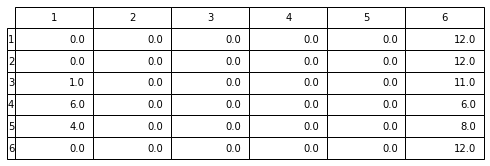

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame(conf)
df.index = df.index + 1
df.columns = df.columns + 1
fig,ax = plt.subplots(figsize=((len(df.columns)+1)*1.2, (len(df)+1)*0.4))
ax.axis('off')
tbl = ax.table(cellText=df.values,
               bbox=[0,0,1,1],
               colLabels=df.columns,
               rowLabels=df.index)
plt.show() 